In [53]:
import pandas as pd

#df = pd.read_pickle('https://pandora.infn.it/public/dc0503/dl/dataset_pol_vbs_full2018v9_VBS_2j_em_lowZ_RDF_DNN.pkl')
df = pd.read_pickle('https://pandora.infn.it/public/45d653/dl/dataset_pol_vbs_full2018v9_VBS_WW_2j_RDF_DNN.pkl')
pd.set_option('display.max_columns', None)
df_MIX = df[df['isMIX']==1]
df = df[df['isMIX']==0]
df = df.drop(columns=['isMIX', 'isBKG'])
df

CleanJet_eta_1  CleanJet_eta_2  CleanJet_phi_1  CleanJet_phi_2  \
0            -3.388184        2.205078        1.802246        0.363647   
1             4.058594       -4.141602        2.967773       -2.088867   
2             2.795410       -3.854492       -3.104980        0.285156   
3            -1.908691        2.808105        0.061462       -1.307617   
4            -1.660889        1.384277        0.029713        2.784180   
...                ...             ...             ...             ...   
147397       -3.149902        1.666992       -1.745850       -0.758057   
147398       -2.343750        2.444824       -1.157227        1.780762   
147399        3.425781       -3.452148        2.890625        1.016357   
147400        1.087891       -2.342285        2.562500       -1.098389   
147401       -2.467773        1.070801        1.739990        2.208984   

        CleanJet_pt_1  CleanJet_pt_2  Lepton_eta_1  Lepton_eta_2  \
0          104.296181      84.908562      0.833374      0.349487   
1           52.303402      36.191532     -1.137939     -0.053261   
2           92.235878      79.289093     -1.781006      2.118652   
3          297.881683      64.230476     -1.623535     -1.831787   
4          320.643433     216.406082      1.288086     -0.945435   
...               ...            ...           ...           ...   
147397      59.399025      56.183453      2.083008      0.054047   
147398     133.979919      64.832031      0.430420      0.490295   
147399      58.359455      44.568913     -1.020752      0.755127   
147400     634.029358     162.717682     -0.505615      0.905151   
147401     176.994720      88.670540     -1.272217      0.718506   

        Lepton_phi_1  Lepton_phi_2  Lepton_pt_1  Lepton_pt_2       Rpt  \
0           2.574219     -0.416687   329.093353    63.138081  2.346338   
1           0.139160      2.794434   151.515274    81.827065  6.549625   
2           3.002441     -2.739258    60.247185    21.934372  0.180696   
3           2.716797     -2.236328   255.139267    72.175308  0.962456   
4          -1.187256     -0.810791    87.460762    36.131149  0.045541   
...              ...           ...          ...          ...       ...   
147397      0.909668      0.052490    34.398266    21.401354  0.220592   
147398      0.013178     -2.620605    85.293953    60.717915  0.596219   
147399      1.191406      0.511475    58.797493    17.742132  0.401071   
147400     -0.345215     -0.764648   216.432007    42.856579  0.089907   
147401     -1.284424      1.726562   148.263199    54.505421  0.514912   

         Zepp_l1   Zepp_l2   Zepp_ll    detajj    detall    dphijj  \
0       1.424927  0.941040  1.182983  5.593262  0.483887  1.438599   
1      -1.096436 -0.011757  0.554096  8.200195  1.084679  1.226545   
2      -1.251465  2.648193  0.698364  6.649902  3.899658  2.893049   
3      -2.073242 -2.281494  2.177368  4.716797  0.208252  1.369080   
4       1.426392 -0.807129  0.309631  3.045166  2.233521  2.754467   
...          ...       ...       ...       ...       ...       ...   
147397  2.824463  0.795502  1.809982  4.816895  2.028961  0.987793   
147398  0.379883  0.439758  0.409821  4.788574  0.059875  2.937988   
147399 -1.007568  0.768311  0.119629  6.877930  1.775879  1.874268   
147400  0.121582  1.532349  0.826965  3.430176  1.410767  2.622297   
147401 -0.573730  1.416992  0.421631  3.538574  1.990723  0.468994   

        dphilep1jet1  dphilep1jet2  dphilep1jj  dphilep2jet1  dphilep2jet2  \
0           0.771973      2.210571    1.401766      2.218933      0.780334   
1           2.828613      2.228027    2.968743      0.173340      1.399885   
2           0.175763      2.717285    0.727221      0.365723      3.024414   
3           2.655334      2.258771    2.855136      2.297791      0.928711   
4           1.216969      2.311750    1.813737      0.840504      2.688215   
...              ...           ...         ...           ...           ...   
147397      2.655518      

In [54]:
import math
import numpy as np
import tensorflow as tf

In [55]:
import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, InputLayer
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import copy
print(tf.__version__)
from tensorflow.python.client import device_lib
tf.config.run_functions_eagerly(True)

2.7.0-rc1


In [56]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

nclasses = 2
features = df.columns[:len(df.columns)-nclasses-1]

NDIM = len(features)
print(NDIM)
for col in df.columns:
    df[col] = np.hstack(df[col])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = shuffle(df)

# Perform the splitting and define training and validation datasets
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_val = df[~msk]

X = df_train.values[:,0:NDIM+1]
Y = df_train.values[:,NDIM+1:NDIM+1+nclasses] # isLL, isMIX, isTT, isBKG

X_val = df_val.values[:,0:NDIM+1]
Y_val = df_val.values[:,NDIM+1:NDIM+1+nclasses] # isLL, isMIX, isTT, isBKG
print(Y,Y_val)

56
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]] [[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [41]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

test = SelectKBest(score_func=f_classif, k=10)
test.feature_names_in_=df_train.columns.values[:-nclasses]
print(test.feature_names_in_)
all_features = []
for i in range(nclasses):
    fit = test.fit(X, Y[...,i])
    # summarize scores
    set_printoptions(precision=3)
    print(fit.scores_)
    features = fit.transform(X)
    print(test.get_feature_names_out(df_val.columns.values[:-nclasses]))
    for feature in test.get_feature_names_out(df_val.columns.values[:-nclasses]):
        if feature not in all_features:
            all_features.append(feature)
        else:
            continue
    # summarize selected features
    #print(features, features.shape)
    
print(all_features, len(all_features))

['CleanJet_eta_1' 'CleanJet_eta_2' 'CleanJet_phi_1' 'CleanJet_phi_2'
 'CleanJet_pt_1' 'CleanJet_pt_2' 'Lepton_eta_1' 'Lepton_eta_2'
 'Lepton_phi_1' 'Lepton_phi_2' 'Lepton_pt_1' 'Lepton_pt_2' 'Rpt' 'Zepp_l1'
 'Zepp_l2' 'Zepp_ll' 'detajj' 'detall' 'dphijj' 'dphilep1jet1'
 'dphilep1jet2' 'dphilep1jj' 'dphilep2jet1' 'dphilep2jet2' 'dphilep2jj'
 'dphill' 'dphilljet' 'dphilljetjet' 'dphillmet' 'dphilmet1' 'dphilmet2'
 'dr_l1j1' 'dr_l1j2' 'dr_l2j1' 'dr_l2j2' 'drll' 'ht' 'm2ljj30' 'mT2' 'mTi'
 'm_l1j1' 'm_l1j2' 'm_l2j1' 'm_l2j2' 'mcoll' 'mcollWW' 'mjj' 'mll' 'mtw1'
 'mtw2' 'phi_miss' 'proxyW_l1' 'proxyW_l2' 'pt_miss' 'ptll' 'recoil' 'yll']
[7.631e-01 1.223e+00 1.428e+00 2.900e-01 2.157e+03 4.290e+02 1.032e+00
 6.513e-01 4.888e-01 5.769e-02 2.479e+03 2.507e+01 6.914e+02 1.738e+00
 1.589e-01 7.627e+01 8.841e+02 1.240e+03 6.616e+02 1.149e+01 1.737e+02
 1.849e+00 1.613e+00 4.165e-01 1.049e+01 1.660e+03 2.293e+02 1.826e+02
 1.648e+02 3.679e+00 9.948e+02 9.413e+01 1.110e+02 4.317e+02 1.989e+01
 2.49

In [42]:
NDIM = len(all_features)
#targets = ['isLL', 'isMIX', 'isTT']
targets = ['isLL', 'isTT']
df_train = df_train[all_features + targets]
df_val = df_val[all_features + targets]

X = df_train.values[:,0:NDIM]
Y = df_train.values[:,NDIM:NDIM+nclasses] # isLL, isMIX, isTT, isBKG

X_val = df_val.values[:,0:NDIM]
Y_val = df_val.values[:,NDIM:NDIM+nclasses] # isLL, isMIX, isTT, isBKG

In [57]:
class SimpleNeuralNetwork ( tf.Module ):
    def __init__ (self, nEpochs, learning_rate, N_NODES, n_layers, n_features, n_outputsC=nclasses):
        self.learning_rate = learning_rate
        self.optimizer  = tf.optimizers.Adam (self.learning_rate)
        self.nEpochs = nEpochs
        self.N_NODES = N_NODES
        self.n_layers = n_layers
        self.n_features = n_features
        self.n_outputsC = n_outputsC
        self.weights = self.build (self.n_features, self.N_NODES)
        
                                
    # Define the structure of the model
    def build (self, n_input, N_NODES):
        # initializer = initializers.Ones()

        # Classifier model
        self.model1 = Sequential()
        self.model1.add(Dense (self.N_NODES, activation = 'relu', input_dim  = n_input))
        for i in range(self.n_layers):
            self.model1.add(Dense (self.N_NODES, activation = 'relu'))
        self.model1.add(Dense (self.n_outputsC, activation = 'softmax',input_dim = self.N_NODES))      
        
        return self.model1.weights
     
    # Performs the epochs loop and the actual training.
    # Monitors the training and validation loss functions, both for the classifier and the adversary.
    # Returns the classifier categorical accuracy.
    def fit (self, X, Y, X_val, Y_val, show_loss = False):
        losses = []
        losses_val = []

        self.means = np.mean ( X, axis = 0)
        self.sigmas = np.std ( X, axis = 0)

        for iEpoch in tqdm.tqdm(range(self.nEpochs)):
                l, l_val = self._train (X, Y, X_val, Y_val)
                losses.append ( l )
                losses_val.append ( l_val )

        losses = np.array(losses)               
        losses_val = np.array(losses_val)
               
        plt.plot (losses, color = "c", label='Training set')
        plt.plot (losses_val, color ='tab:blue', label = "Validation set")
        plt.xlabel ("Epoch"); plt.ylabel ("Loss")
        plt.legend(frameon=False)
        plt.show()
        
        ca = tf.keras.metrics.CategoricalAccuracy()
        ca.update_state(Y, self.predict_proba(X))
        
        return ca.result().numpy()

    def save_weights(self, model_name):
        self.model1.save_weights(model_name+'_weights_1')
    
    def load_weights(self, model_name):
        self.model1.load_weights(model_name+'_weights_1')
        
    def save_model(self, model_name):
        self.model1.save("saved_models/"+model_name+"_1")

    def reset_optimizers(self):
        self.optimizer  = tf.optimizers.Adam (self.learning_rate)
        
    def set_epochs(self, epochs):
        self.nEpochs = epochs
        
    # Applies a pre-processing to the input features and returns the classifier representation.
    #@tf.function
    def predict_proba (self, X):
        ppX = (X - self.means)/self.sigmas
        return  tf.clip_by_value ( self.model1 (ppX) , 1e-7, 1. - 1e-7 )


    @tf.function
    def _train (self, X, Y, X_val, Y_val):
        Y_true = tf.cast (Y, tf.float32)
        Y_true_val = tf.cast (Y_val, tf.float32)

        with tf.GradientTape() as gt:
            #gt.watch ( self.weightsC )
            Y_hat = self.predict_proba (X)
            Y_hat_val = self.predict_proba (X_val) #N3(N1(x)) validation set
            
            ## Training set
            # Use the categorical cross-entropy as loss function for the classifier
            cce = tf.keras.losses.CategoricalCrossentropy()
            loss = tf.reduce_mean ( cce( Y_true, Y_hat ) )
            
            ## Validation set
            cce_val = tf.keras.losses.CategoricalCrossentropy()
            loss_val = tf.reduce_mean (cce_val( Y_true_val, Y_hat_val ) )
            
            # Compute the gradient of the overall loss with respect to the classifier weights
            gradients = gt.gradient ( loss, self.weights )

        # Apply the gradients
        self.optimizer.apply_gradients ( zip(gradients, self.weights) )
        
        return loss, loss_val

In [58]:
#dnn = SimpleNeuralNetwork(nEpochs=150, learning_rate=0.0001, N_NODES=137, n_layers=6, n_features=X.shape[1])
dnn = SimpleNeuralNetwork(600, learning_rate=0.0001, N_NODES=50, n_layers=8, n_features=X.shape[1])
# Save initial set of weights (before training) to re-initialize the ADNN in later steps.
# Useful if we want to restart always from the same starting point during the optimization studies.
dnn.save_weights("my_simpleDNN_model_polVBS_RECO_LLvsTT_inclusive_RDF")

In [59]:
print(X.shape, Y.shape)

(78880, 57) (78880, 2)


100%|██████████| 600/600 [00:33<00:00, 17.96it/s]


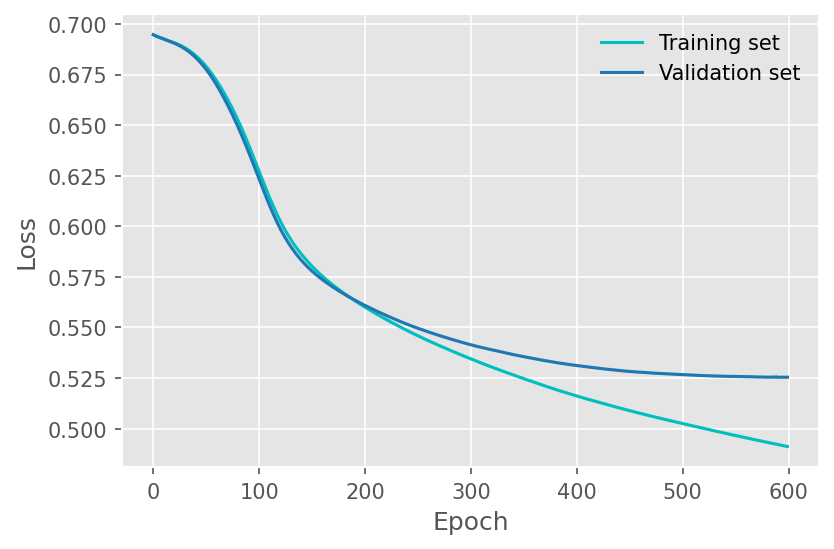

In [60]:
acc = dnn.fit (X.astype(np.float32), Y.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32))

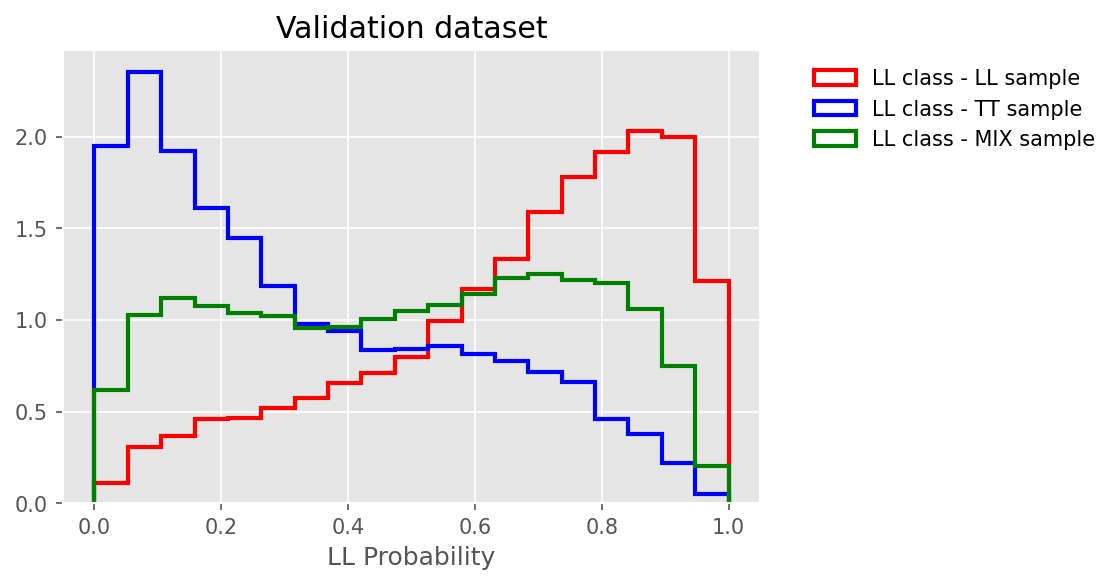

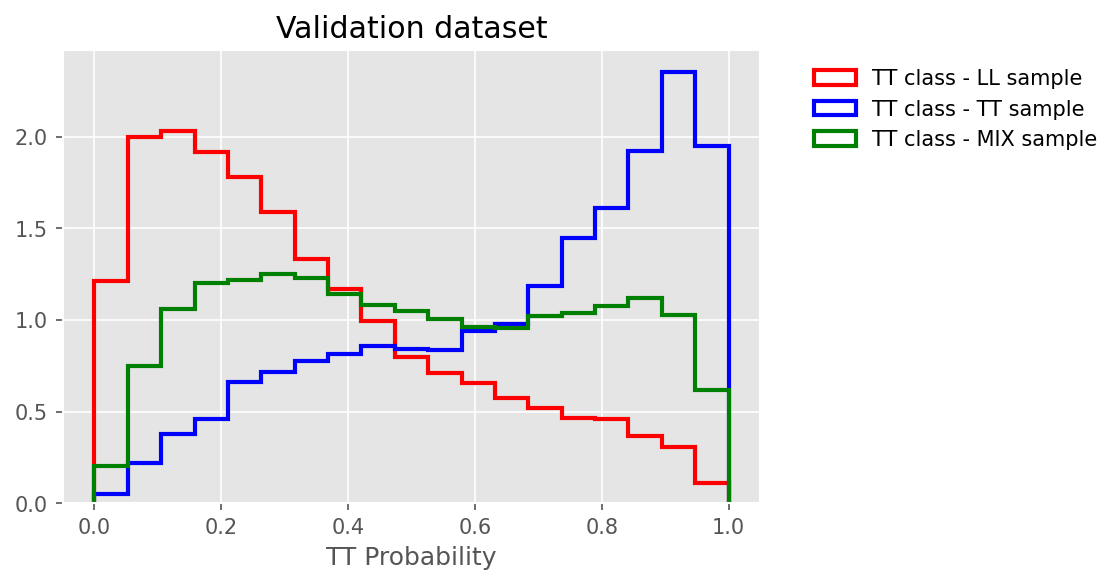

In [83]:
Y_predict_train = dnn.predict_proba(X)
Y_predict_val = dnn.predict_proba(X_val)

X_mix = df_MIX.values[:,0:NDIM+1]
Y_mix = df_MIX.values[:,NDIM+1:NDIM+1+nclasses] # isLL, isMIX, isTT, isBKG
Y_predict_mix = dnn.predict_proba(X_mix)

axis = np.linspace(0,1,20)

#targets = ['LL', 'MIX', 'TT']
targets = ['LL', 'TT']
predictions = targets
#colors = ['r', 'g', 'b']
colors = ['r', 'b']

Y_targets = {}
Y_predictions = {}

for target in targets:
    Y_targets[target] = dnn.predict_proba( df_val[ df_val['is' + target]==1 ].values[:,0:NDIM+1] )
    Y_predictions[target] = {}
    for iprediction, prediction in enumerate(predictions):
        Y_predictions[target][prediction] = Y_targets[target][:,iprediction]

for i,prediction in enumerate(predictions):
    for target, mycolor in zip(targets, colors):
        plt.hist(Y_predictions[target][prediction].numpy(), bins = axis, label = prediction + ' class - ' + target + ' sample', histtype='step', color=mycolor,  density=True, linewidth=2 )
    plt.hist(Y_predict_mix.numpy()[...,i], bins = axis, label = prediction + ' class - MIX sample', histtype='step', color='g',  density=True, linewidth=2 )
    plt.title('Validation dataset')
    plt.xlabel(prediction + ' Probability')
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
    #plt.yscale('log')
    plt.show()

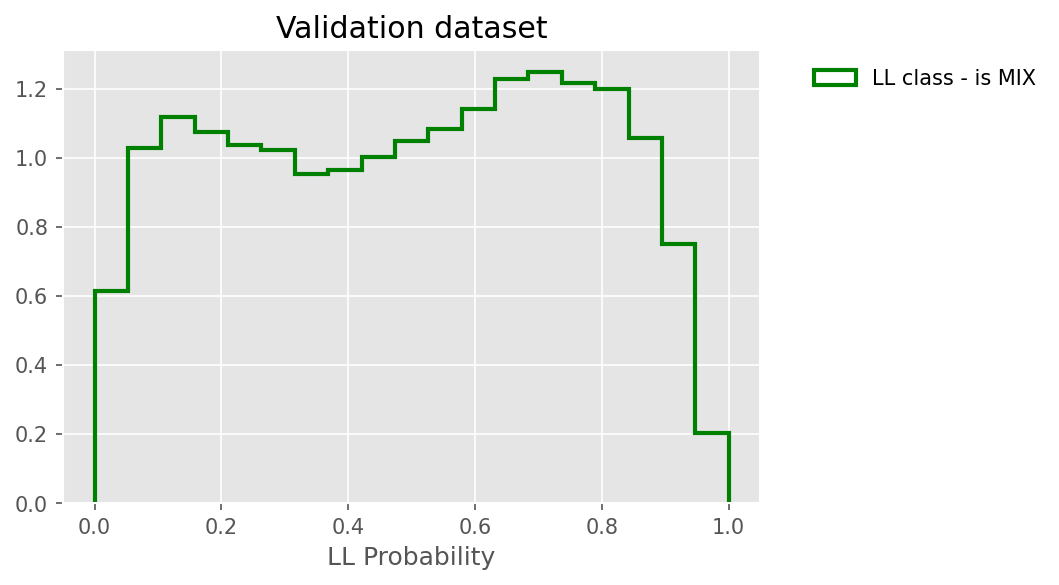

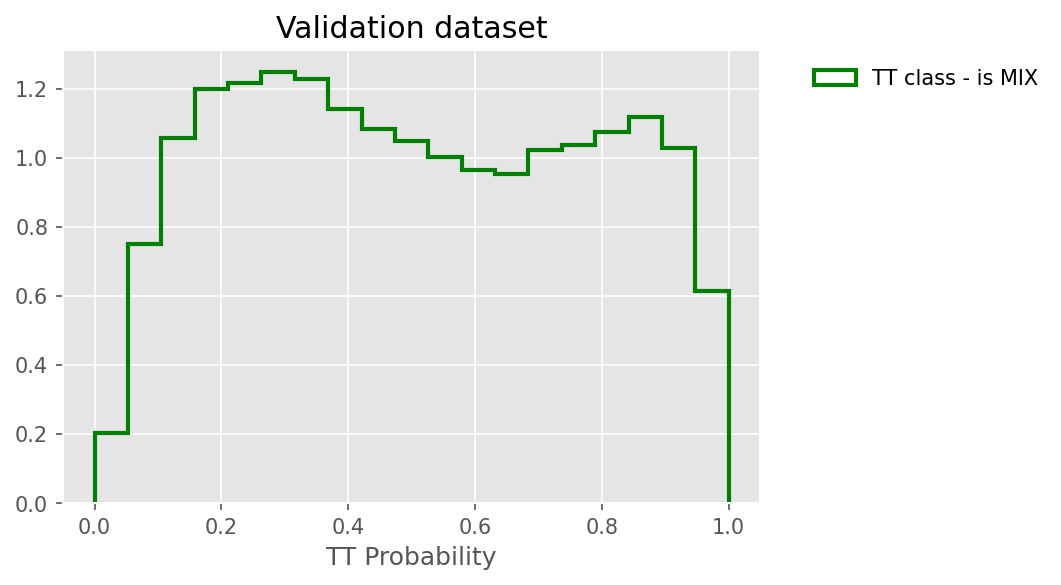

In [67]:
X_mix = df_MIX.values[:,0:NDIM+1]
Y_mix = df_MIX.values[:,NDIM+1:NDIM+1+nclasses] # isLL, isMIX, isTT, isBKG

Y_predict_mix = dnn.predict_proba(X_mix)

axis = np.linspace(0,1,20)

targets = ['MIX']
predictions = ['LL', 'TT']
colors = ['g']

Y_targets_MIX = {}
Y_predictions_MIX = {}

for target in targets:
    Y_targets_MIX[target] = dnn.predict_proba( df_MIX[ df_MIX['is' + target]==1 ].values[:,0:NDIM+1] )
    Y_predictions_MIX[target] = {}
    for iprediction, prediction in enumerate(predictions):
        Y_predictions_MIX[target][prediction] = Y_targets_MIX[target][:,iprediction]

for prediction in predictions:
    for target, mycolor in zip(targets, colors):
        plt.hist(Y_predictions_MIX[target][prediction].numpy(), bins = axis, label = prediction + ' class - is ' + target, histtype='step', color=mycolor,  density=True, linewidth=2 )
    plt.title('Validation dataset')
    plt.xlabel(prediction + ' Probability')
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.))
    #plt.yscale('log')
    plt.show()

In [64]:
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, anderson_ksamp

X = df_val.values[:,0:NDIM+1]
Y_true = df_val.values[:,NDIM+1:NDIM+1+nclasses]
Y_pred = dnn.predict_proba(X)

# The classifier categorical accuracy is a good and simple metrics to evaluate the overall classification performance
Y_true_max = np.argmax(Y_true, axis=1)
Y_pred_max = np.argmax(Y_pred, axis=1)
print("Classifier categorical accuracy = ", accuracy_score(Y_true_max, Y_pred_max))

Classifier categorical accuracy =  0.7394780276459666


In [49]:
# Y_pred_list = Y_pred.numpy().tolist()
# dnn_columns = [[], [],[]] #isLL, isMIX, isTT
# for event in range(len(Y_pred_list)):
#     for column in range(len(dnn_columns)):
#         dnn_columns[column].append(Y_pred_list[event][column])
# for itarget, target in enumerate(targets):
#     df_val[target + '_prob'] = dnn_columns[itarget]

In [50]:
#df_val[df_val['LL_prob'] < 0.2]

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#from matplotlib.backends.backend_pdf import PdfPages

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 16)
    plt.yticks(tick_marks, classes, fontsize = 16)

    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=10)

    plt.xlabel("Predicted label", fontsize=16)
    plt.ylabel("True label", fontsize=16)

    
    plt.tight_layout()

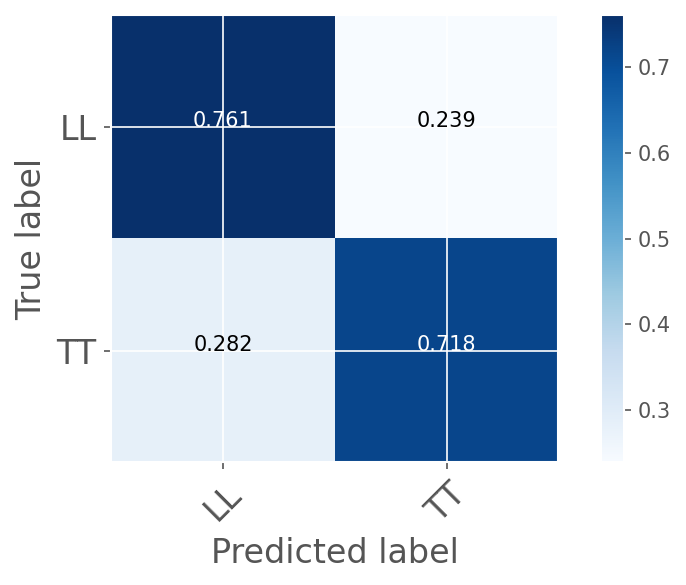

In [66]:
C = confusion_matrix(Y_true_max, Y_pred_max, normalize="true")
C = np.around(C, decimals=3)
#target_names = ['LL', 'MIX', 'TT','BKG']

plt.figure()
plot_confusion_matrix(C, classes=targets, title='')
plt.show(1) 

In [25]:
!pip install shap

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [26]:
import shap
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
    
impact = plt.figure(3)
background = X[np.random.choice(X.shape[0], 500, replace=False)]
#explainer = shap.KernelExplainer(dnn.predict_proba, background)
explainer = shap.KernelExplainer(dnn.predict_proba, shap.sample(X, 1))
   
shap_values = explainer.shap_values(background)

  0%|          | 0/500 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

<Figure size 900x600 with 0 Axes>

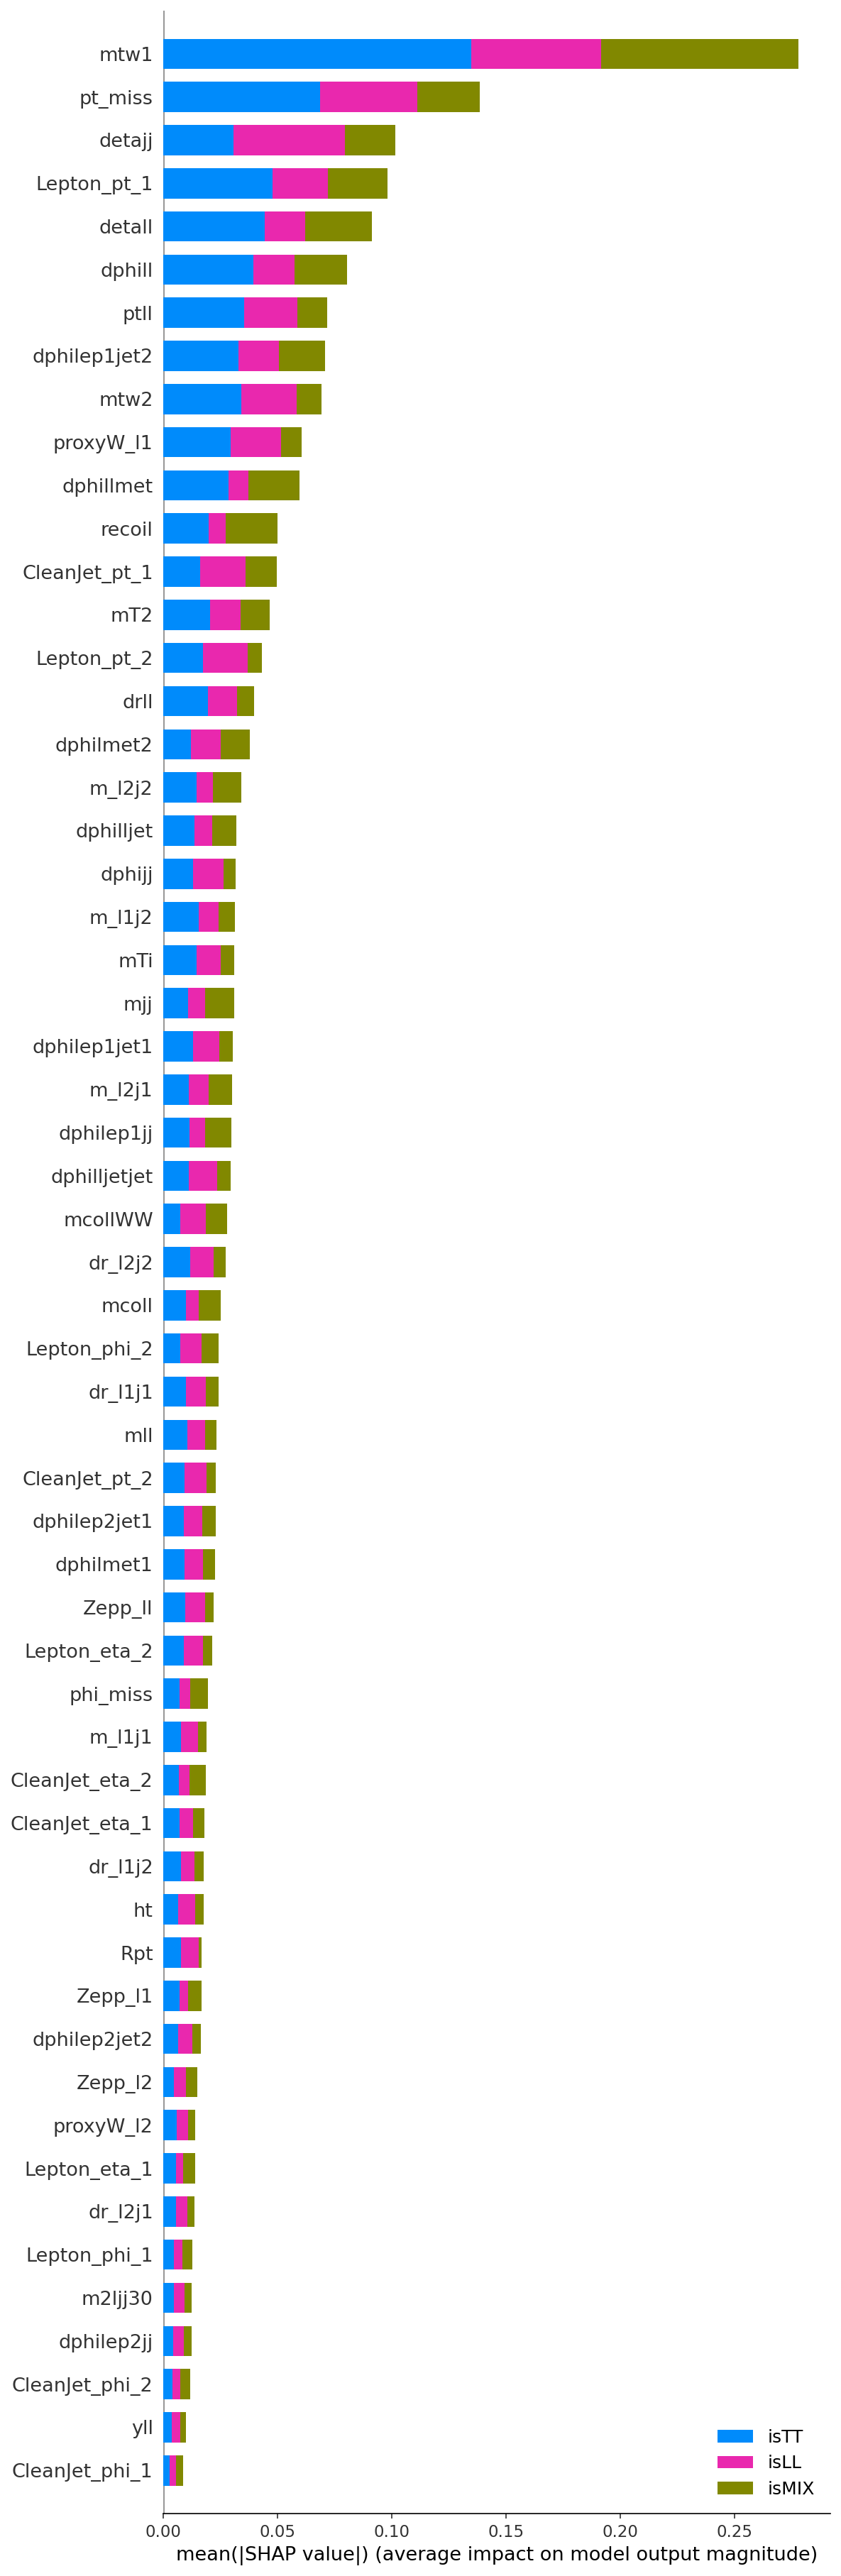

In [27]:
shap.summary_plot(shap_values, df_val[:len(df_val)-2].columns.values, plot_type="bar",class_names=['isLL', 'isMIX', 'isTT'], max_display =100)
impact.savefig('shap_values_my_simpleDNN_model_polVBS_RECO_onlySIG_inclusive_RDF.pdf')
impact.show(3)

In [127]:
!pip install optuna

     |████████████████████████████████| 365 kB 9.5 MB/s            
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [24]:
import optuna
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import cm


def evaluate_performance (trial) :
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3)
    n_layers = trial.suggest_int('n_layers', 1, 10)
    N_NODES = trial.suggest_int('N_NODES', 1, 100)

    dnn = SimpleNeuralNetwork(600, learning_rate, n_layers, N_NODES, n_features=X.shape[1])
   
    # Load the initial weights (before training) and re-initialize the optimizers to always restart from the same initial set of weights
    dnn.reset_optimizers()
    # dnn.load_weights("simpleDNN_model_init")
    acc = dnn.fit (X.astype(np.float32), Y.astype(np.float32), X_val.astype(np.float32), Y_val.astype(np.float32))
 
    # Plot VBF output distributions
    pred_isLL = dnn.predict_proba( df_val[ df_val['isLL']==1 ].values[:,0:NDIM] )
    Y_predLL_isLL = pred_isLL[:,0]

    pred_isMIX = dnn.predict_proba( df_val[ df_val['isMIX']==1 ].values[:,0:NDIM] )
    Y_predLL_isMIX = pred_isMIX[:,0]

    pred_isTT = dnn.predict_proba( df_val[ df_val['isTT']==1 ].values[:,0:NDIM] )
    Y_predLL_isTT = pred_isTT[:,0]
    
    axis = np.linspace(0,1,40)

    plt.hist(Y_predLL_isLL.numpy(), bins = axis, label = 'LL events',  histtype='step', color='r',  density=True, linewidth=1 )
    plt.hist(Y_predLL_isMIX.numpy(), bins = axis, label = 'MIX events',  histtype='step', color='g',  density=True, linewidth=1 )
    plt.hist(Y_predLL_isTT.numpy(), bins = axis, label = 'TT events',  histtype='step', color='b',  density=True, linewidth=1 )
    plt.xlabel("LL output")
    plt.legend(frameon=False, loc = 9)
    plt.show()
    
    # Compute classifier categorical accuracy
    Y_pred_for_cm = dnn.predict_proba(X_val)
    Y_true_max = np.argmax(Y_val, axis=1)
    Y_pred_max = np.argmax(Y_pred_for_cm, axis=1)

    ca = accuracy_score(Y_true_max, Y_pred_max)

    return ca

[I 2023-04-19 13:04:47,049] A new study created in memory with name: no-name-429b422a-ae92-4330-801b-70ac0a31ec27
100%|██████████| 600/600 [01:27<00:00,  6.85it/s]


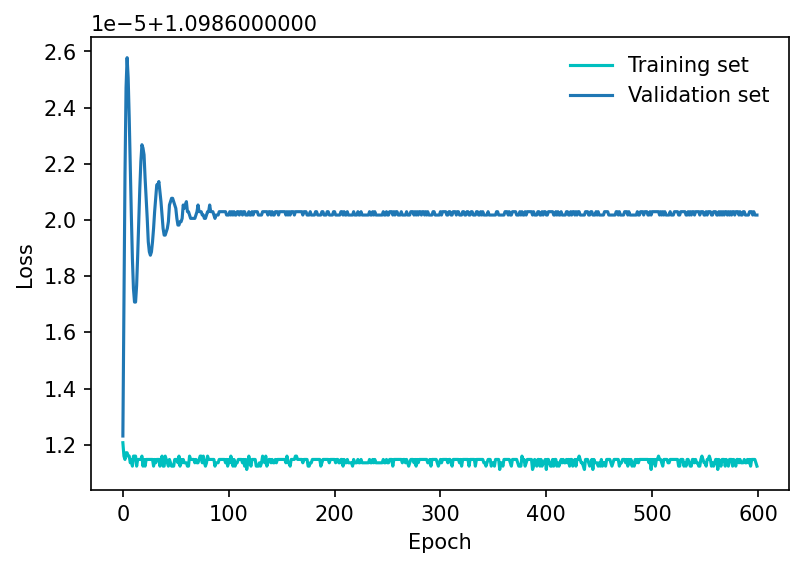

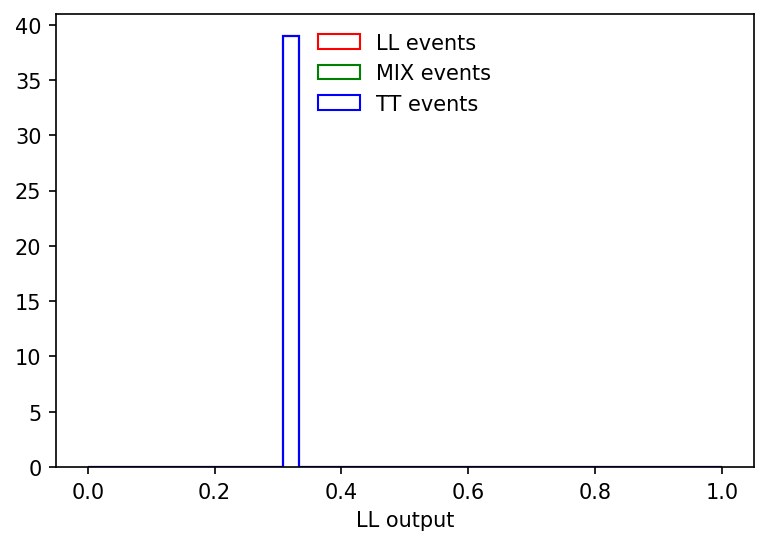

[I 2023-04-19 13:06:15,892] Trial 0 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0009449258057648283, 'n_layers': 4, 'N_NODES': 94}. Best is trial 0 with value: 0.33094642977774774.
100%|██████████| 600/600 [01:16<00:00,  7.85it/s]


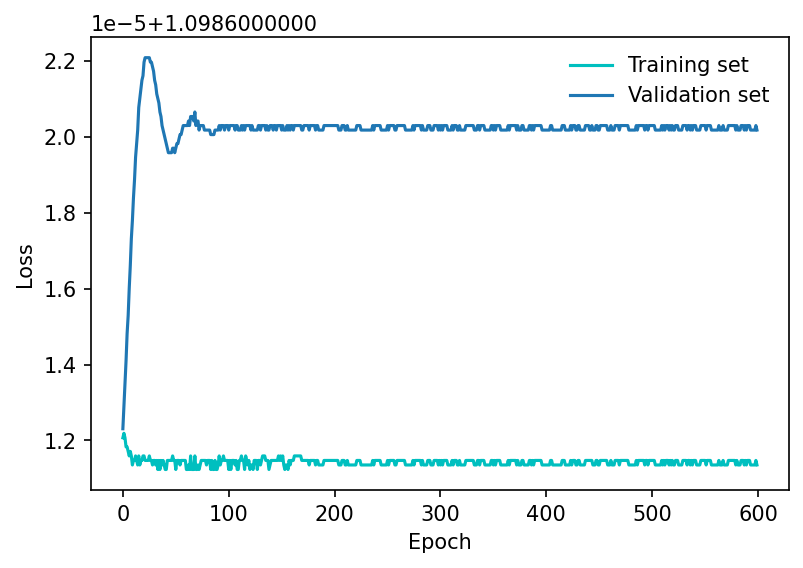

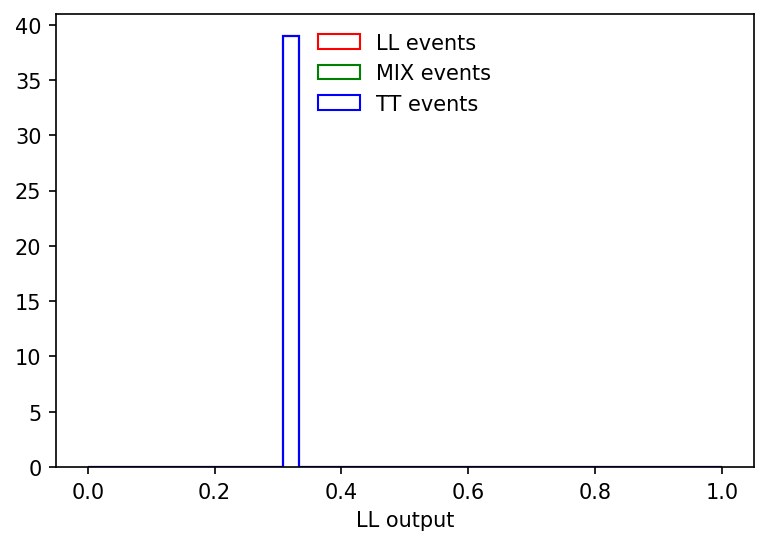

[I 2023-04-19 13:07:33,432] Trial 1 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.00012701450361077345, 'n_layers': 2, 'N_NODES': 79}. Best is trial 0 with value: 0.33094642977774774.
100%|██████████| 600/600 [00:37<00:00, 15.91it/s]


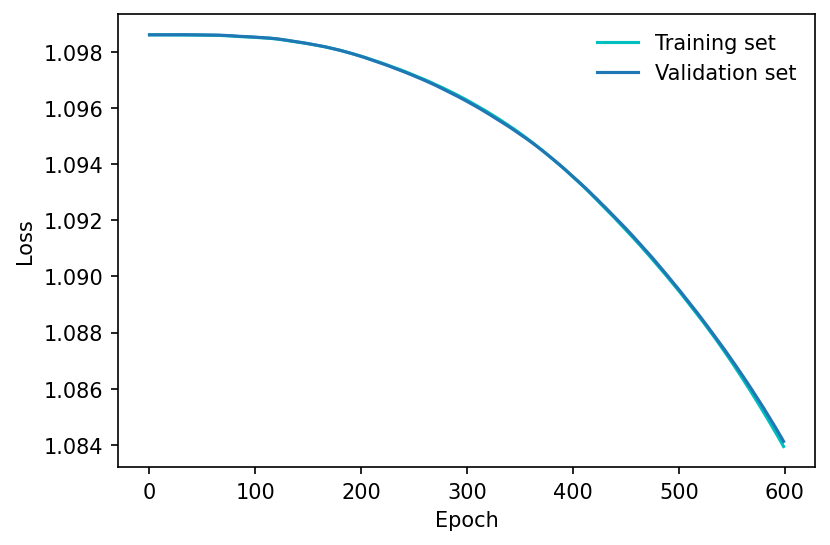

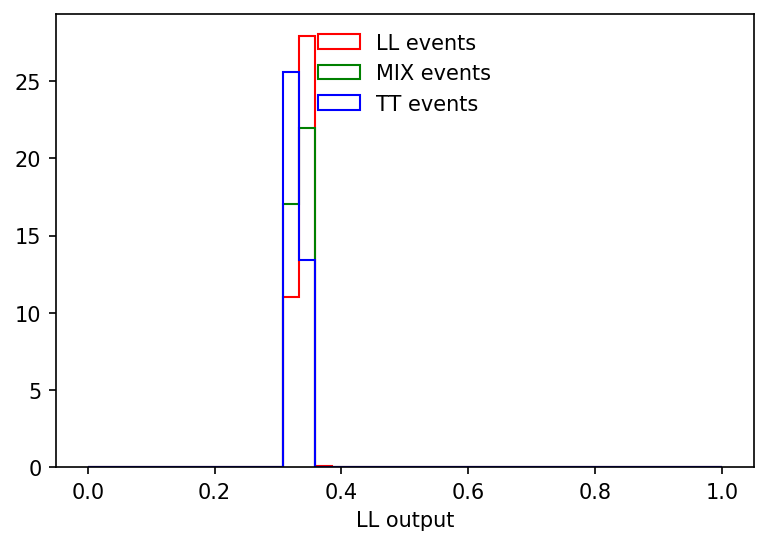

[I 2023-04-19 13:08:11,735] Trial 2 finished with value: 0.45977166790515434 and parameters: {'learning_rate': 6.001475050010011e-05, 'n_layers': 7, 'N_NODES': 24}. Best is trial 2 with value: 0.45977166790515434.
100%|██████████| 600/600 [01:23<00:00,  7.15it/s]


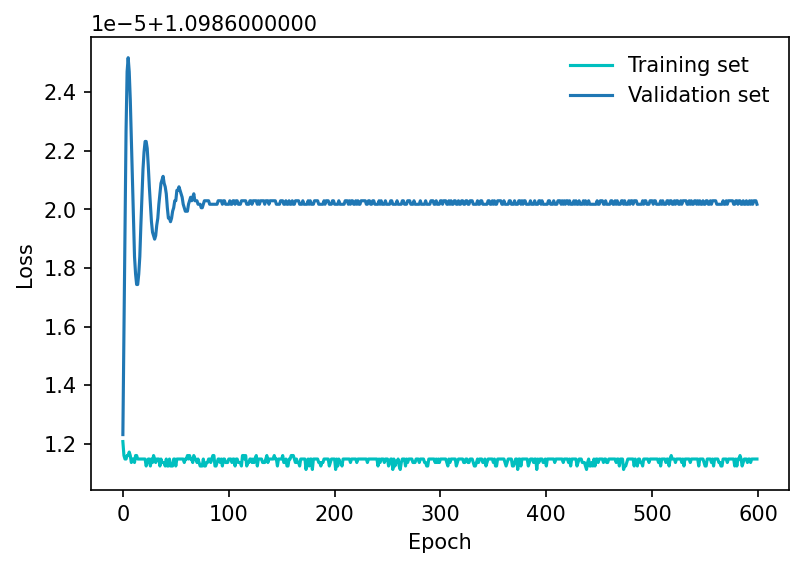

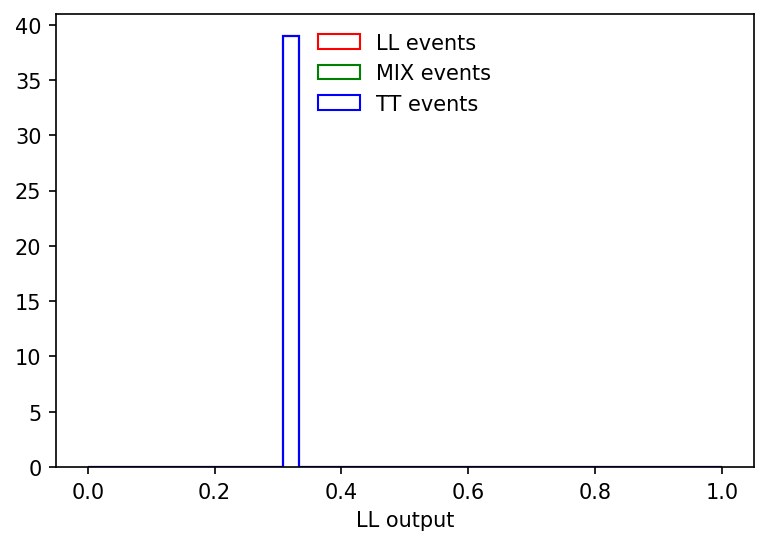

[I 2023-04-19 13:09:36,843] Trial 3 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0007435058512347195, 'n_layers': 3, 'N_NODES': 92}. Best is trial 2 with value: 0.45977166790515434.
100%|██████████| 600/600 [00:46<00:00, 12.83it/s]


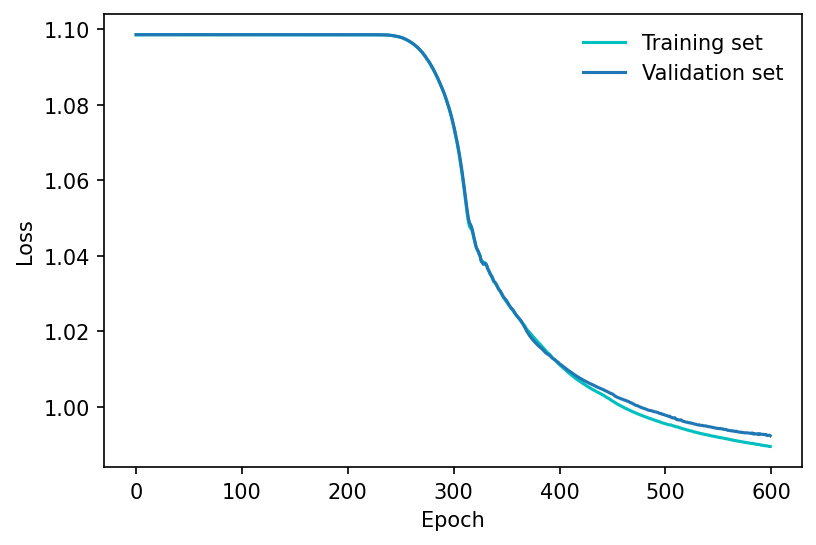

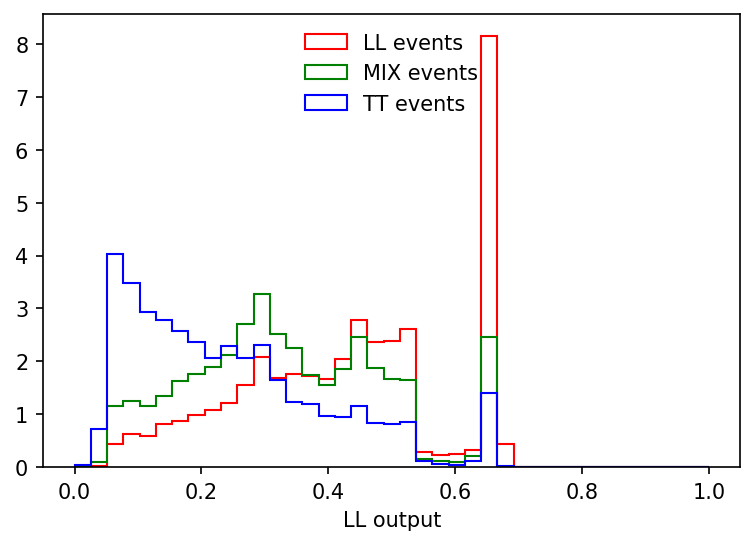

[I 2023-04-19 13:10:24,238] Trial 4 finished with value: 0.5078362494089036 and parameters: {'learning_rate': 0.0006483875076325482, 'n_layers': 9, 'N_NODES': 34}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [00:47<00:00, 12.52it/s]


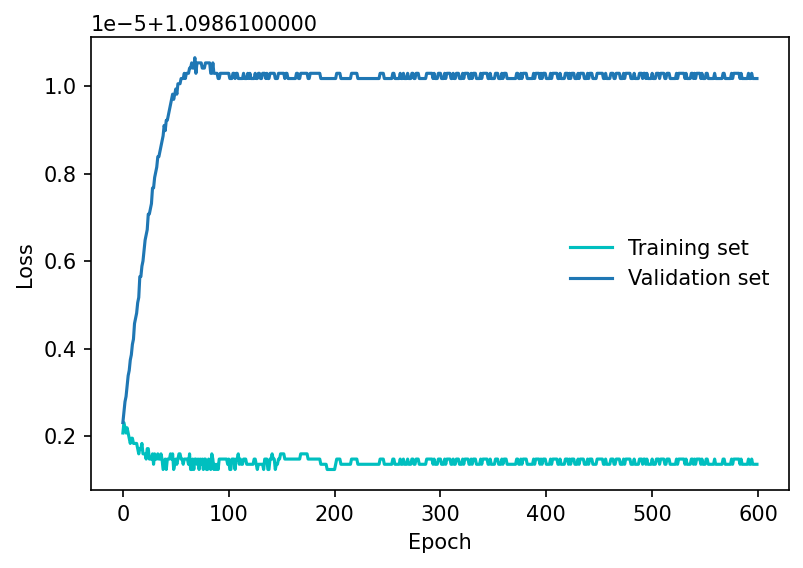

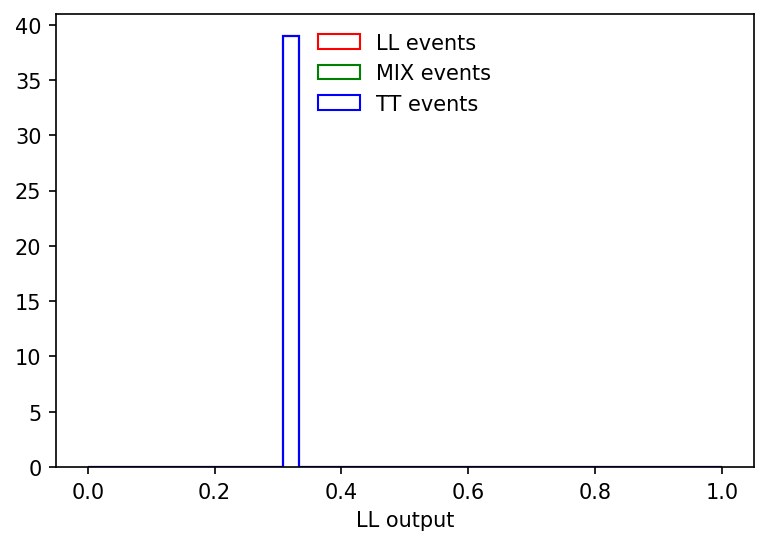

[I 2023-04-19 13:11:12,881] Trial 5 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 4.1289373188375375e-05, 'n_layers': 3, 'N_NODES': 43}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [00:36<00:00, 16.38it/s]


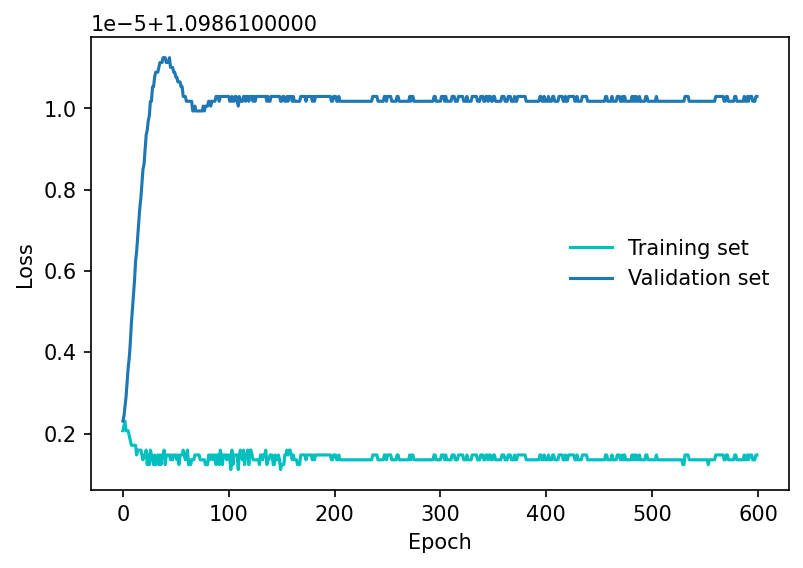

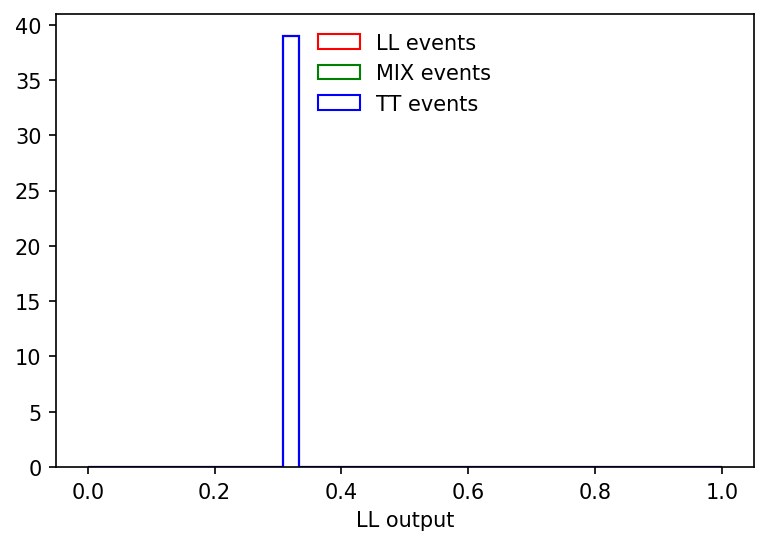

[I 2023-04-19 13:11:50,089] Trial 6 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 7.243177407557936e-05, 'n_layers': 5, 'N_NODES': 24}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [00:29<00:00, 20.63it/s]


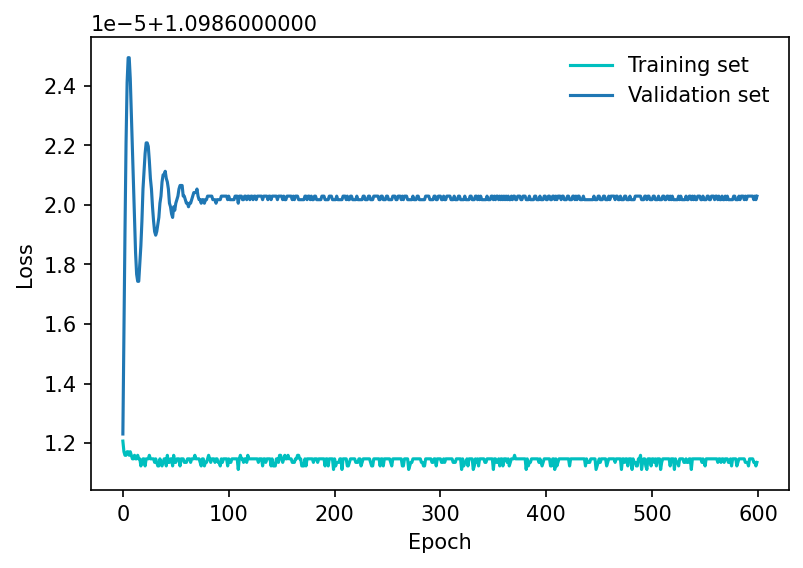

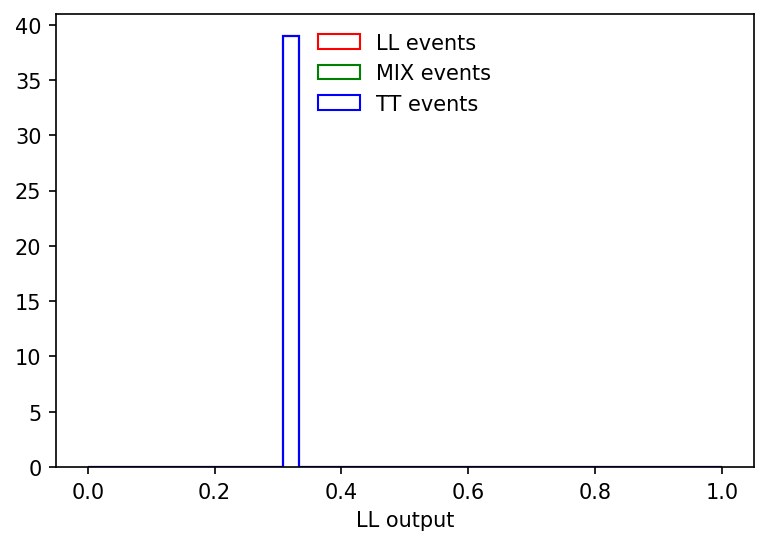

[I 2023-04-19 13:12:19,750] Trial 7 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0006857253975460844, 'n_layers': 1, 'N_NODES': 17}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [01:35<00:00,  6.30it/s]


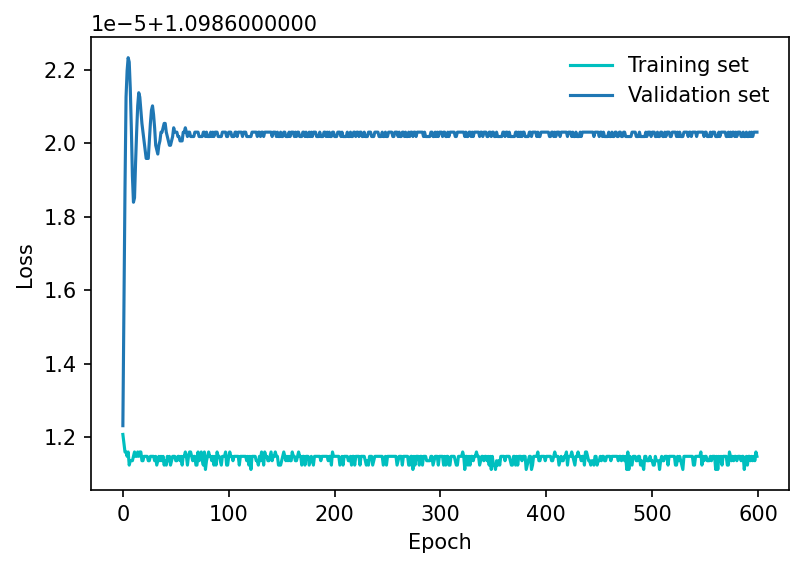

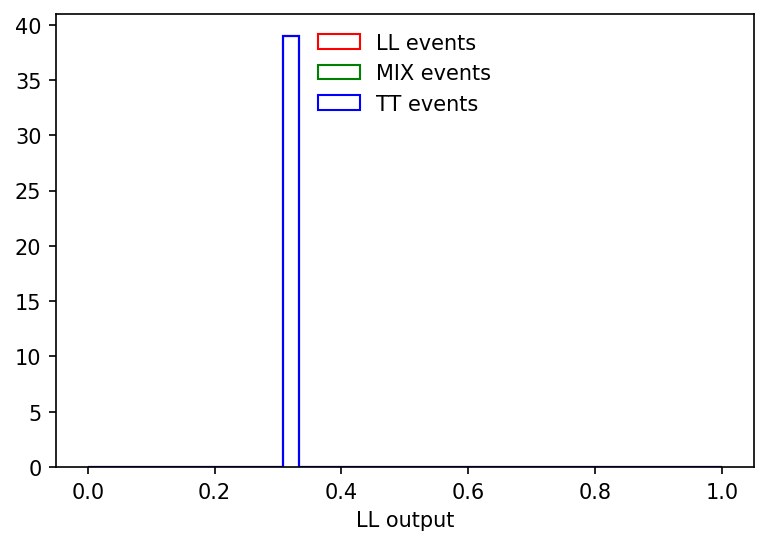

[I 2023-04-19 13:13:56,076] Trial 8 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0006048715909575244, 'n_layers': 8, 'N_NODES': 92}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [00:46<00:00, 12.89it/s]


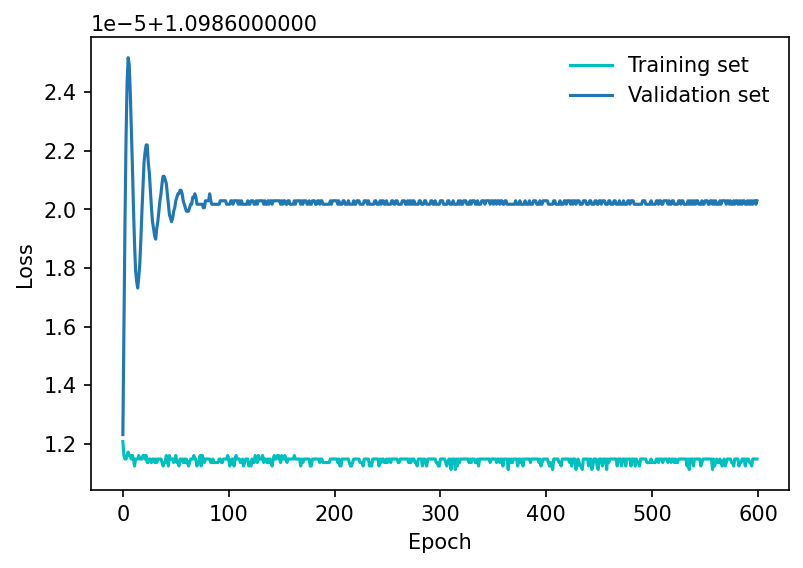

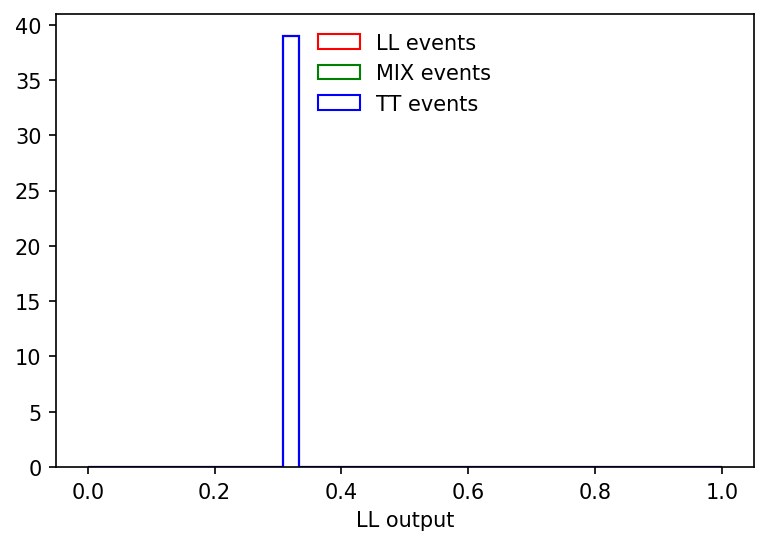

[I 2023-04-19 13:14:43,348] Trial 9 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0007111135215791084, 'n_layers': 4, 'N_NODES': 42}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [01:12<00:00,  8.25it/s]


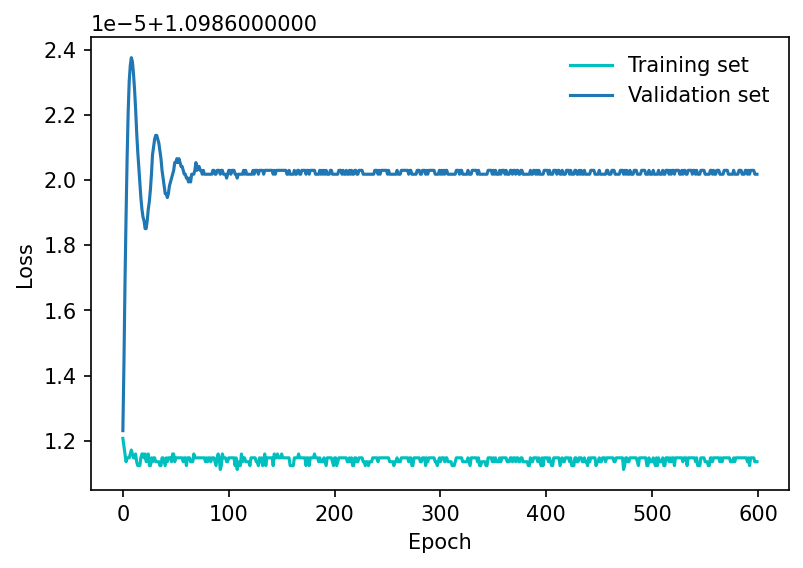

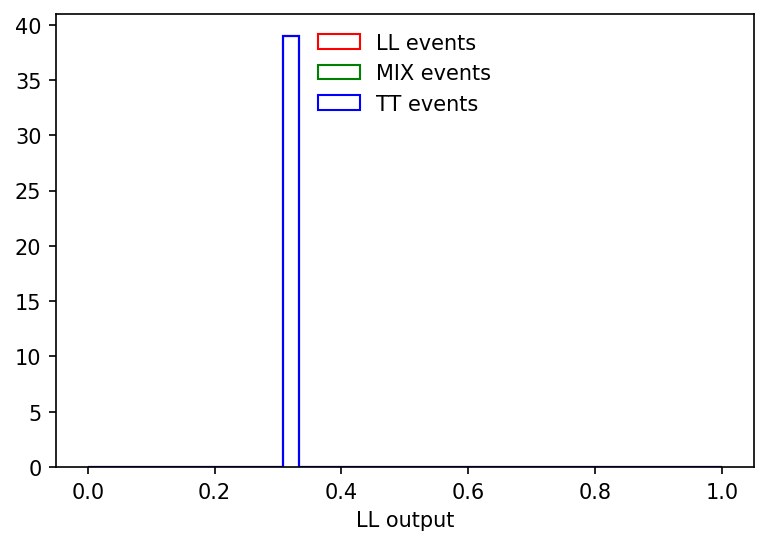

[I 2023-04-19 13:15:57,011] Trial 10 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0003644176661860374, 'n_layers': 10, 'N_NODES': 64}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [00:17<00:00, 33.88it/s]


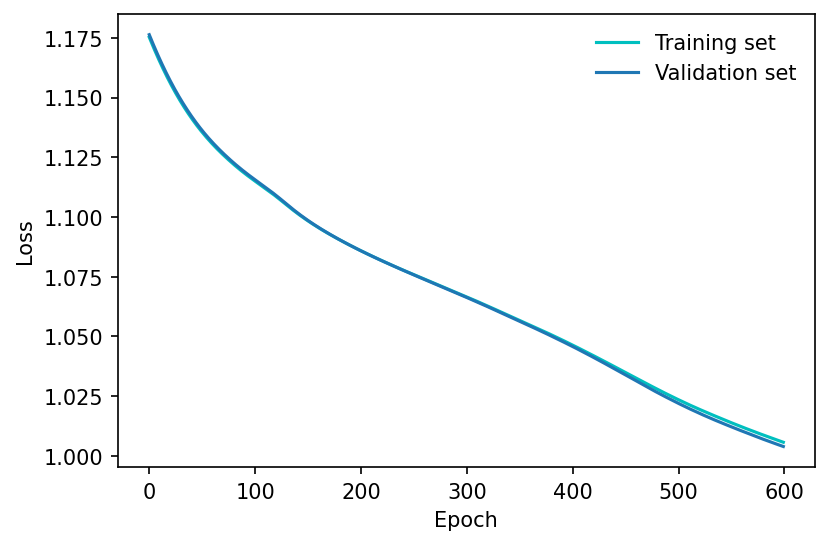

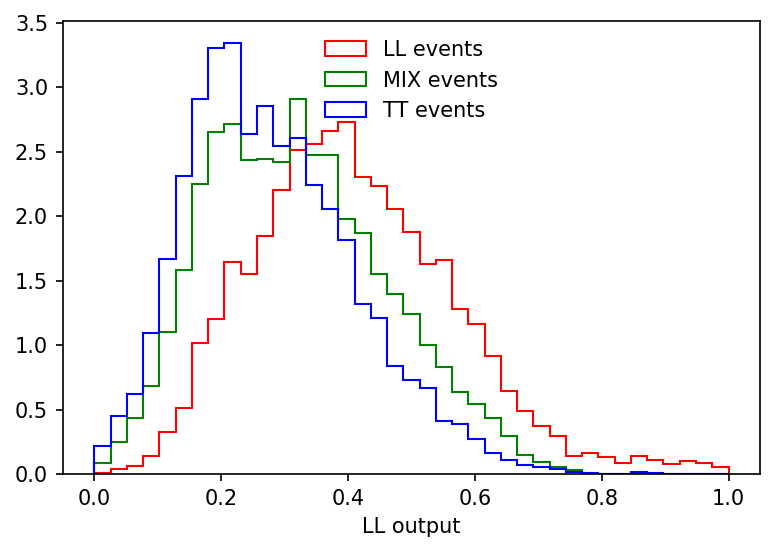

[I 2023-04-19 13:16:15,158] Trial 11 finished with value: 0.48854961832061067 and parameters: {'learning_rate': 0.0003764166620620635, 'n_layers': 7, 'N_NODES': 2}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [00:17<00:00, 33.80it/s]


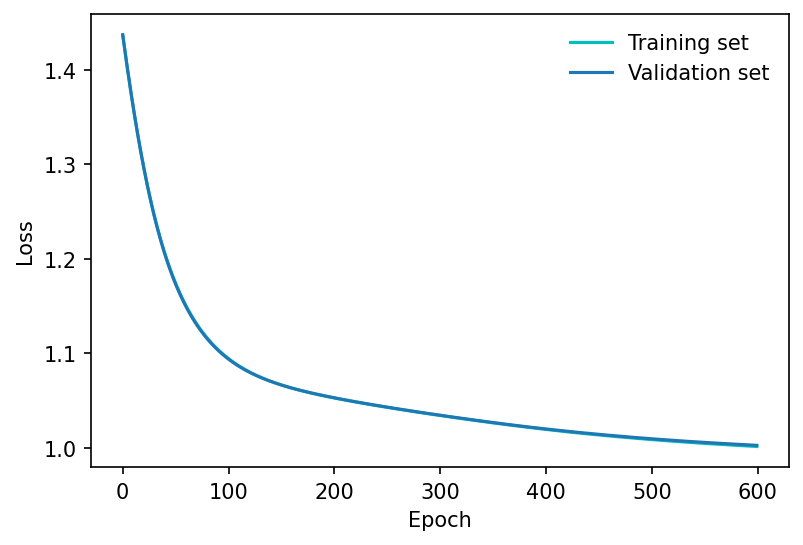

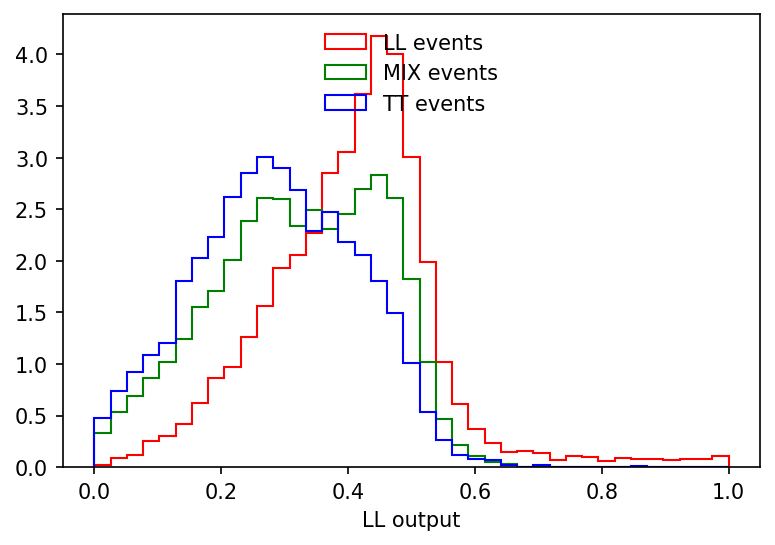

[I 2023-04-19 13:16:33,499] Trial 12 finished with value: 0.49422414375464435 and parameters: {'learning_rate': 0.0004390760871909092, 'n_layers': 10, 'N_NODES': 1}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [00:17<00:00, 34.33it/s]


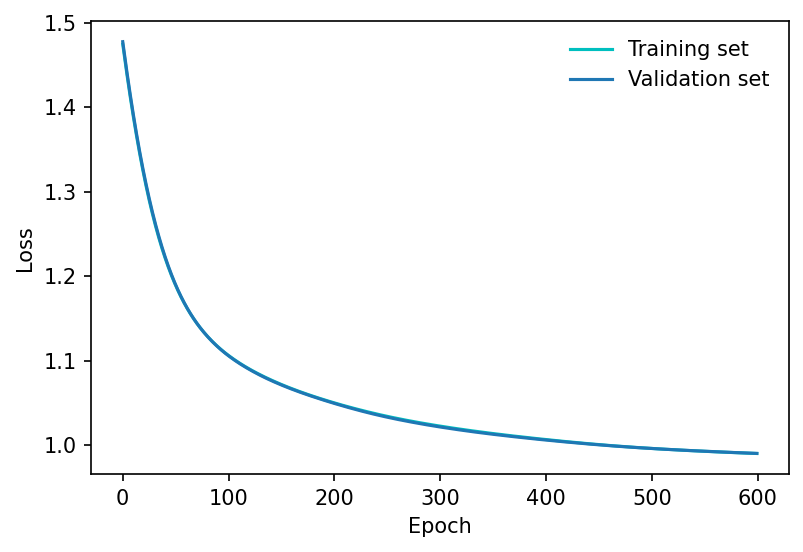

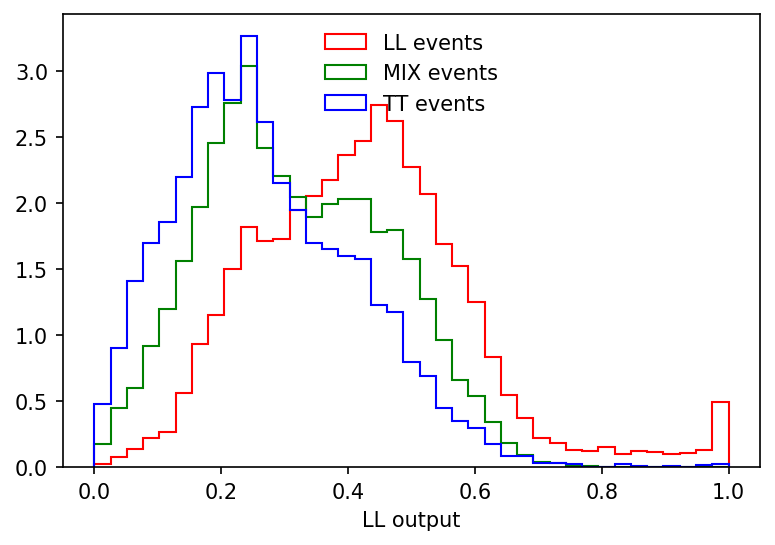

[I 2023-04-19 13:16:51,429] Trial 13 finished with value: 0.5027697088428021 and parameters: {'learning_rate': 0.0004920372873098321, 'n_layers': 10, 'N_NODES': 2}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [01:07<00:00,  8.91it/s]


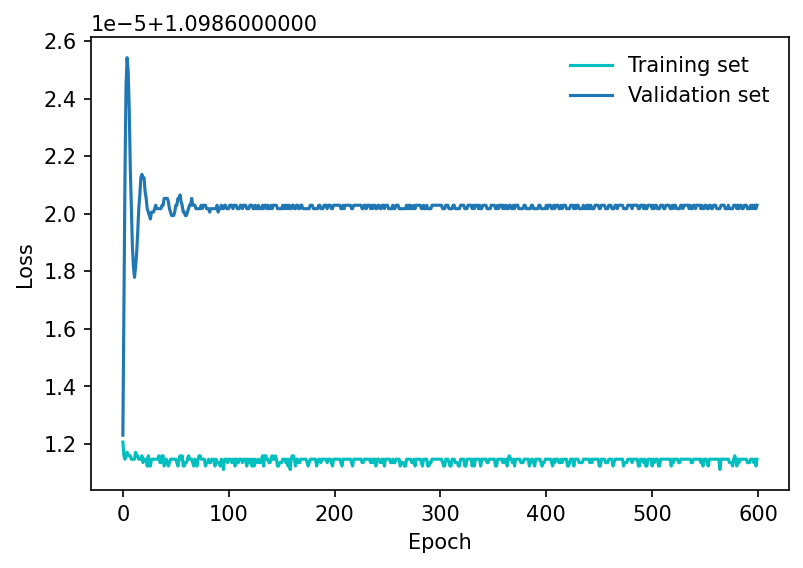

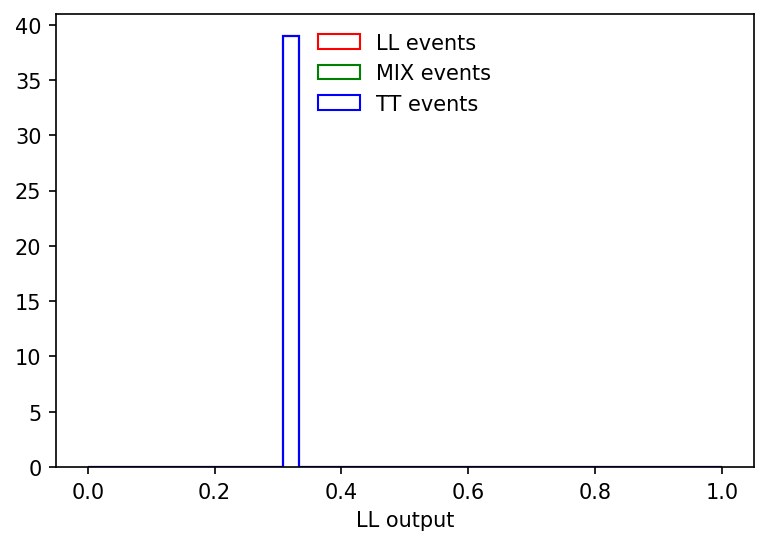

[I 2023-04-19 13:17:59,689] Trial 14 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0005493538969605281, 'n_layers': 9, 'N_NODES': 57}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [00:44<00:00, 13.57it/s]


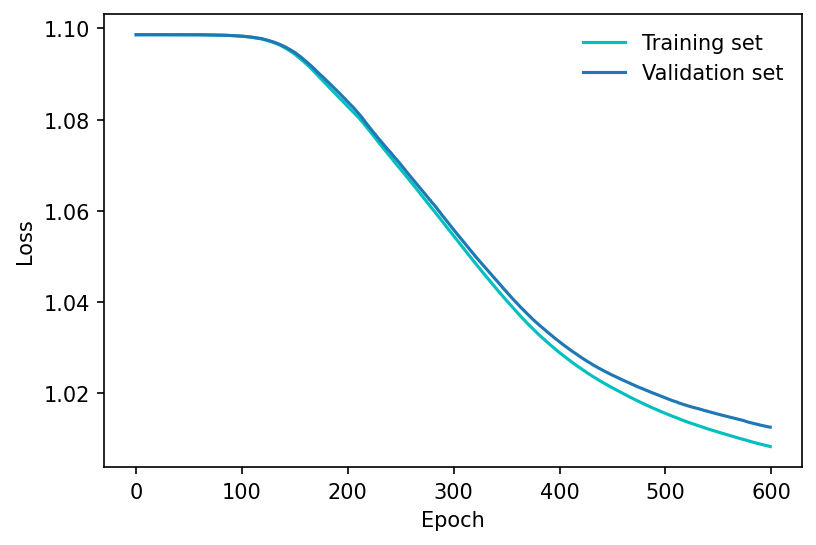

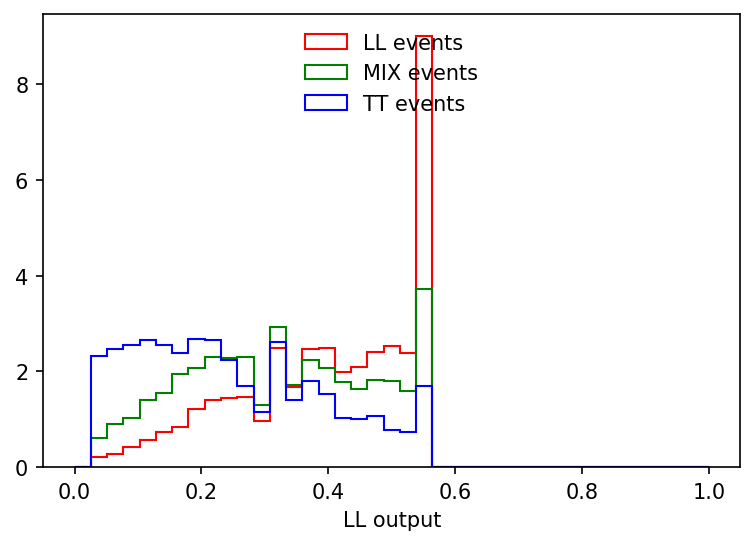

[I 2023-04-19 13:18:44,565] Trial 15 finished with value: 0.4777747753833682 and parameters: {'learning_rate': 0.0002549806259704444, 'n_layers': 8, 'N_NODES': 33}. Best is trial 4 with value: 0.5078362494089036.
100%|██████████| 600/600 [00:24<00:00, 24.97it/s]


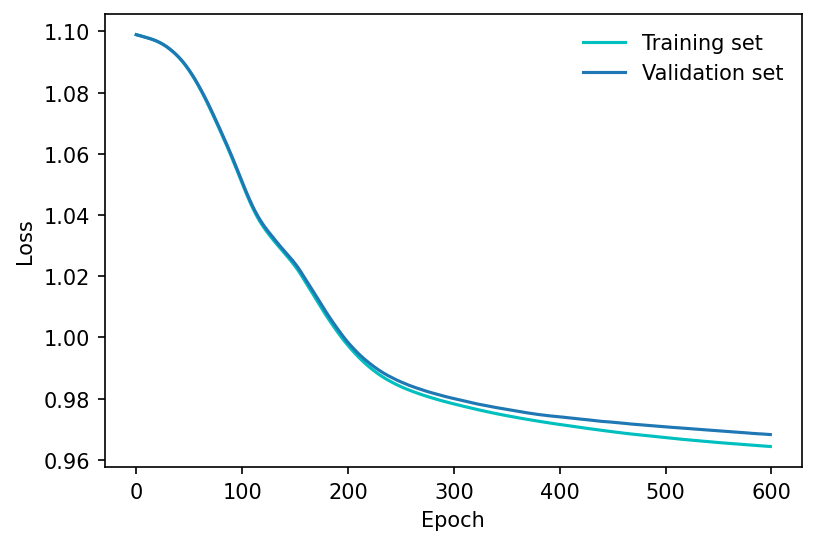

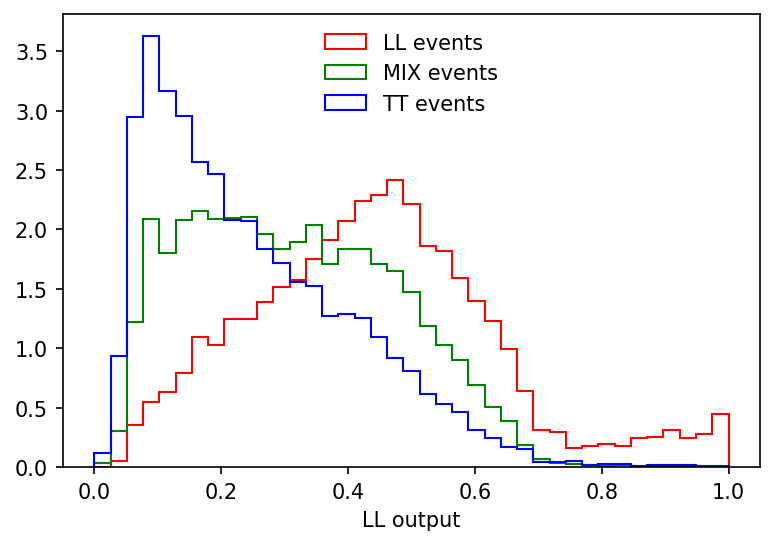

[I 2023-04-19 13:19:09,071] Trial 16 finished with value: 0.5206377085725866 and parameters: {'learning_rate': 0.0004984989600137707, 'n_layers': 10, 'N_NODES': 9}. Best is trial 16 with value: 0.5206377085725866.
100%|██████████| 600/600 [00:27<00:00, 21.49it/s]


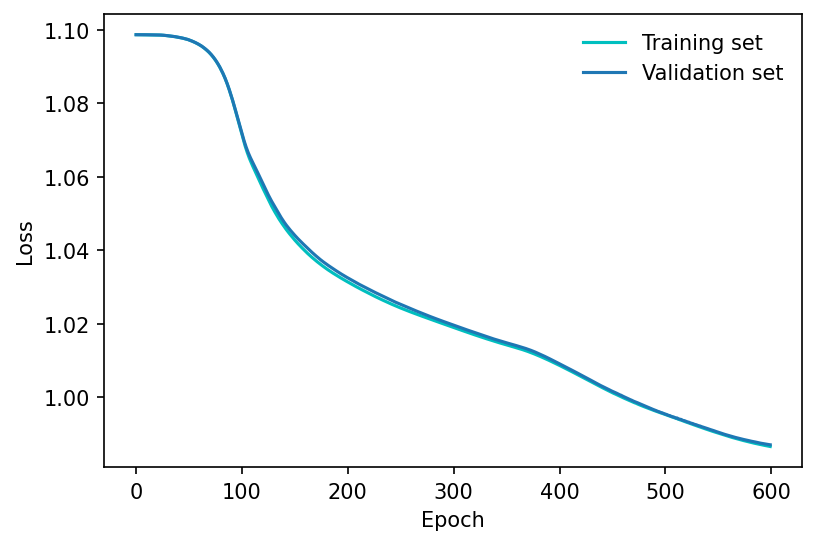

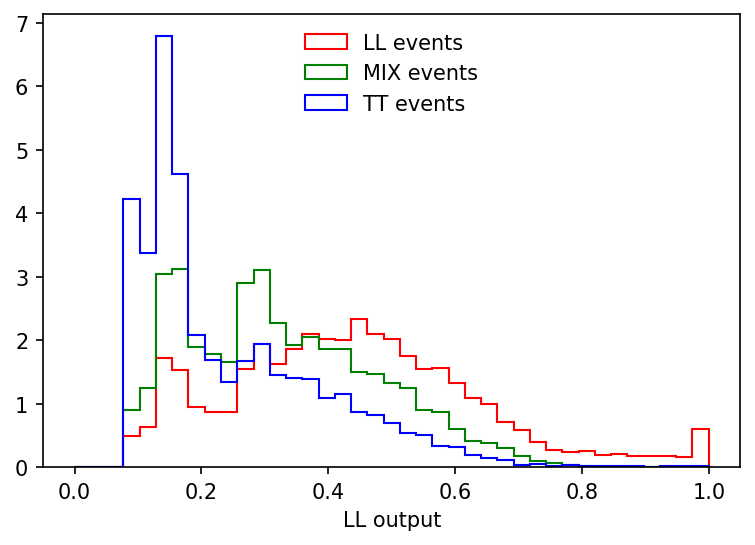

[I 2023-04-19 13:19:37,479] Trial 17 finished with value: 0.5100993041950956 and parameters: {'learning_rate': 0.0008278591039746682, 'n_layers': 6, 'N_NODES': 14}. Best is trial 16 with value: 0.5206377085725866.
100%|██████████| 600/600 [00:31<00:00, 18.90it/s]


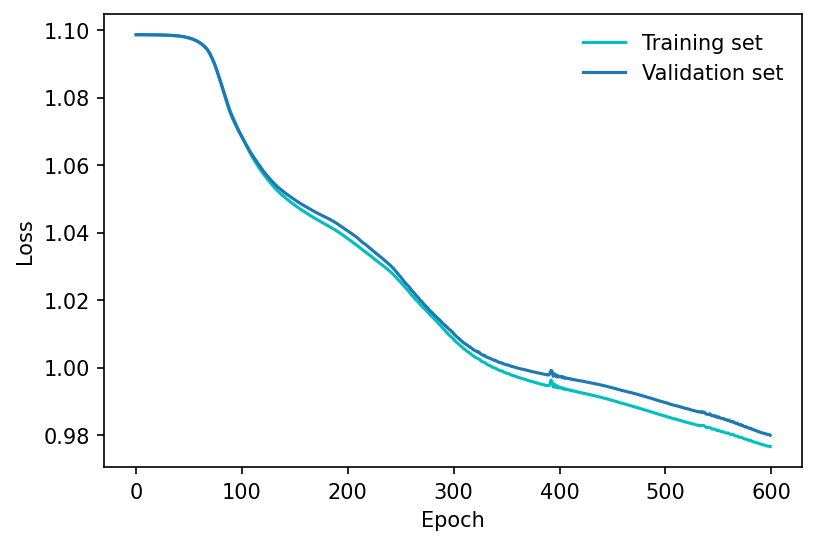

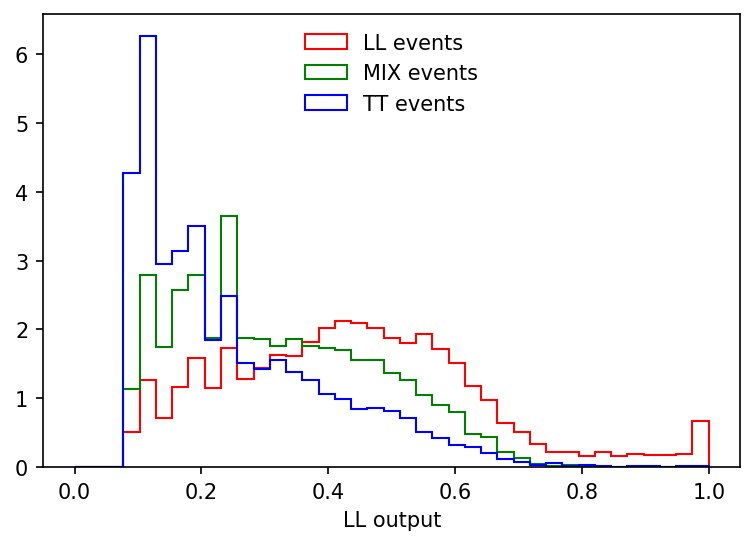

[I 2023-04-19 13:20:09,769] Trial 18 finished with value: 0.5107072890630278 and parameters: {'learning_rate': 0.000855862033089792, 'n_layers': 6, 'N_NODES': 18}. Best is trial 16 with value: 0.5206377085725866.
100%|██████████| 600/600 [00:28<00:00, 21.06it/s]


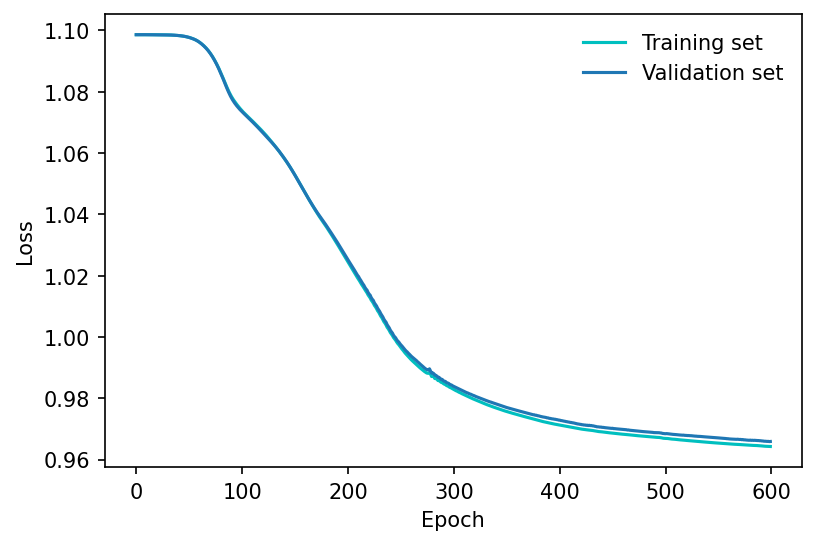

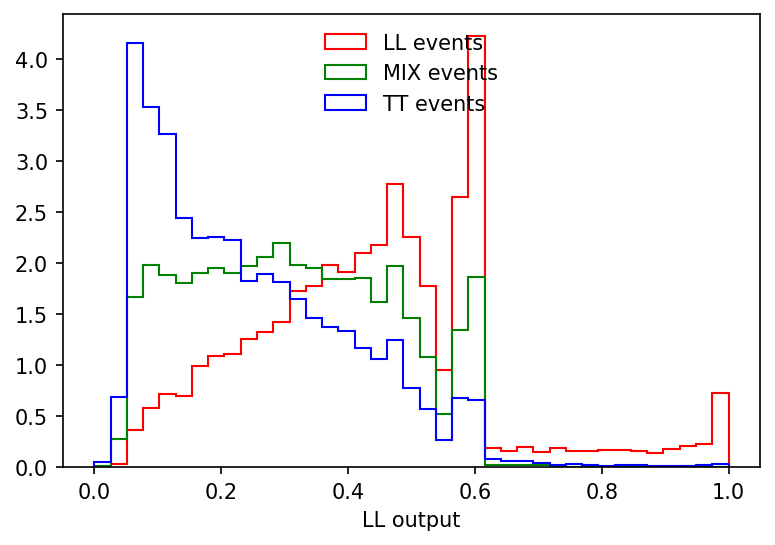

[I 2023-04-19 13:20:38,789] Trial 19 finished with value: 0.5229007633587787 and parameters: {'learning_rate': 0.0009958918596516665, 'n_layers': 6, 'N_NODES': 15}. Best is trial 19 with value: 0.5229007633587787.
100%|██████████| 600/600 [01:14<00:00,  8.08it/s]


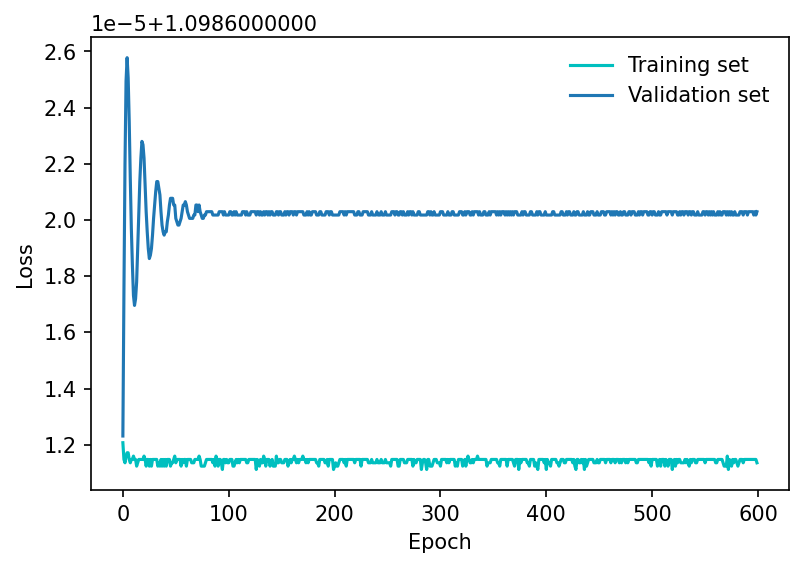

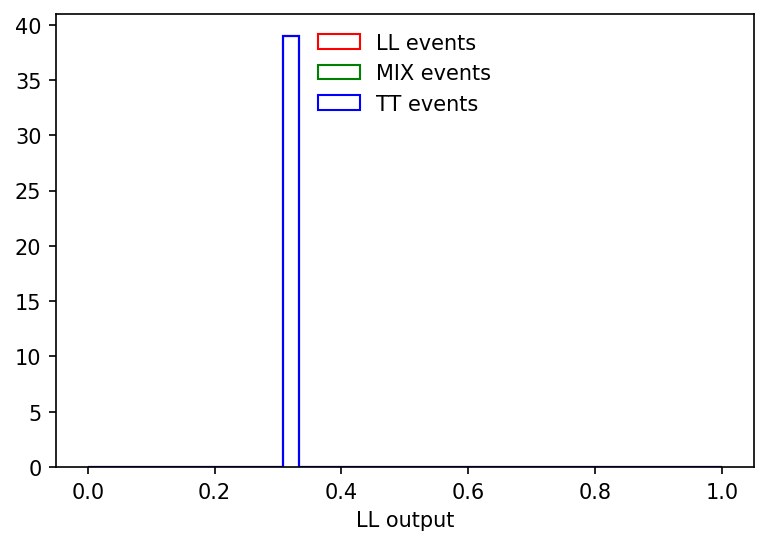

[I 2023-04-19 13:21:53,973] Trial 20 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0009741698889500902, 'n_layers': 5, 'N_NODES': 67}. Best is trial 19 with value: 0.5229007633587787.
100%|██████████| 600/600 [00:26<00:00, 22.93it/s]


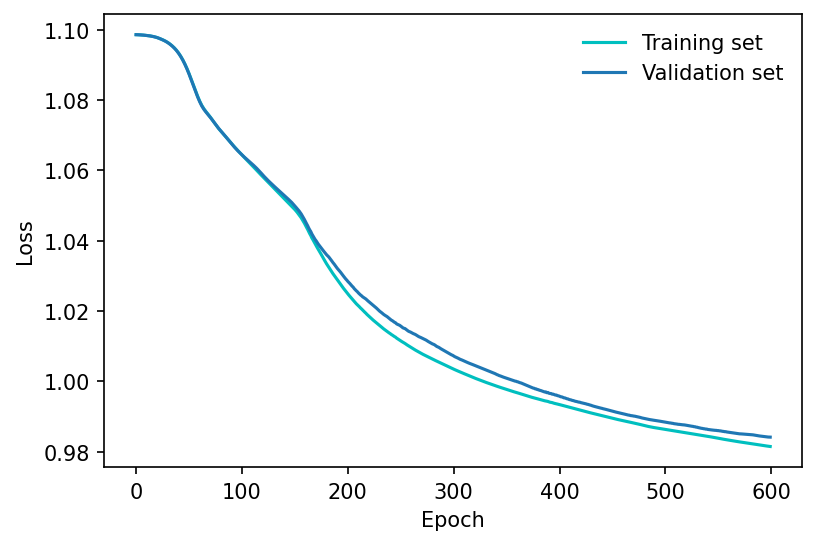

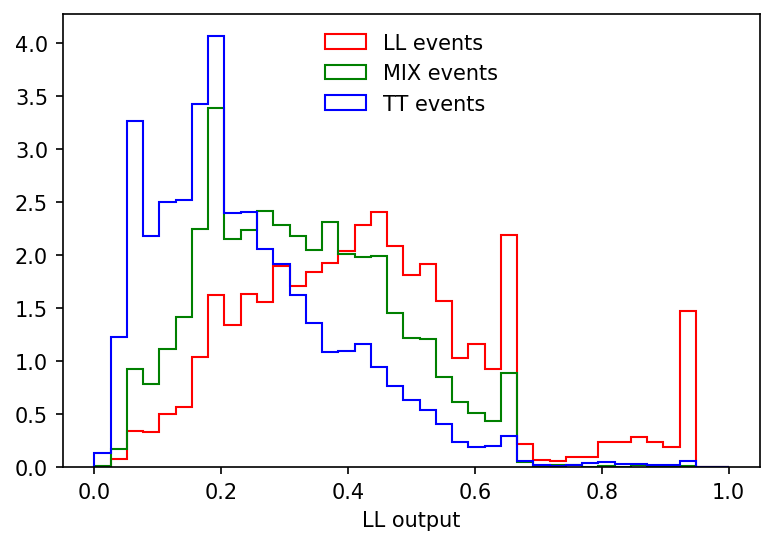

[I 2023-04-19 13:22:20,656] Trial 21 finished with value: 0.5056407484969263 and parameters: {'learning_rate': 0.0008689275865165584, 'n_layers': 6, 'N_NODES': 13}. Best is trial 19 with value: 0.5229007633587787.
100%|██████████| 600/600 [00:40<00:00, 14.86it/s]


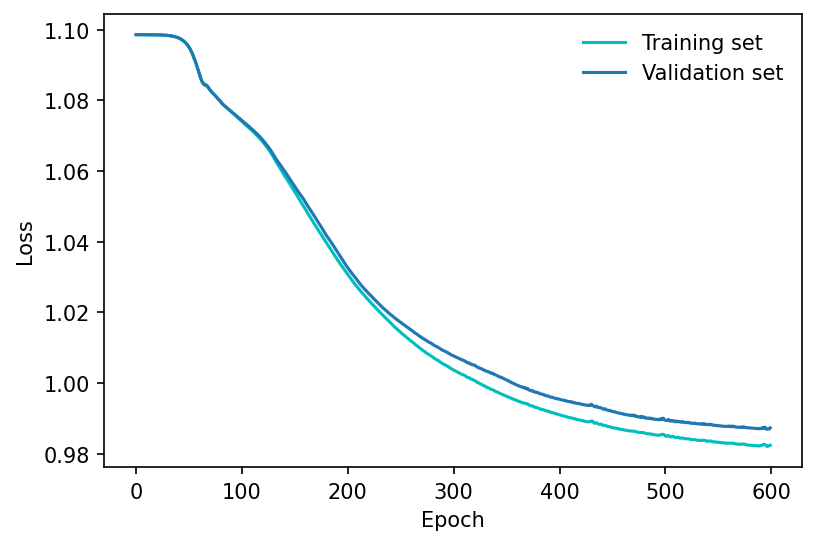

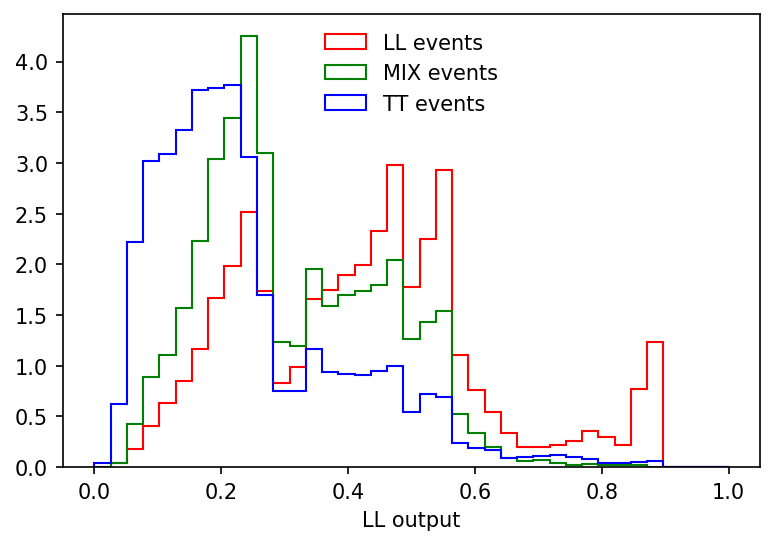

[I 2023-04-19 13:23:01,670] Trial 22 finished with value: 0.5067216104843613 and parameters: {'learning_rate': 0.0009960065468821958, 'n_layers': 7, 'N_NODES': 24}. Best is trial 19 with value: 0.5229007633587787.
100%|██████████| 600/600 [00:24<00:00, 24.42it/s]


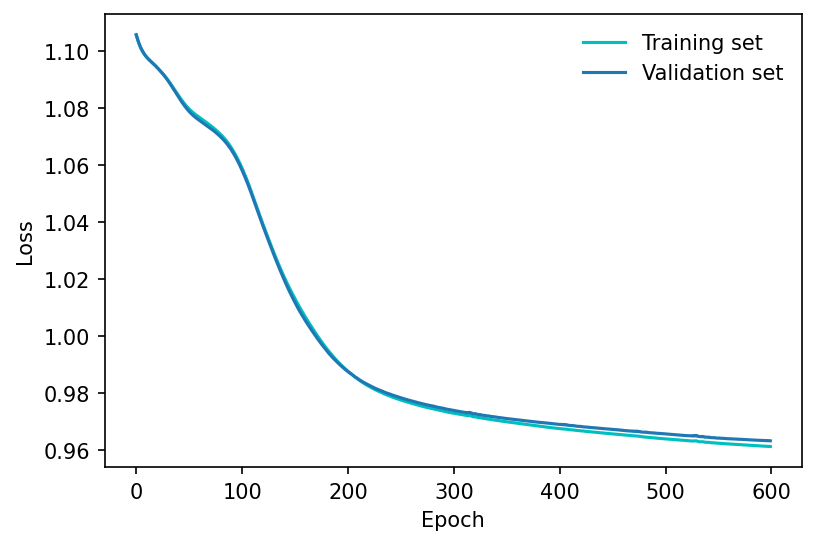

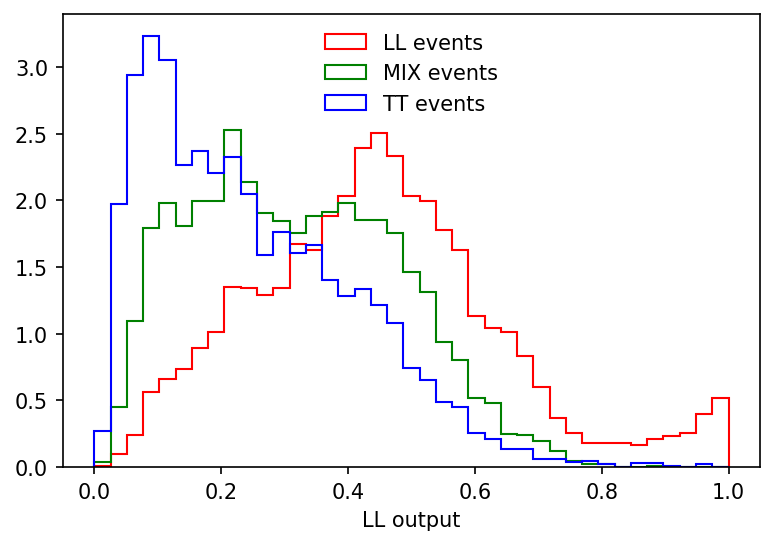

[I 2023-04-19 13:23:26,737] Trial 23 finished with value: 0.5210768087549821 and parameters: {'learning_rate': 0.0007992211314157583, 'n_layers': 8, 'N_NODES': 11}. Best is trial 19 with value: 0.5229007633587787.
100%|██████████| 600/600 [00:25<00:00, 23.97it/s]


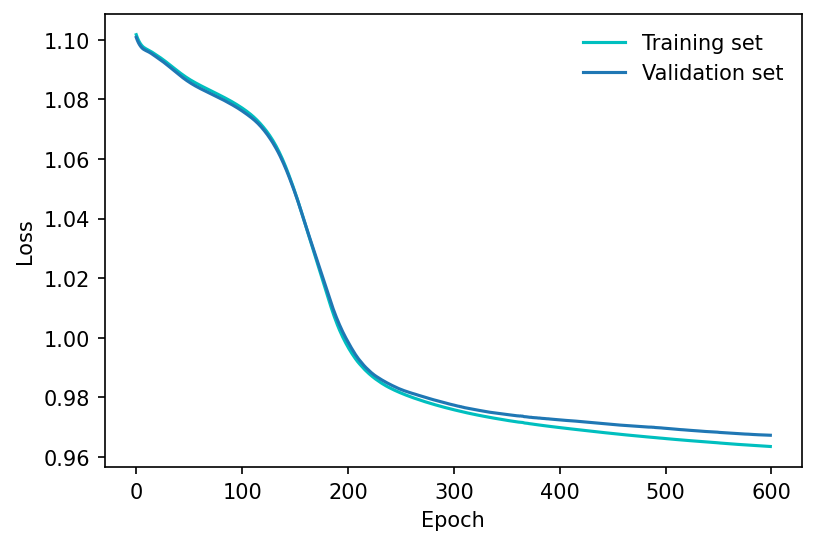

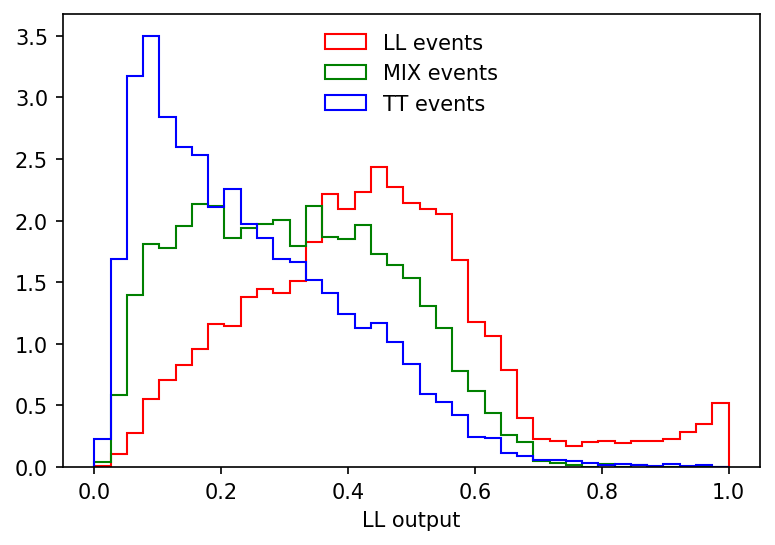

[I 2023-04-19 13:23:52,281] Trial 24 finished with value: 0.5194217388367223 and parameters: {'learning_rate': 0.0007806346263655557, 'n_layers': 9, 'N_NODES': 9}. Best is trial 19 with value: 0.5229007633587787.
100%|██████████| 600/600 [00:41<00:00, 14.30it/s]


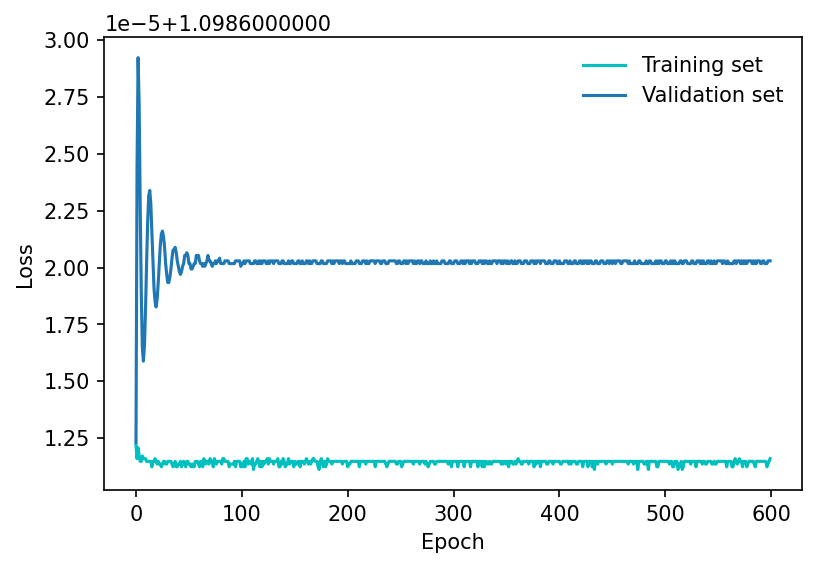

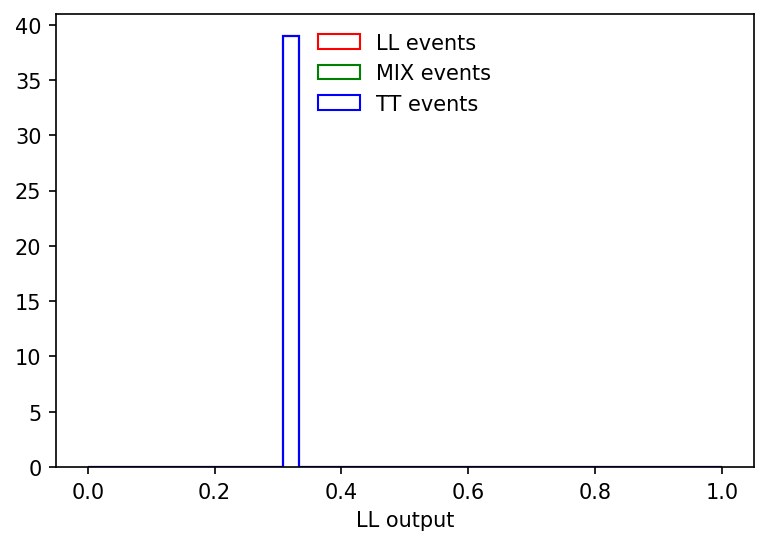

[I 2023-04-19 13:24:34,891] Trial 25 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.000916133869928054, 'n_layers': 8, 'N_NODES': 29}. Best is trial 19 with value: 0.5229007633587787.
100%|██████████| 600/600 [00:26<00:00, 22.50it/s]


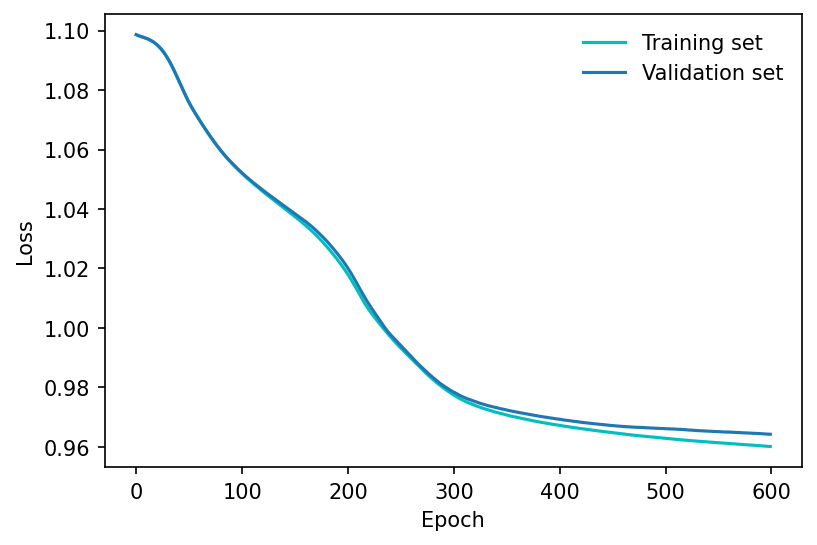

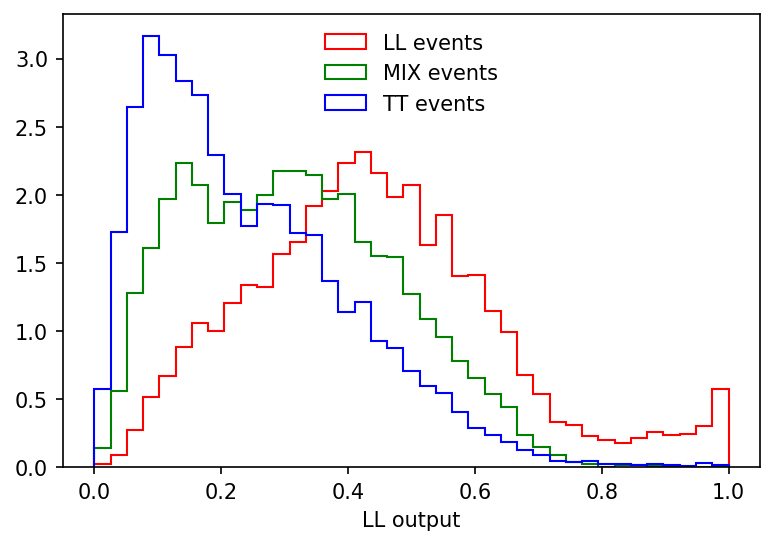

[I 2023-04-19 13:25:02,315] Trial 26 finished with value: 0.5235087482267108 and parameters: {'learning_rate': 0.0007851437153113788, 'n_layers': 9, 'N_NODES': 10}. Best is trial 26 with value: 0.5235087482267108.
100%|██████████| 600/600 [00:51<00:00, 11.57it/s]


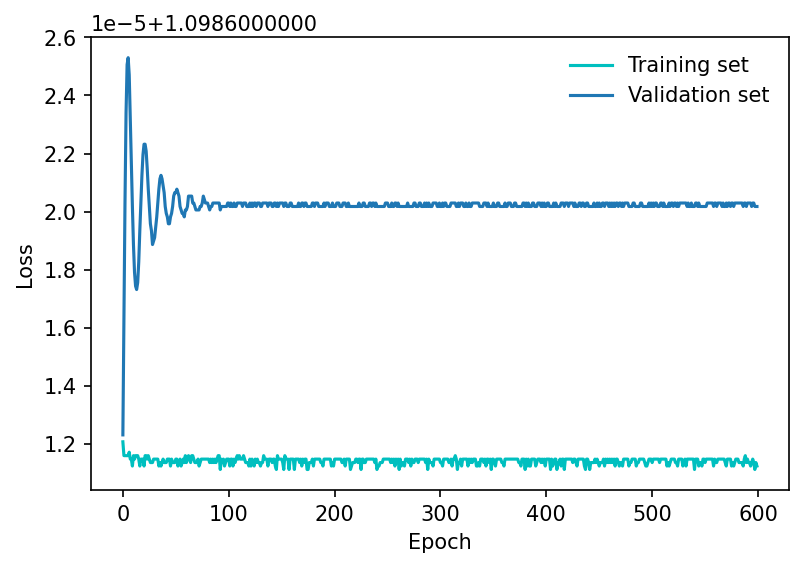

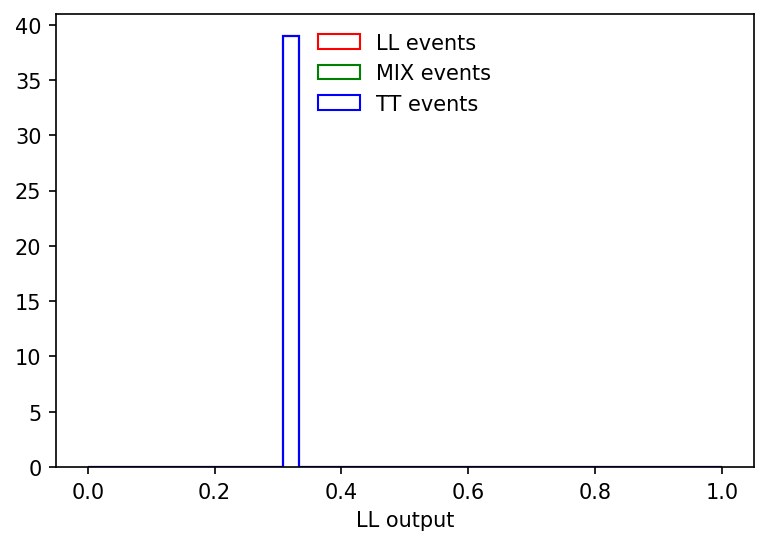

[I 2023-04-19 13:25:54,944] Trial 27 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0008004323164985871, 'n_layers': 8, 'N_NODES': 42}. Best is trial 26 with value: 0.5235087482267108.
100%|██████████| 600/600 [00:22<00:00, 27.01it/s]


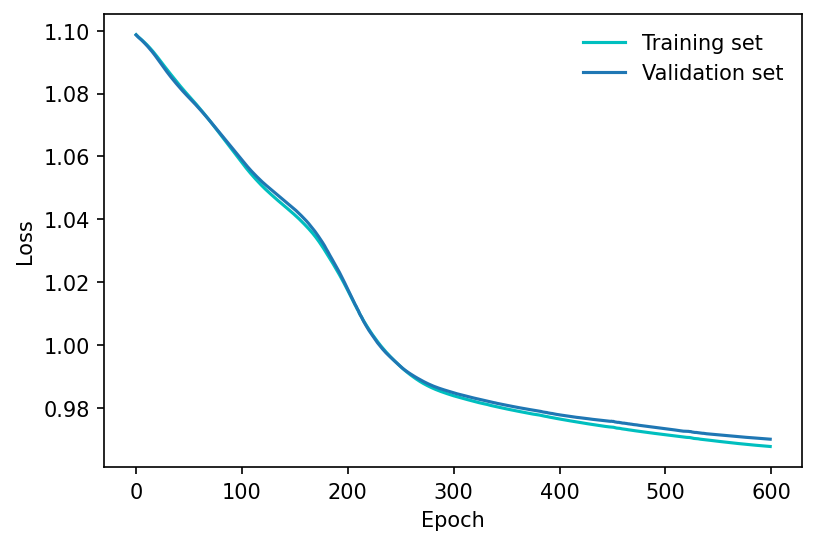

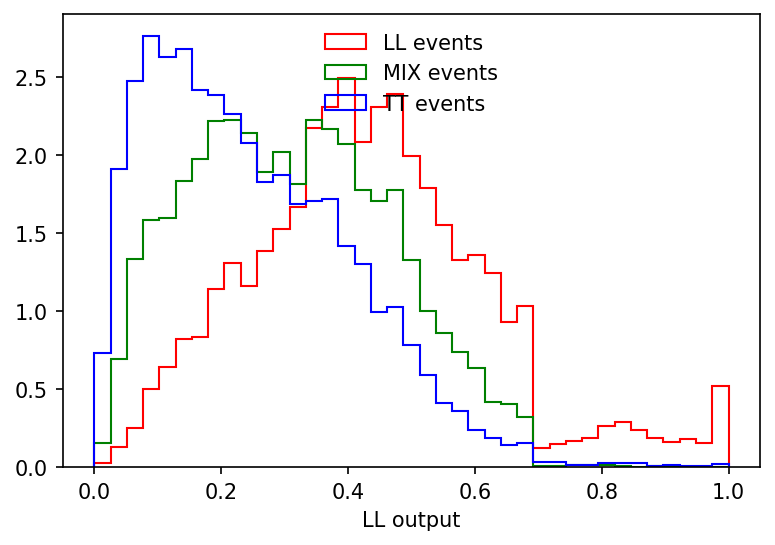

[I 2023-04-19 13:26:17,607] Trial 28 finished with value: 0.5161791528744174 and parameters: {'learning_rate': 0.0008997843553819507, 'n_layers': 7, 'N_NODES': 8}. Best is trial 26 with value: 0.5235087482267108.
100%|██████████| 600/600 [01:03<00:00,  9.42it/s]


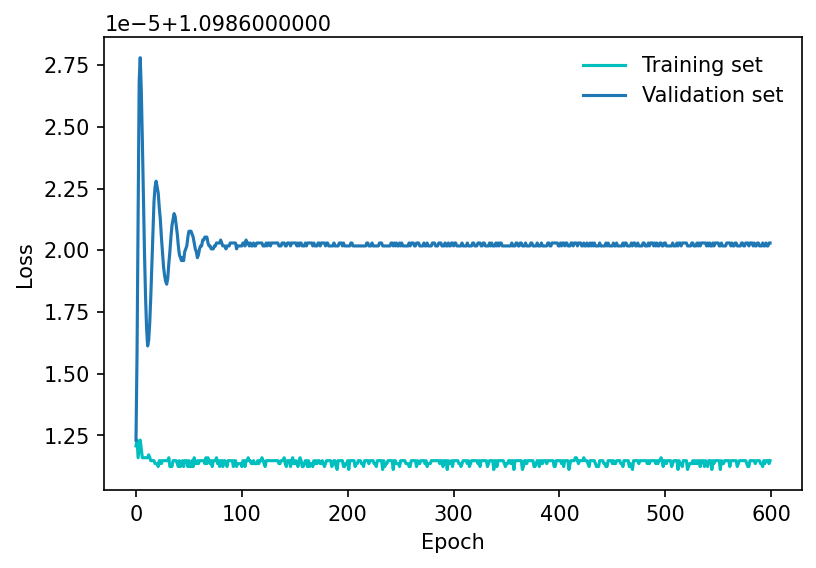

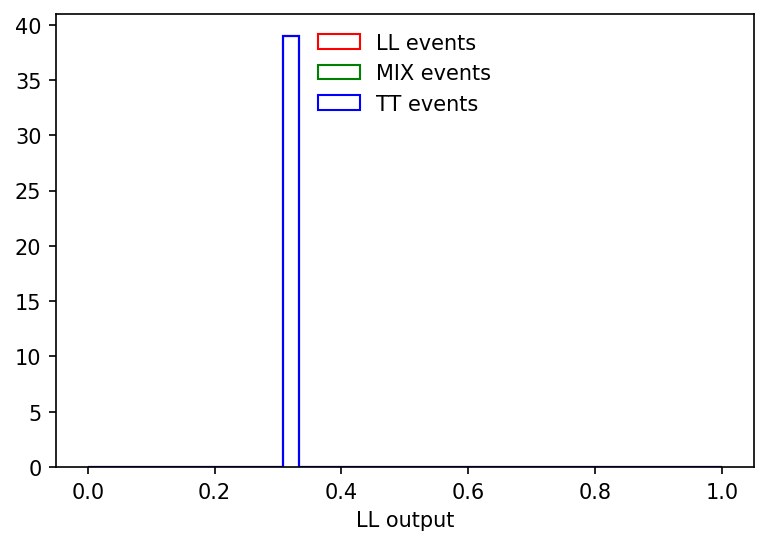

[I 2023-04-19 13:27:22,111] Trial 29 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0009309441647554065, 'n_layers': 9, 'N_NODES': 52}. Best is trial 26 with value: 0.5235087482267108.
100%|██████████| 600/600 [00:34<00:00, 17.38it/s]


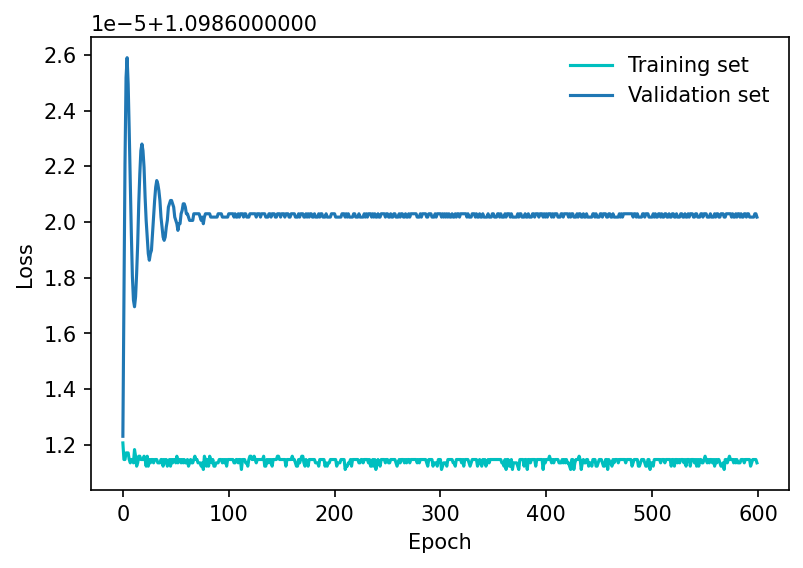

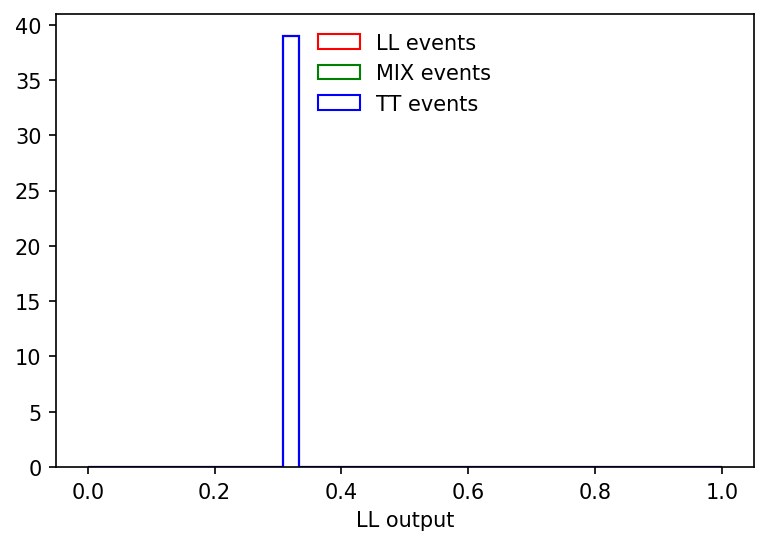

[I 2023-04-19 13:27:57,205] Trial 30 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.000995953498453085, 'n_layers': 5, 'N_NODES': 20}. Best is trial 26 with value: 0.5235087482267108.
100%|██████████| 600/600 [00:24<00:00, 24.62it/s]


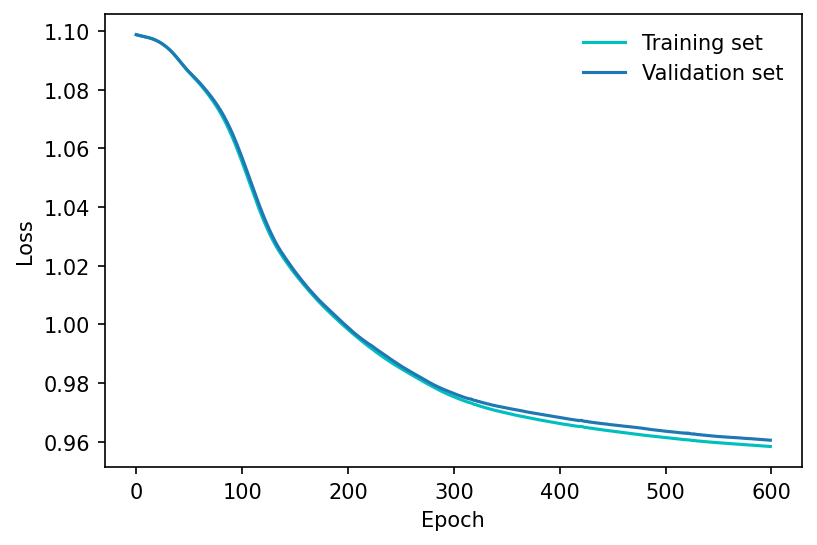

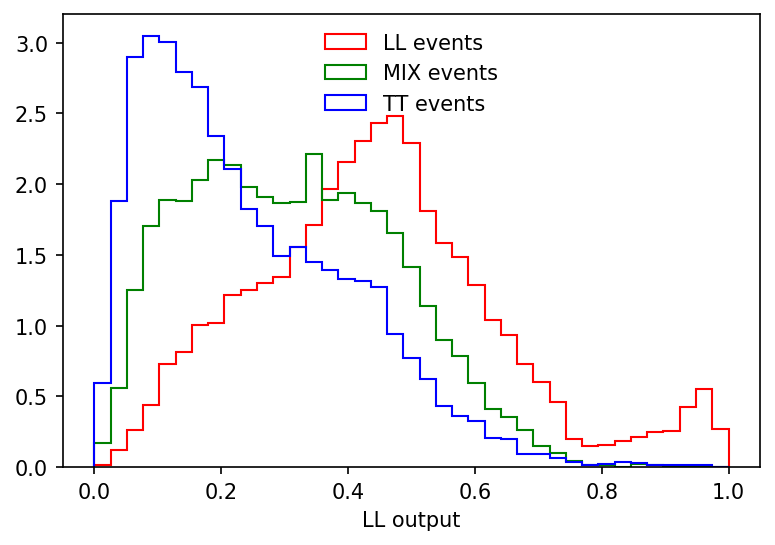

[I 2023-04-19 13:28:22,055] Trial 31 finished with value: 0.525602918327366 and parameters: {'learning_rate': 0.0007740109484115858, 'n_layers': 10, 'N_NODES': 9}. Best is trial 31 with value: 0.525602918327366.
100%|██████████| 600/600 [00:21<00:00, 27.64it/s]


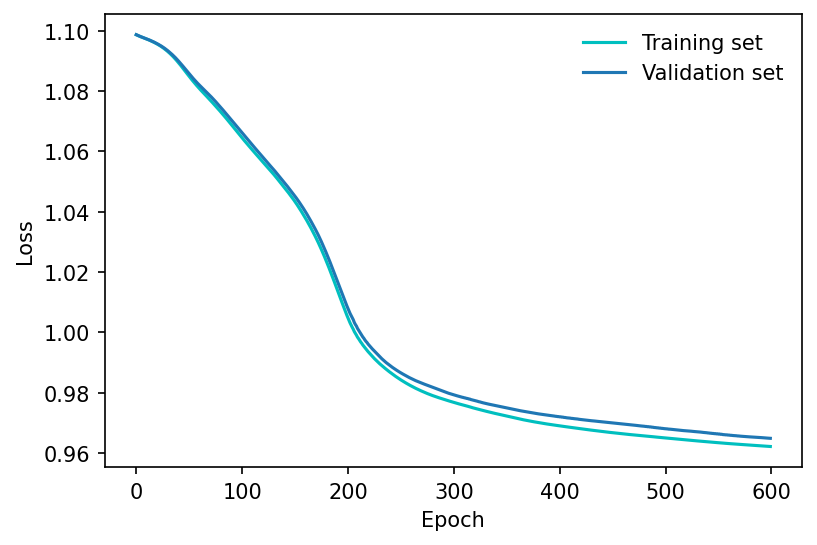

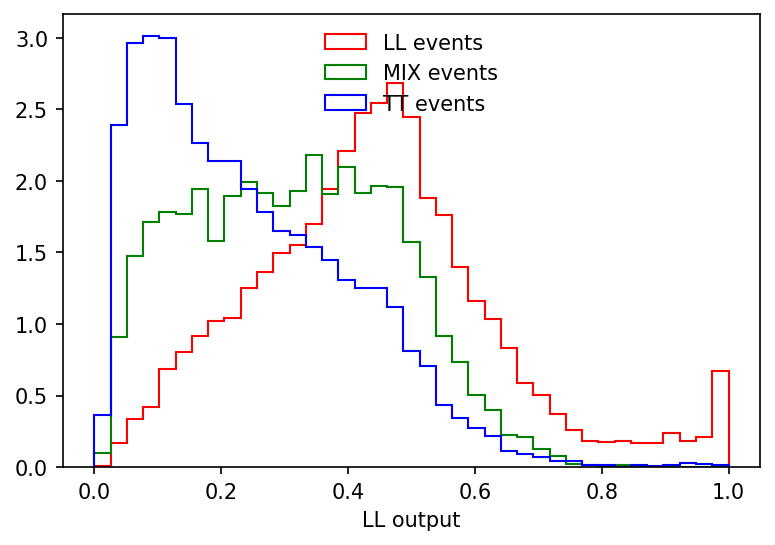

[I 2023-04-19 13:28:44,228] Trial 32 finished with value: 0.5210768087549821 and parameters: {'learning_rate': 0.000767984512985406, 'n_layers': 9, 'N_NODES': 7}. Best is trial 31 with value: 0.525602918327366.
100%|██████████| 600/600 [00:39<00:00, 15.02it/s]


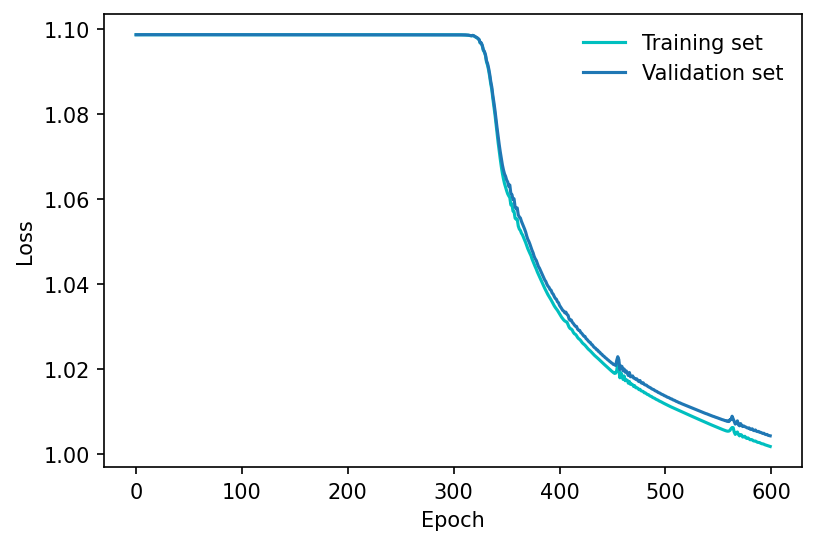

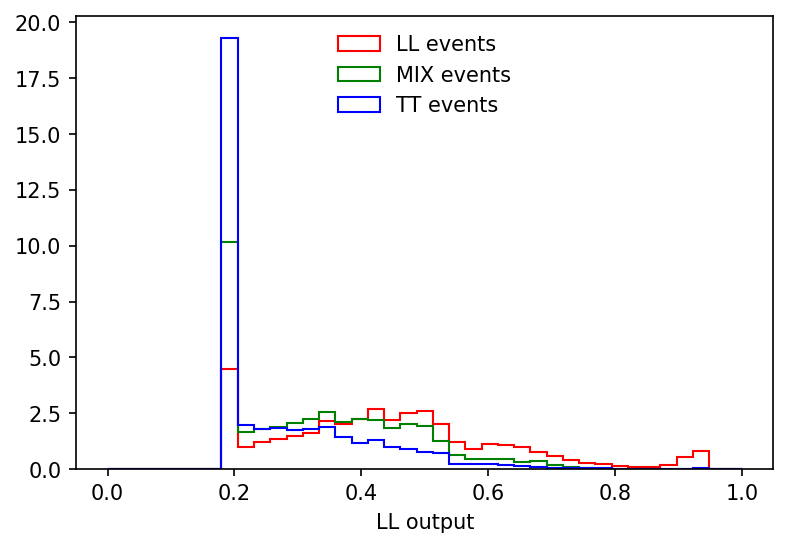

[I 2023-04-19 13:29:24,990] Trial 33 finished with value: 0.4921975275282037 and parameters: {'learning_rate': 0.0008379477198063314, 'n_layers': 8, 'N_NODES': 28}. Best is trial 31 with value: 0.525602918327366.
100%|██████████| 600/600 [00:28<00:00, 20.79it/s]


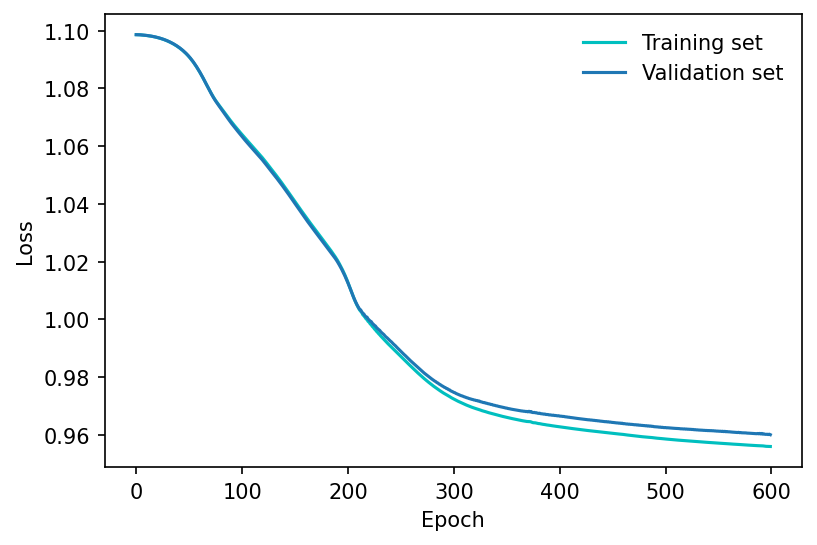

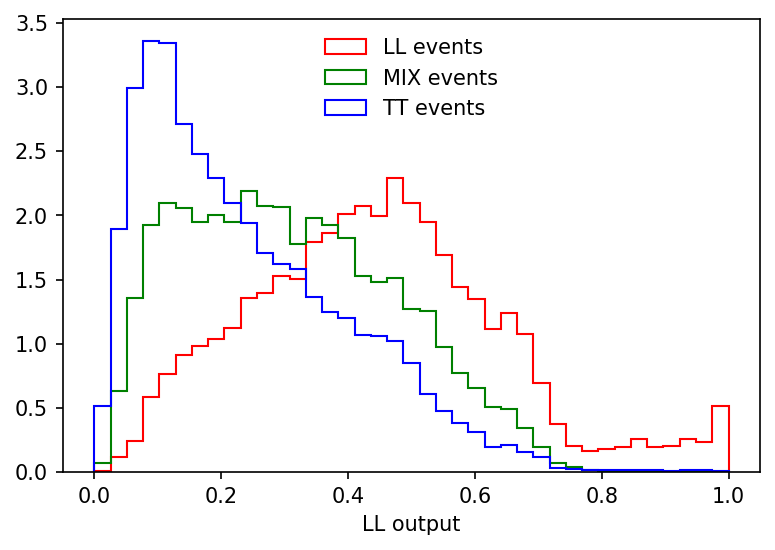

[I 2023-04-19 13:29:54,396] Trial 34 finished with value: 0.5282375194217388 and parameters: {'learning_rate': 0.0007336314656027509, 'n_layers': 10, 'N_NODES': 13}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:37<00:00, 15.82it/s]


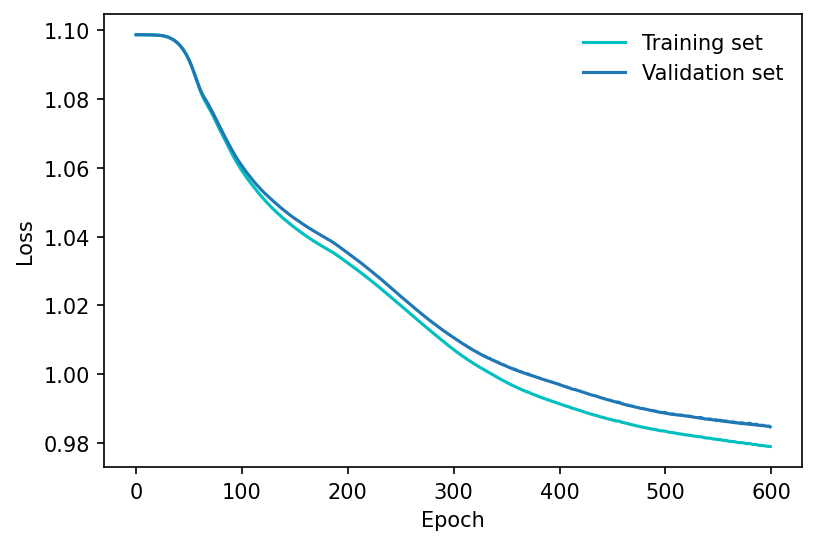

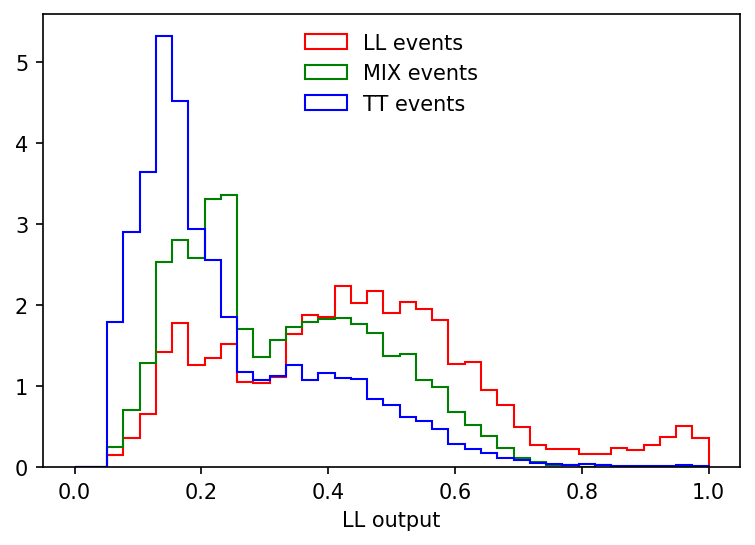

[I 2023-04-19 13:30:32,919] Trial 35 finished with value: 0.5111126123083158 and parameters: {'learning_rate': 0.0007267729015363522, 'n_layers': 10, 'N_NODES': 21}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:49<00:00, 12.15it/s]


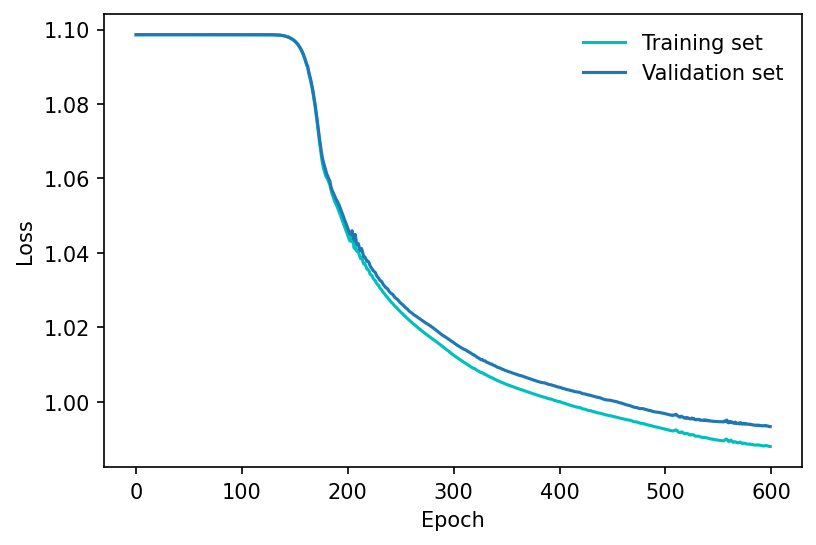

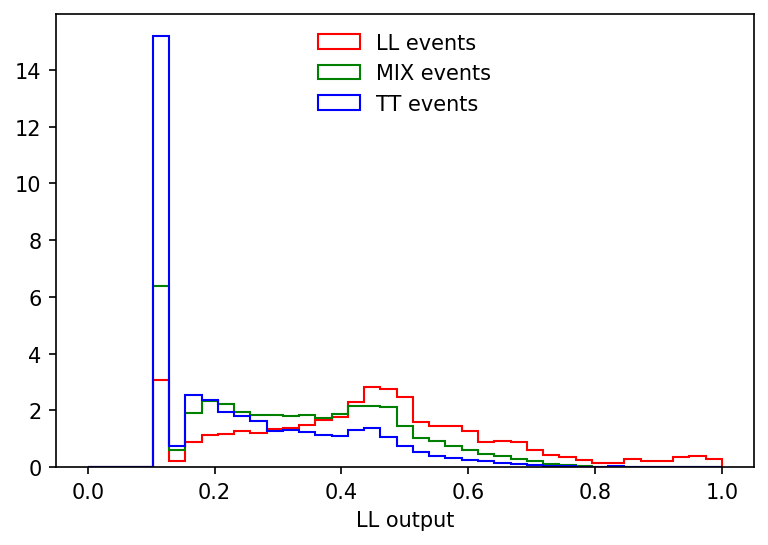

[I 2023-04-19 13:31:22,960] Trial 36 finished with value: 0.4973991758427346 and parameters: {'learning_rate': 0.0006605274503848718, 'n_layers': 9, 'N_NODES': 35}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [01:28<00:00,  6.81it/s]


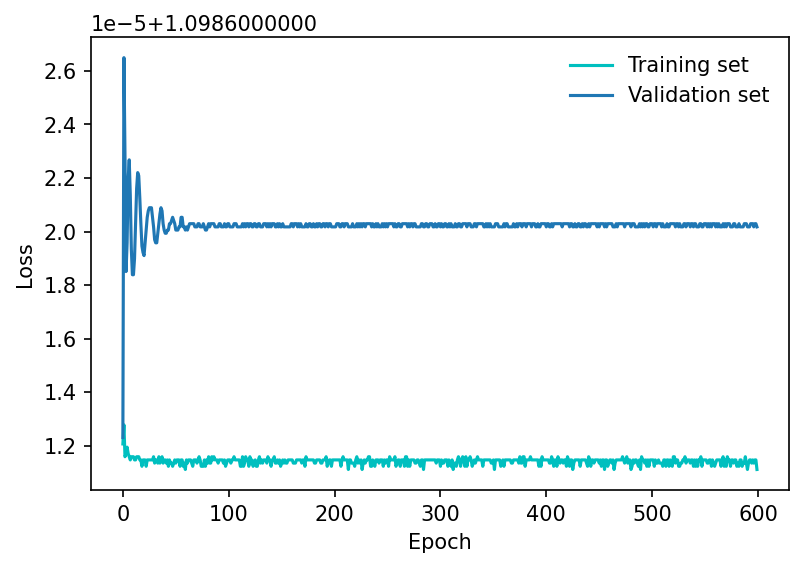

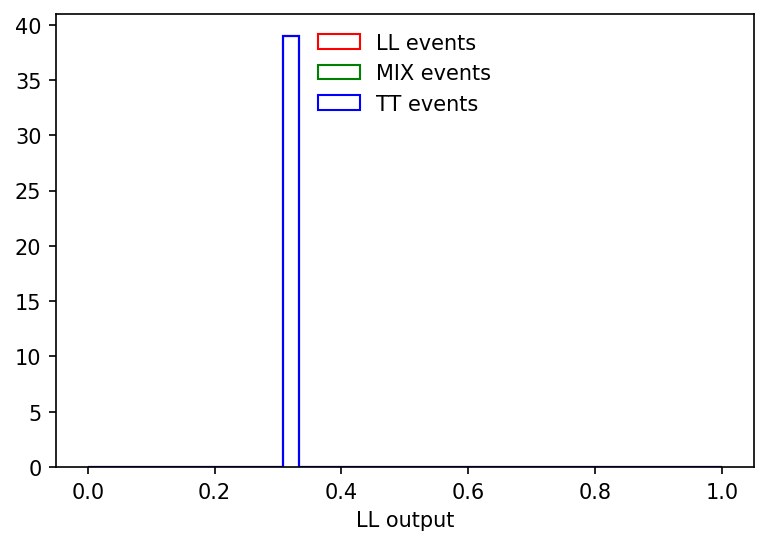

[I 2023-04-19 13:32:52,221] Trial 37 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0008982492103906933, 'n_layers': 10, 'N_NODES': 78}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:29<00:00, 20.06it/s]


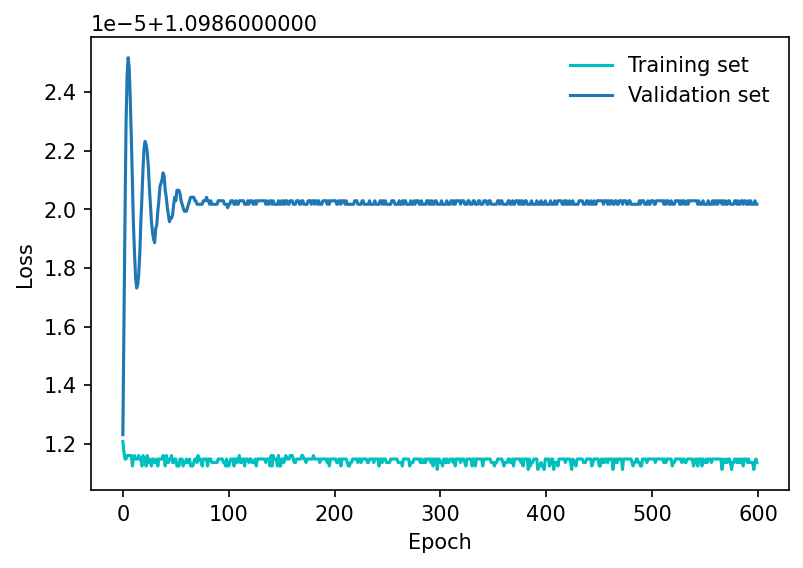

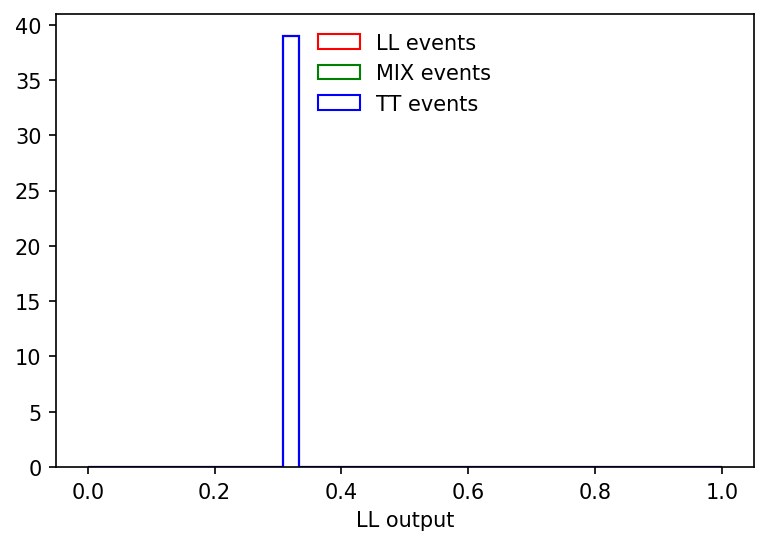

[I 2023-04-19 13:33:22,688] Trial 38 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0007525021773392505, 'n_layers': 4, 'N_NODES': 17}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:20<00:00, 29.14it/s]


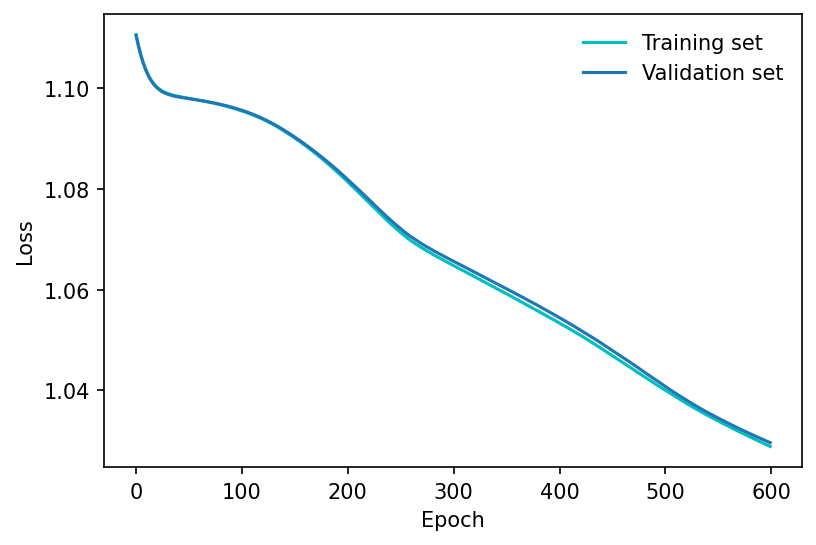

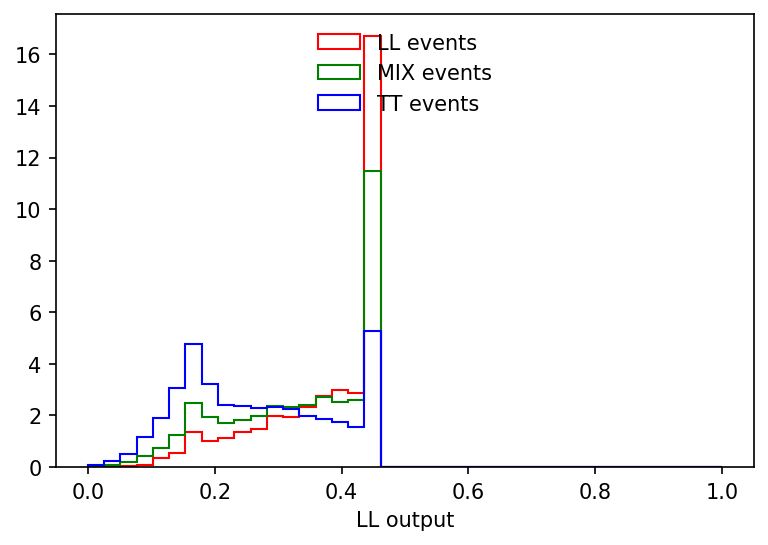

[I 2023-04-19 13:33:43,735] Trial 39 finished with value: 0.4659528473957982 and parameters: {'learning_rate': 0.0006225276265617049, 'n_layers': 3, 'N_NODES': 6}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:36<00:00, 16.43it/s]


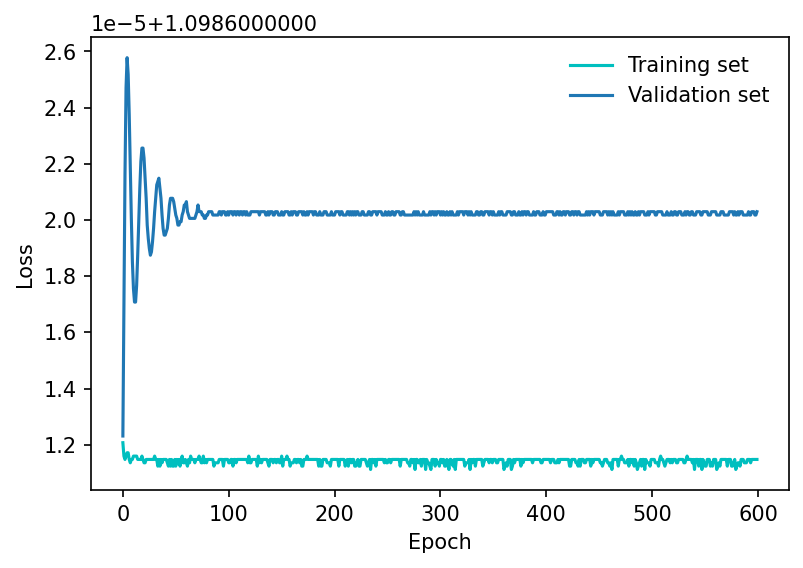

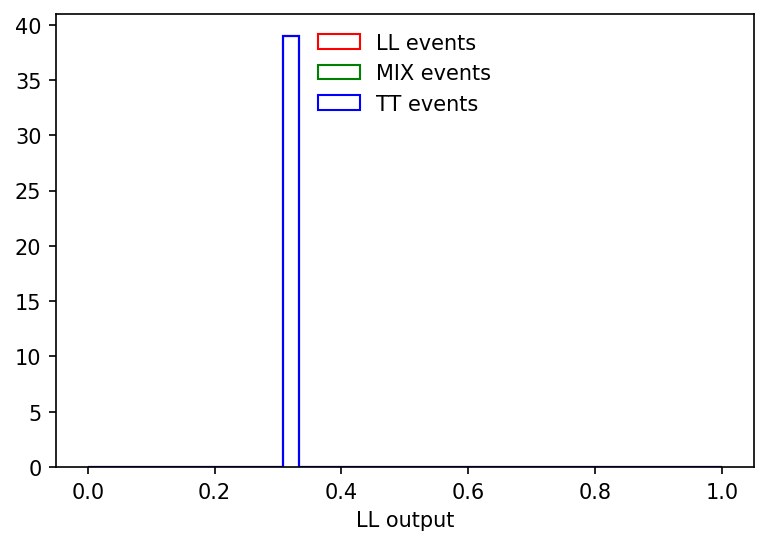

[I 2023-04-19 13:34:20,905] Trial 40 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0009450446045669753, 'n_layers': 2, 'N_NODES': 28}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:27<00:00, 22.16it/s]


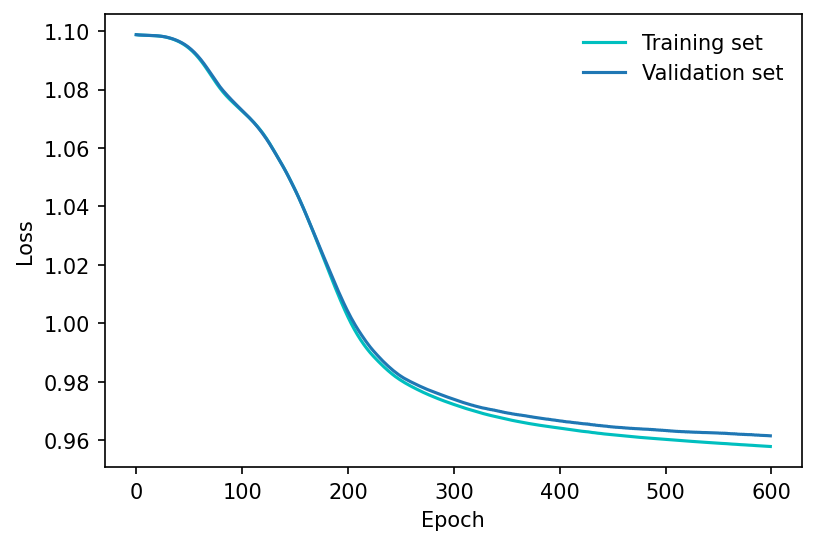

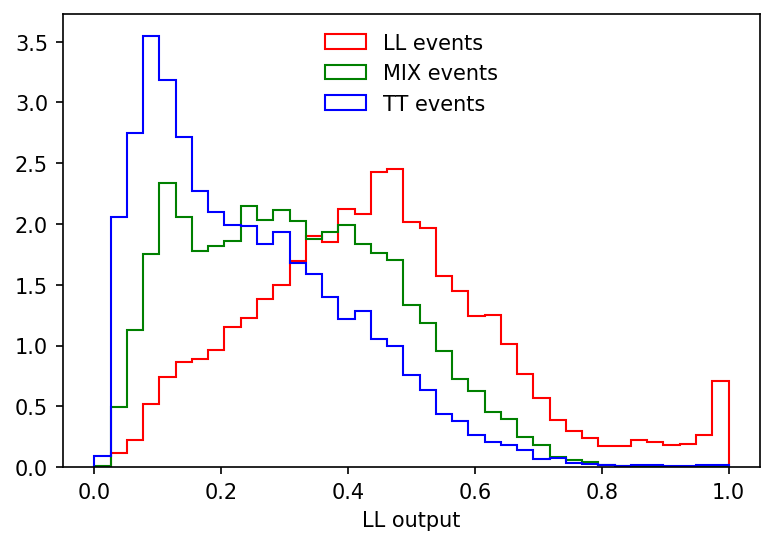

[I 2023-04-19 13:34:48,497] Trial 41 finished with value: 0.524218063905965 and parameters: {'learning_rate': 0.0006832560428158463, 'n_layers': 9, 'N_NODES': 11}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:21<00:00, 27.90it/s]


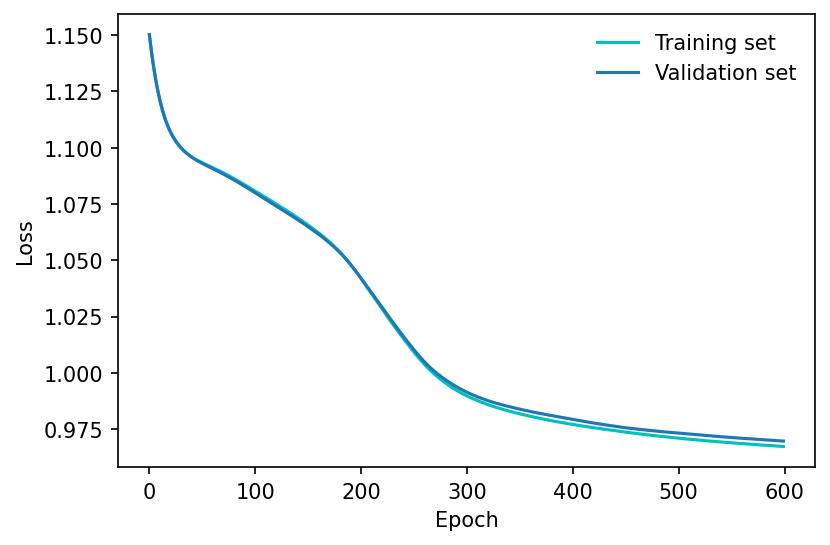

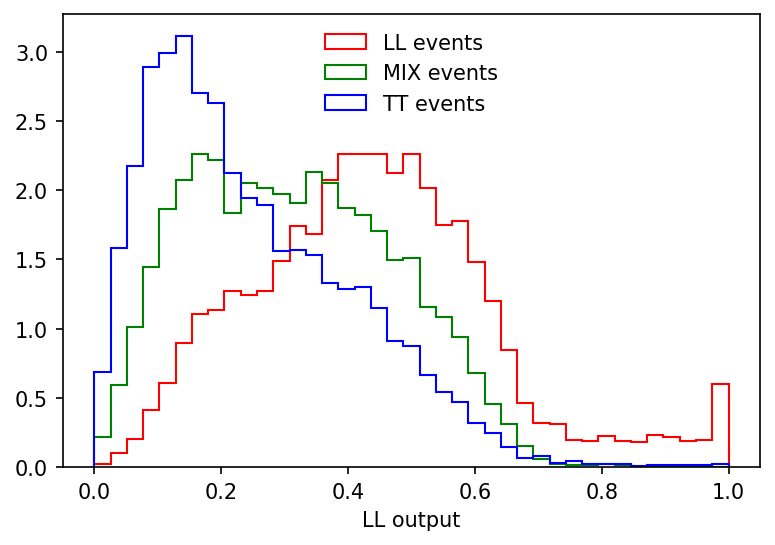

[I 2023-04-19 13:35:10,444] Trial 42 finished with value: 0.5168884685536715 and parameters: {'learning_rate': 0.000690931245701235, 'n_layers': 9, 'N_NODES': 5}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:29<00:00, 20.47it/s]


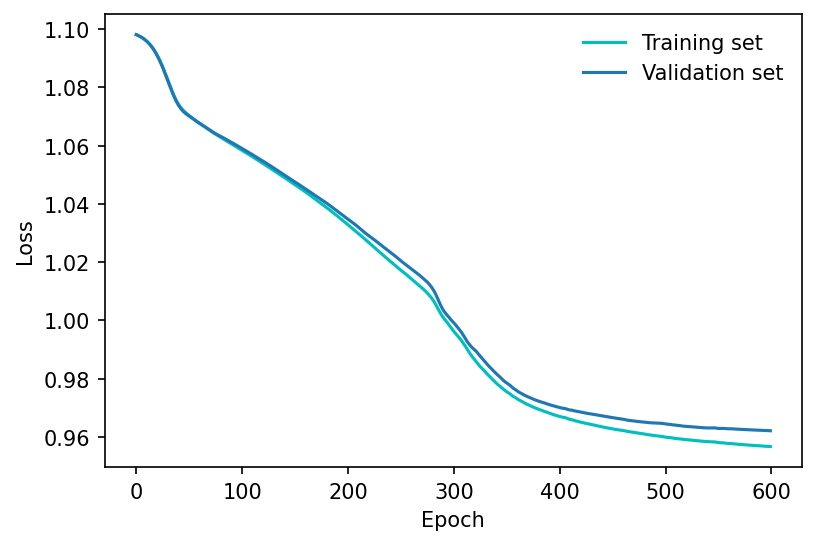

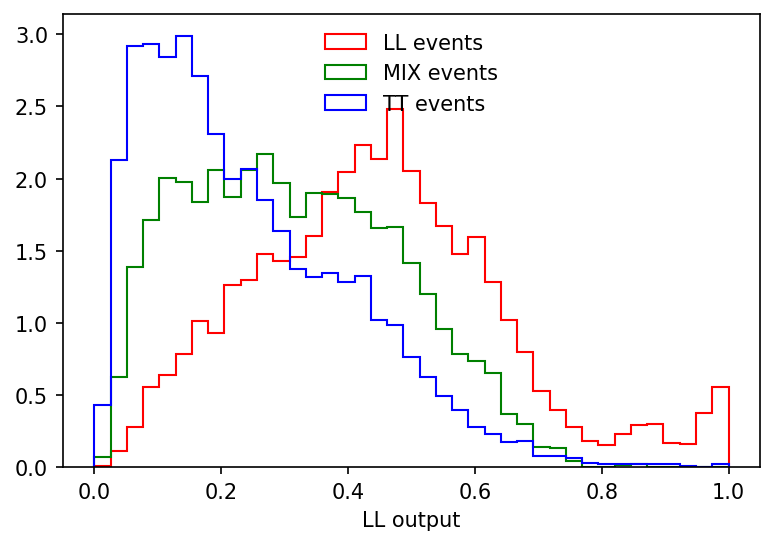

[I 2023-04-19 13:35:40,286] Trial 43 finished with value: 0.5263122340066203 and parameters: {'learning_rate': 0.0007315275215103101, 'n_layers': 10, 'N_NODES': 14}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [01:47<00:00,  5.60it/s]


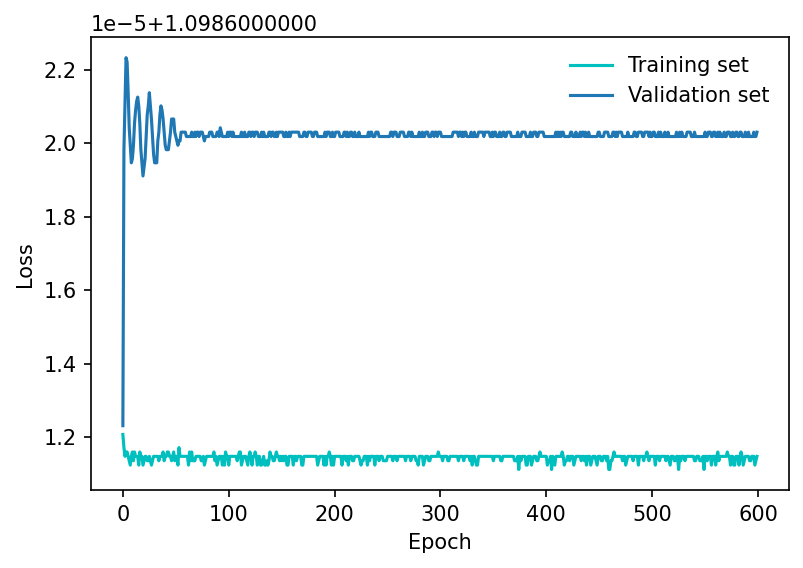

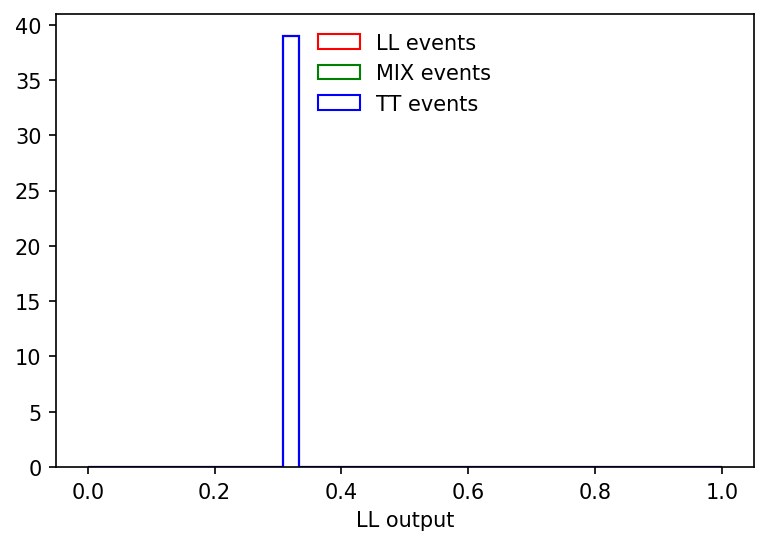

[I 2023-04-19 13:37:28,832] Trial 44 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0007351878585569528, 'n_layers': 10, 'N_NODES': 100}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:38<00:00, 15.59it/s]


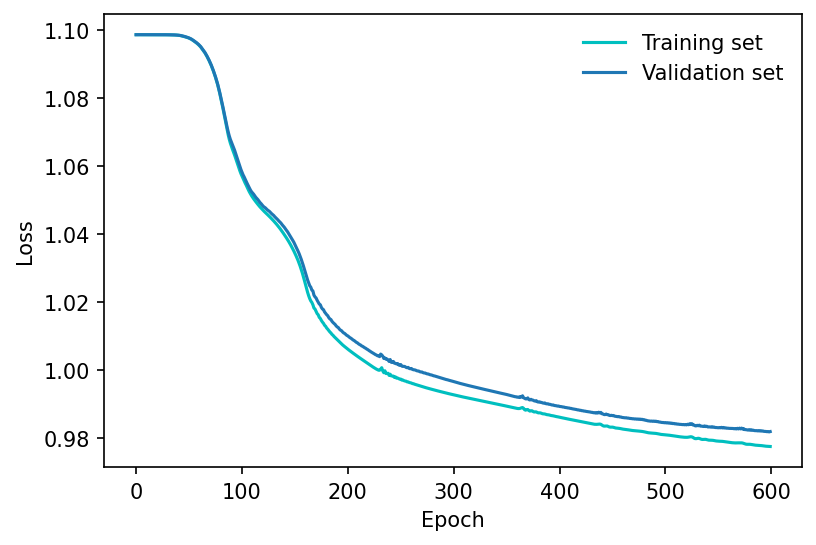

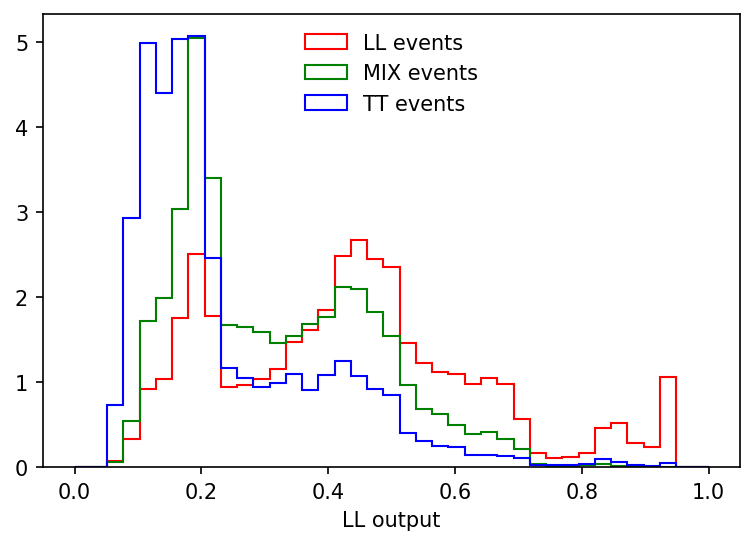

[I 2023-04-19 13:38:07,913] Trial 45 finished with value: 0.5128352361007904 and parameters: {'learning_rate': 0.0006466801405979316, 'n_layers': 10, 'N_NODES': 23}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:17<00:00, 34.49it/s]


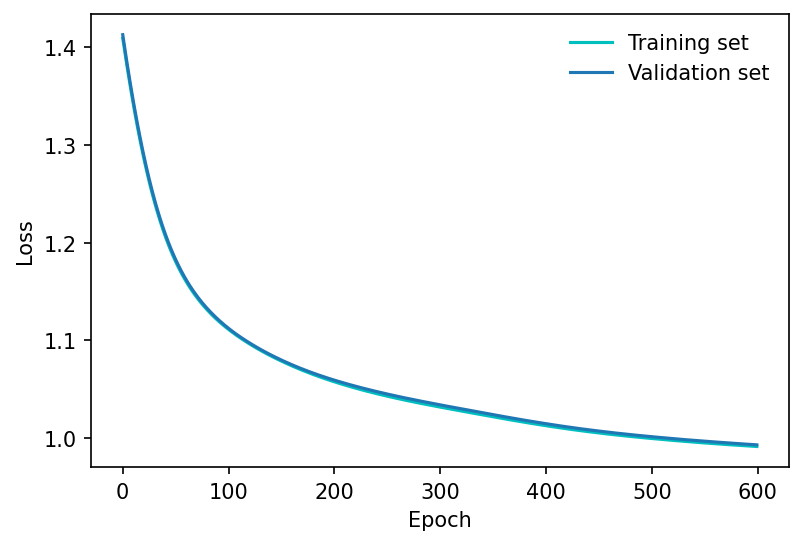

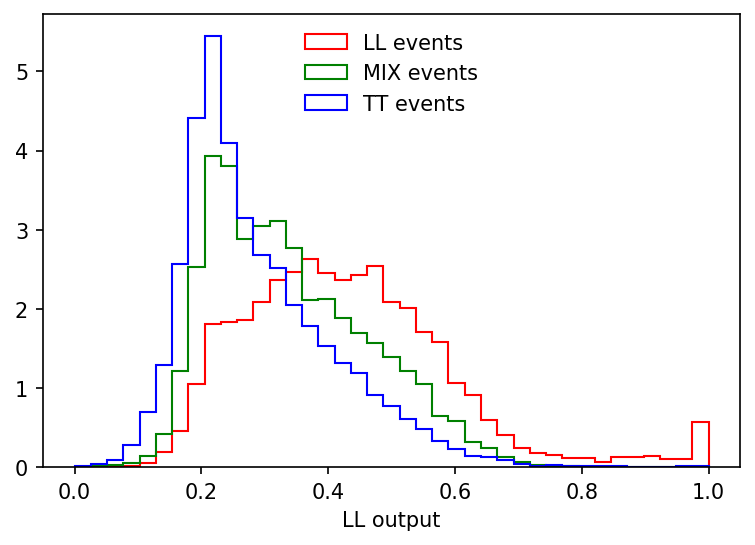

[I 2023-04-19 13:38:25,733] Trial 46 finished with value: 0.504728771195028 and parameters: {'learning_rate': 0.0007140077919315617, 'n_layers': 9, 'N_NODES': 1}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:27<00:00, 21.57it/s]


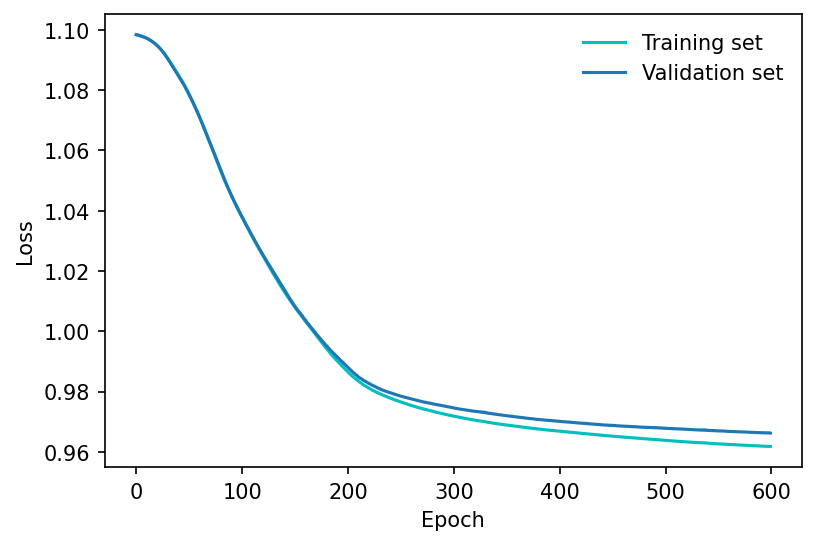

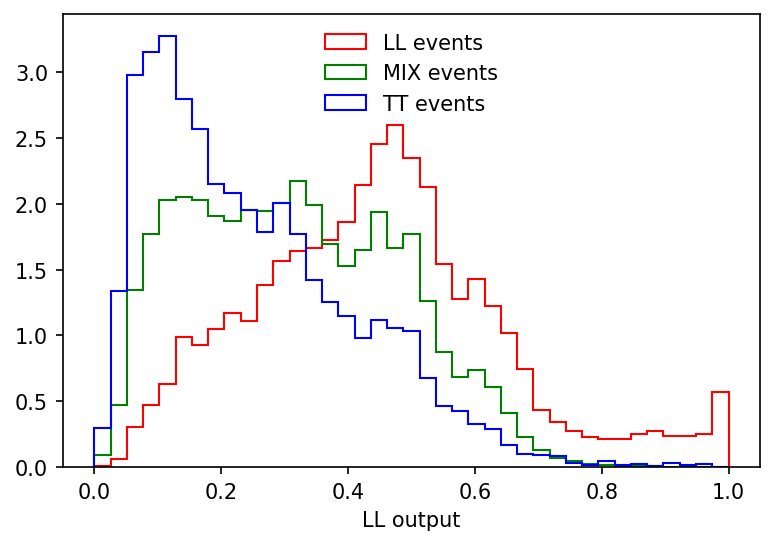

[I 2023-04-19 13:38:54,050] Trial 47 finished with value: 0.5248260487738972 and parameters: {'learning_rate': 0.0006829404830221566, 'n_layers': 10, 'N_NODES': 13}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:52<00:00, 11.46it/s]


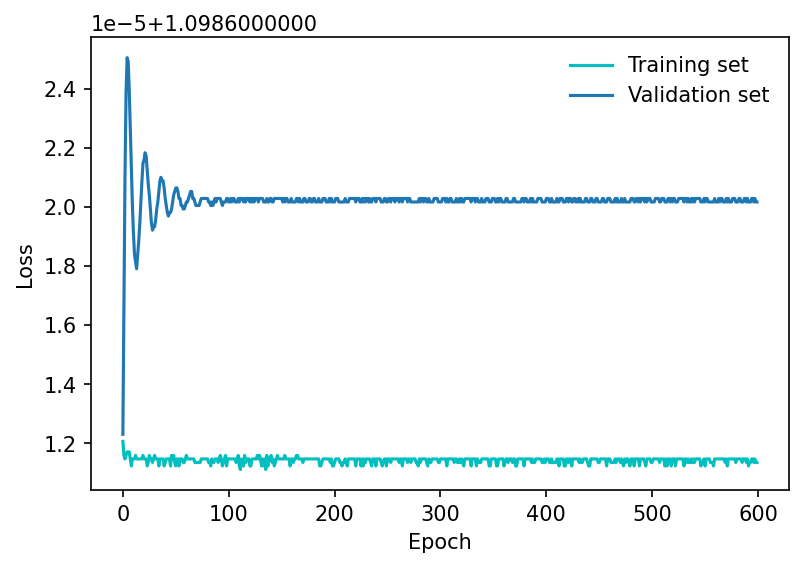

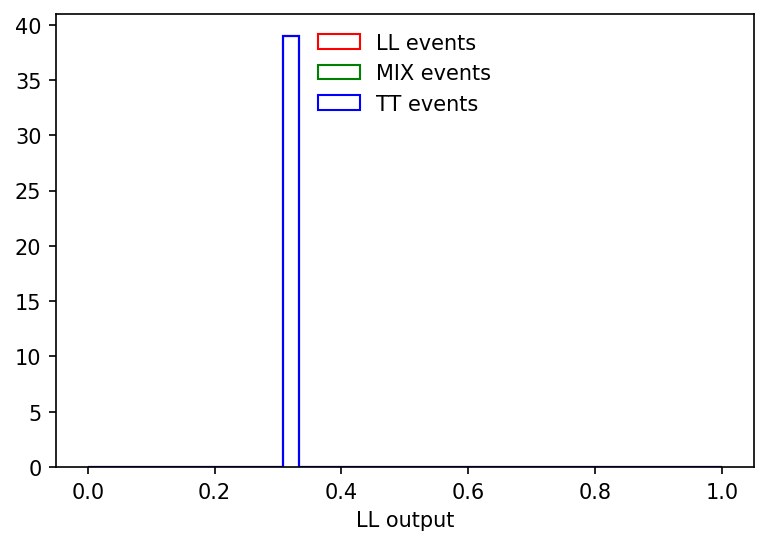

[I 2023-04-19 13:39:47,162] Trial 48 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0005852116324748546, 'n_layers': 10, 'N_NODES': 39}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:31<00:00, 19.06it/s]


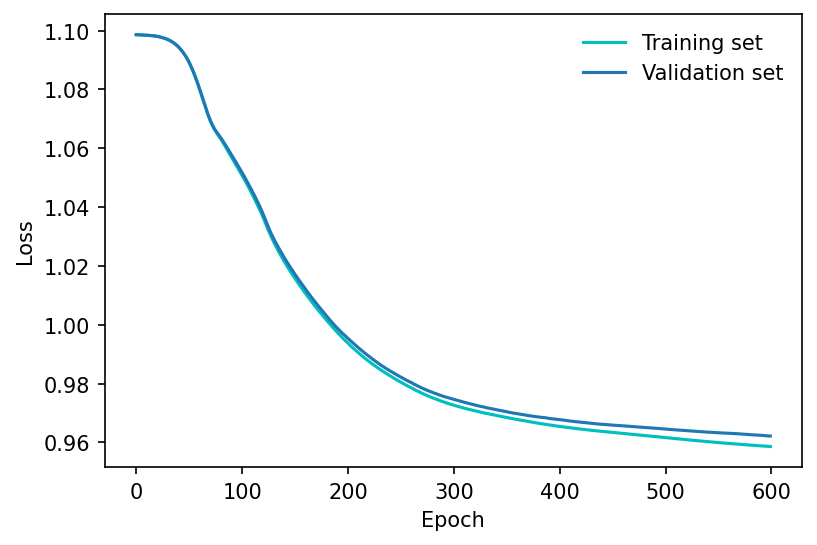

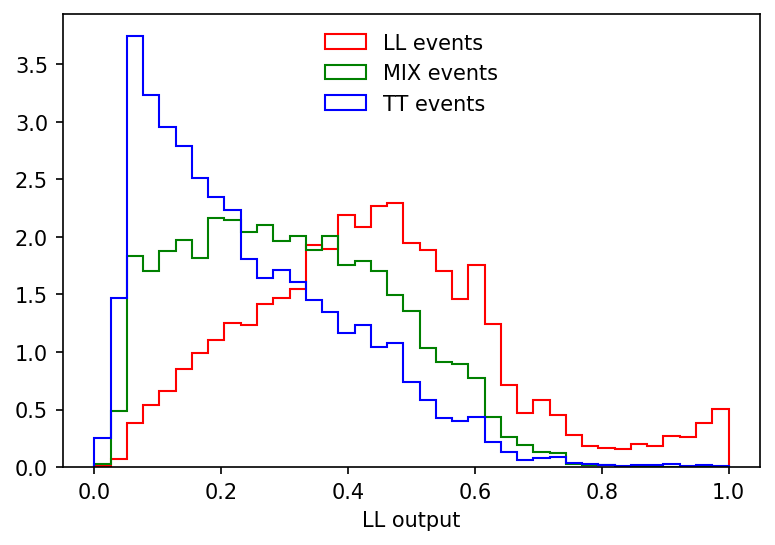

[I 2023-04-19 13:40:19,208] Trial 49 finished with value: 0.5260420185097615 and parameters: {'learning_rate': 0.0006775000186460354, 'n_layers': 10, 'N_NODES': 14}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:46<00:00, 12.91it/s]


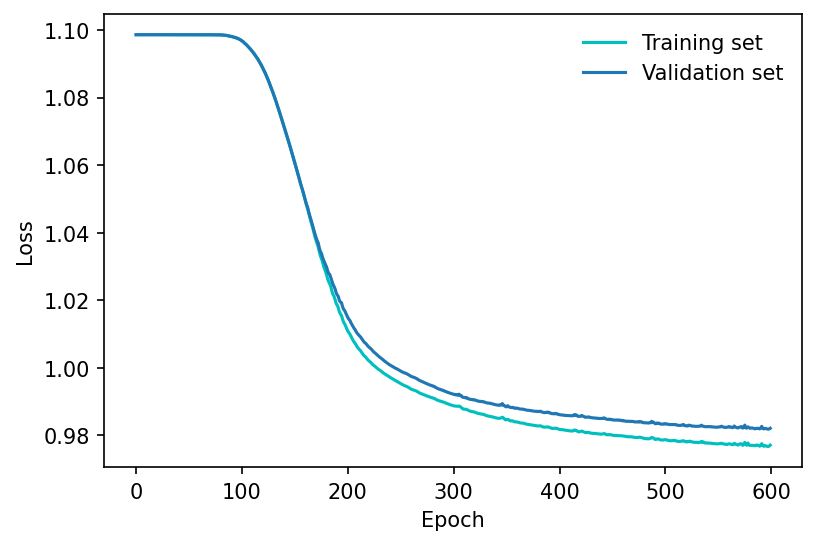

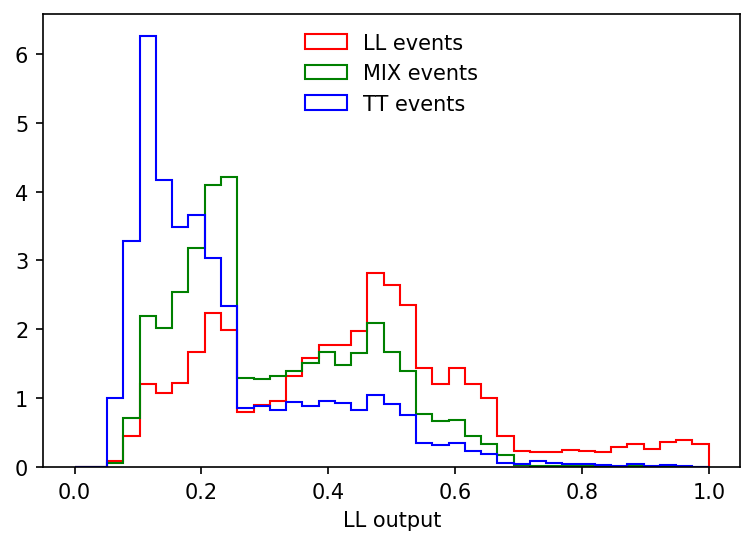

[I 2023-04-19 13:41:06,394] Trial 50 finished with value: 0.5169560224278862 and parameters: {'learning_rate': 0.0006030534579372371, 'n_layers': 10, 'N_NODES': 31}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:31<00:00, 19.33it/s]


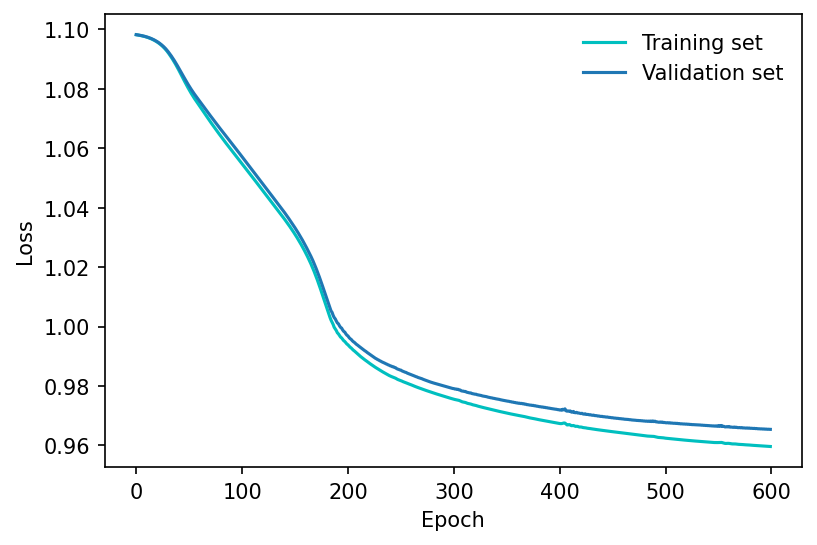

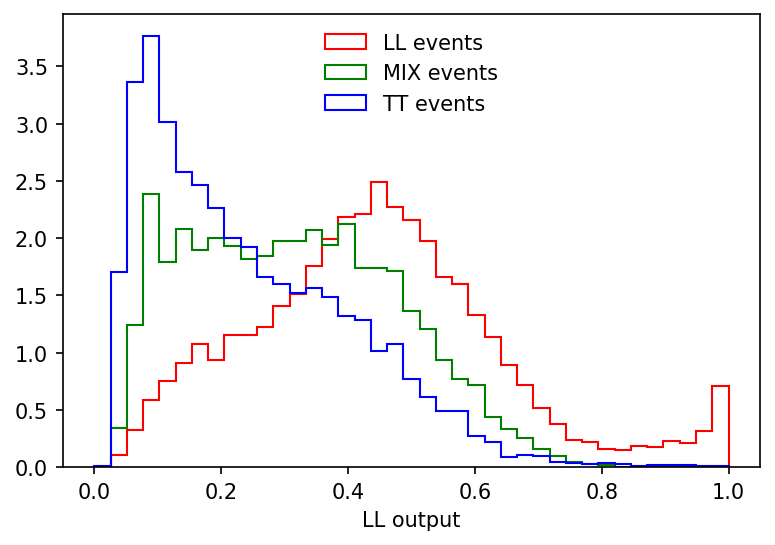

[I 2023-04-19 13:41:38,021] Trial 51 finished with value: 0.5240829561575356 and parameters: {'learning_rate': 0.0006876675404864904, 'n_layers': 10, 'N_NODES': 14}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:36<00:00, 16.49it/s]


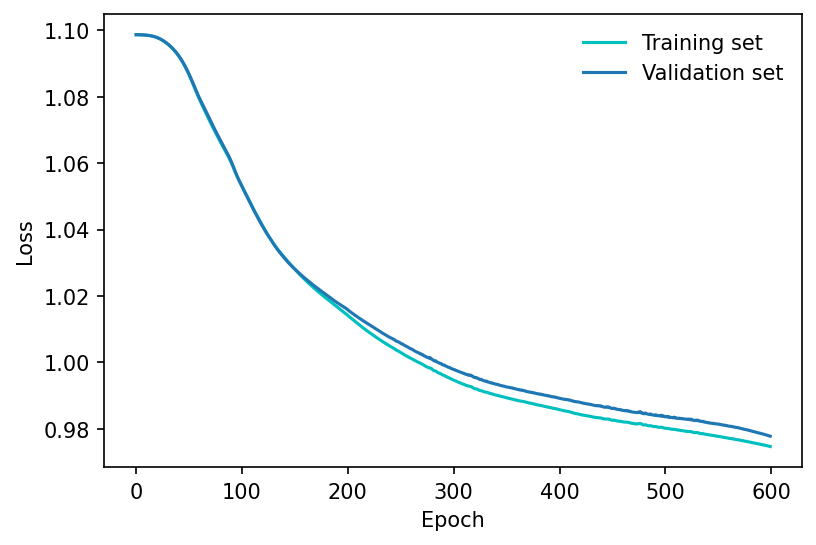

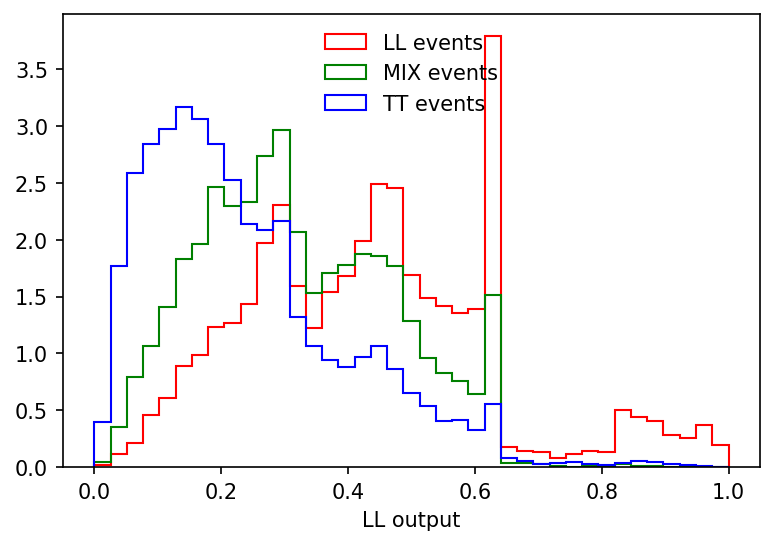

[I 2023-04-19 13:42:15,052] Trial 52 finished with value: 0.5052692021887455 and parameters: {'learning_rate': 0.0007426473965597688, 'n_layers': 9, 'N_NODES': 19}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:40<00:00, 14.78it/s]


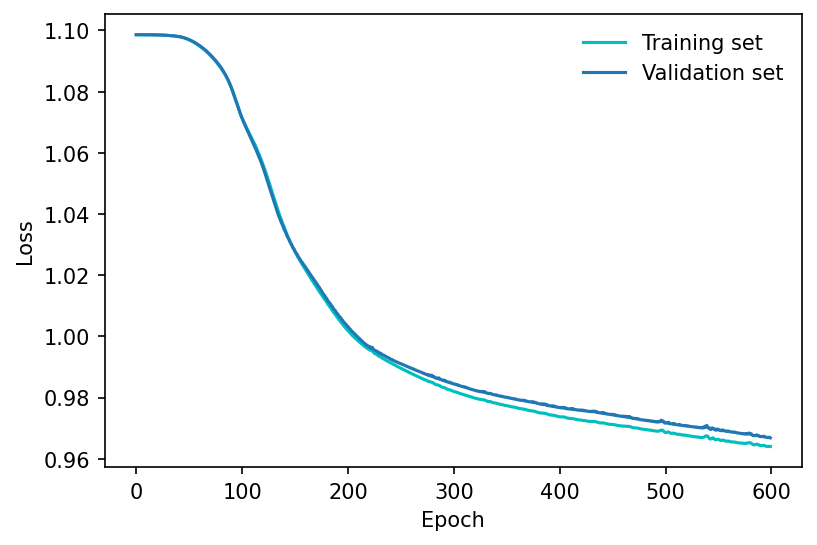

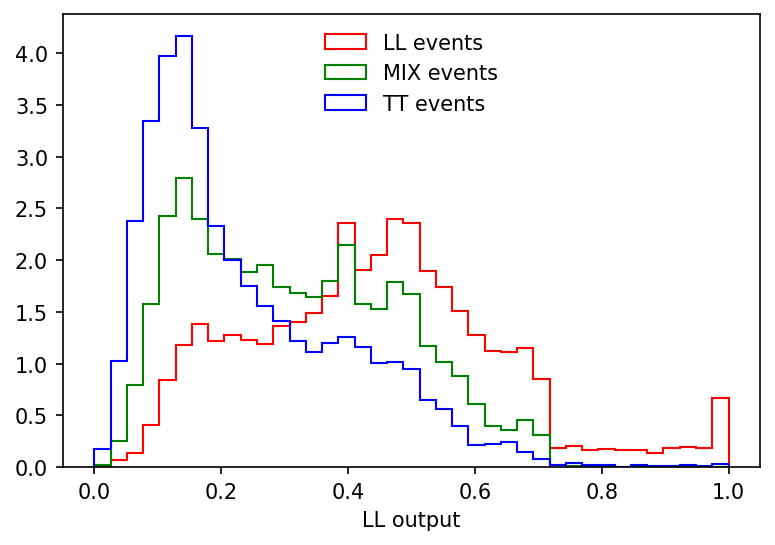

[I 2023-04-19 13:42:56,316] Trial 53 finished with value: 0.5229683172329933 and parameters: {'learning_rate': 0.0006723286813742793, 'n_layers': 10, 'N_NODES': 24}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:30<00:00, 19.71it/s]


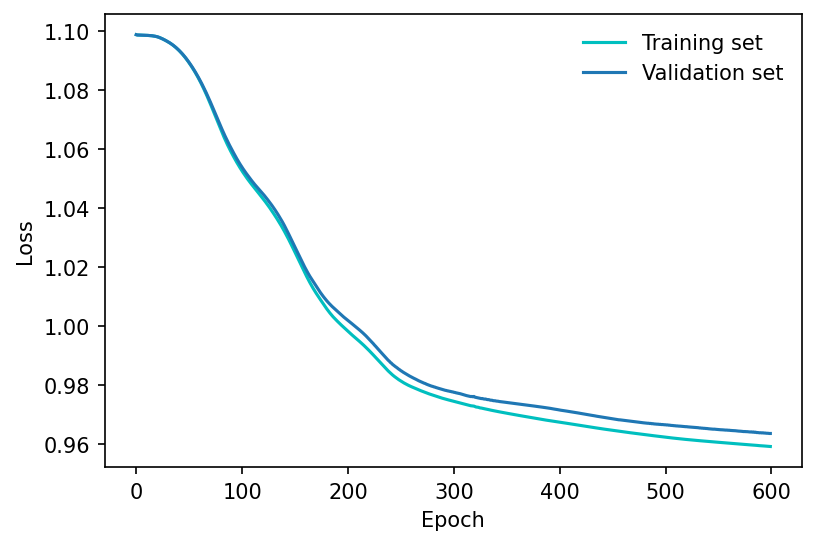

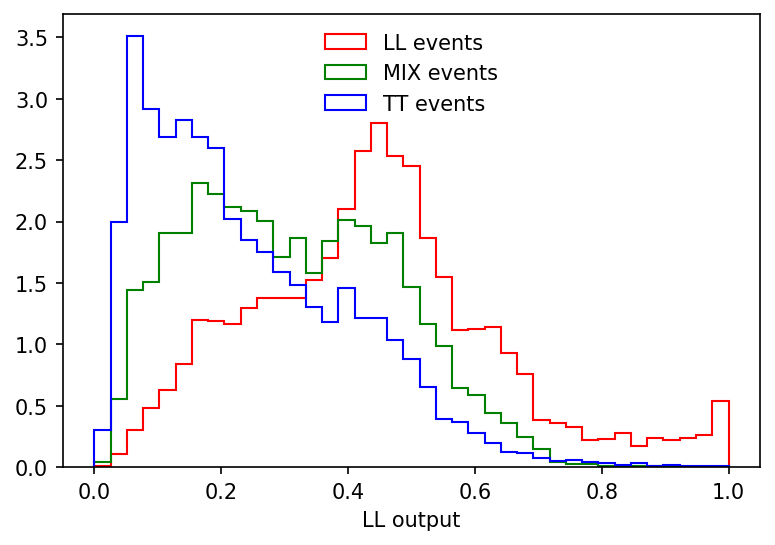

[I 2023-04-19 13:43:27,299] Trial 54 finished with value: 0.525096264270756 and parameters: {'learning_rate': 0.0006416297565512902, 'n_layers': 10, 'N_NODES': 13}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:21<00:00, 27.79it/s]


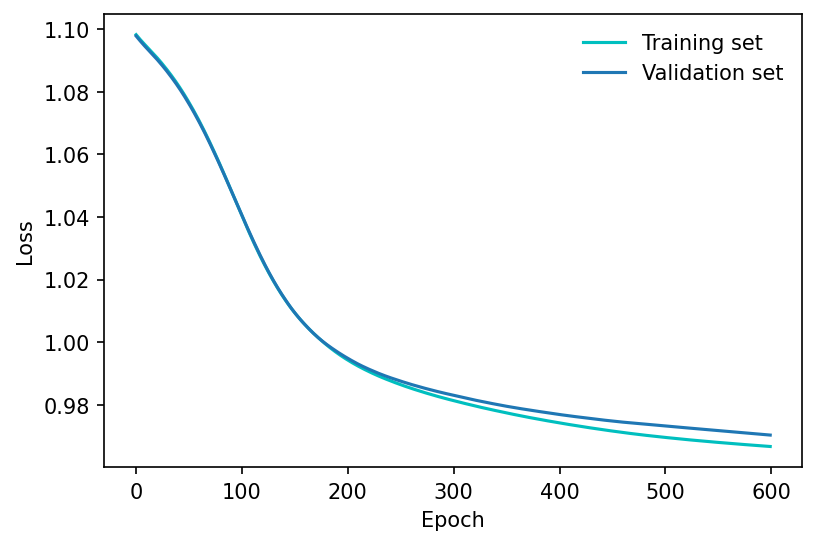

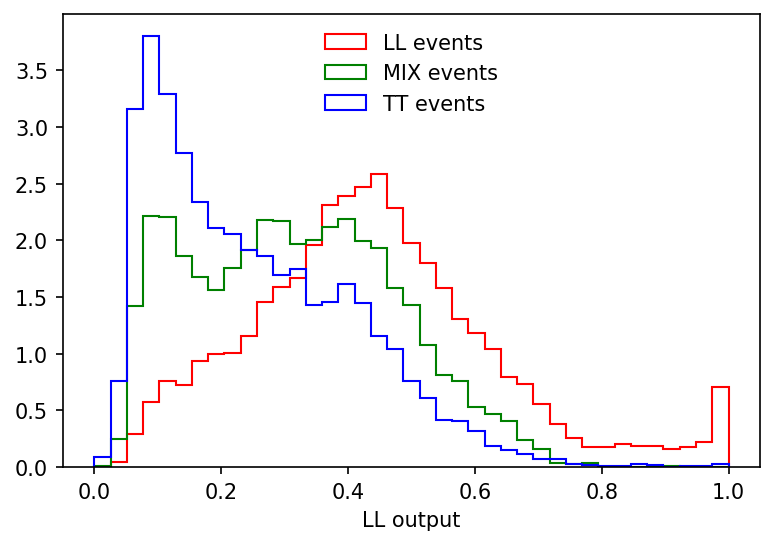

[I 2023-04-19 13:43:49,664] Trial 55 finished with value: 0.517124907113423 and parameters: {'learning_rate': 0.0005598037536253697, 'n_layers': 10, 'N_NODES': 4}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:32<00:00, 18.66it/s]


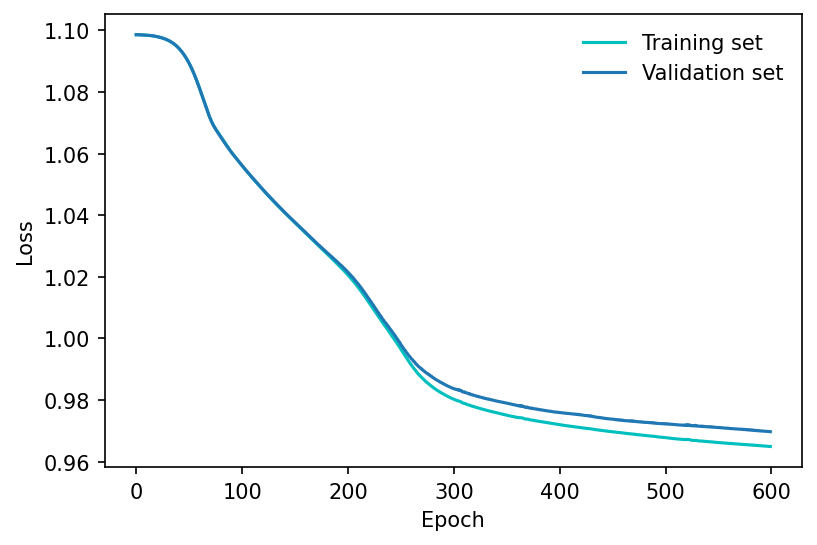

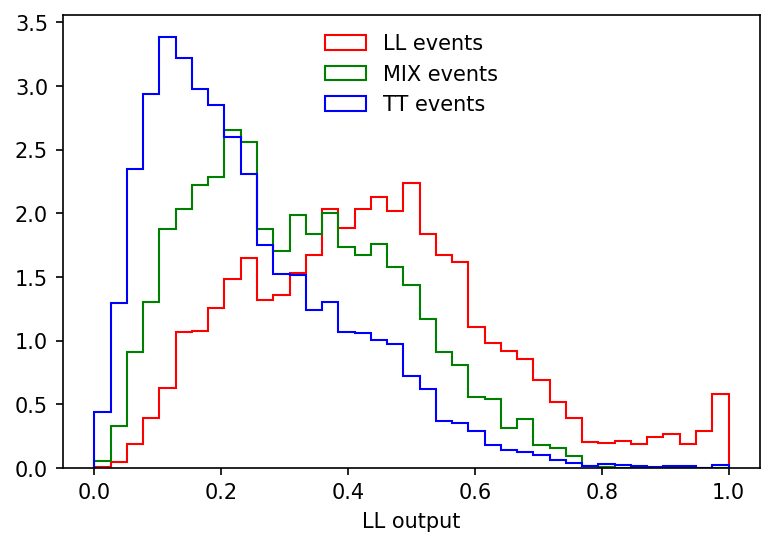

[I 2023-04-19 13:44:22,397] Trial 56 finished with value: 0.5149969600756603 and parameters: {'learning_rate': 0.0006384154340405487, 'n_layers': 10, 'N_NODES': 16}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:29<00:00, 20.14it/s]


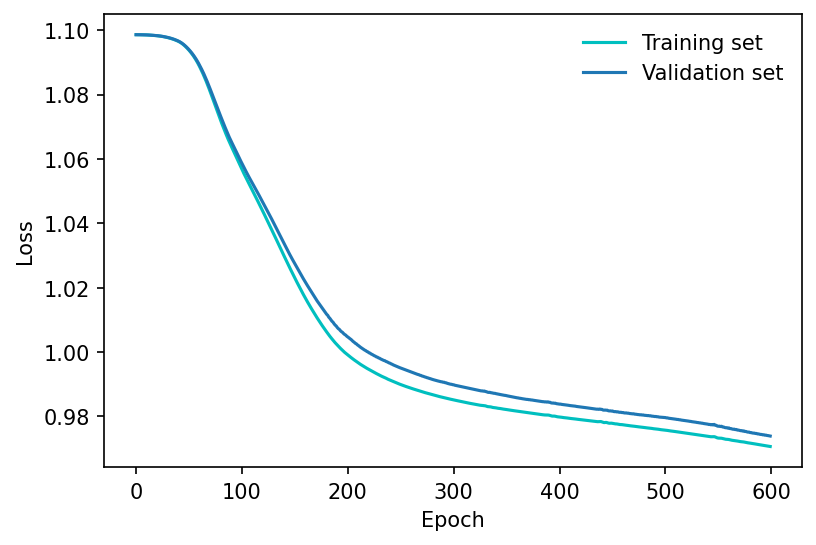

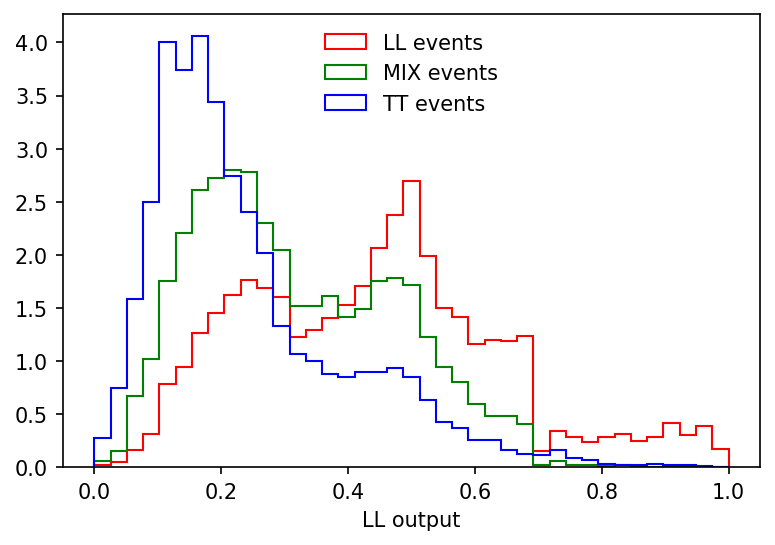

[I 2023-04-19 13:44:52,734] Trial 57 finished with value: 0.5197932851449031 and parameters: {'learning_rate': 0.0007162976536979435, 'n_layers': 10, 'N_NODES': 13}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:31<00:00, 18.84it/s]


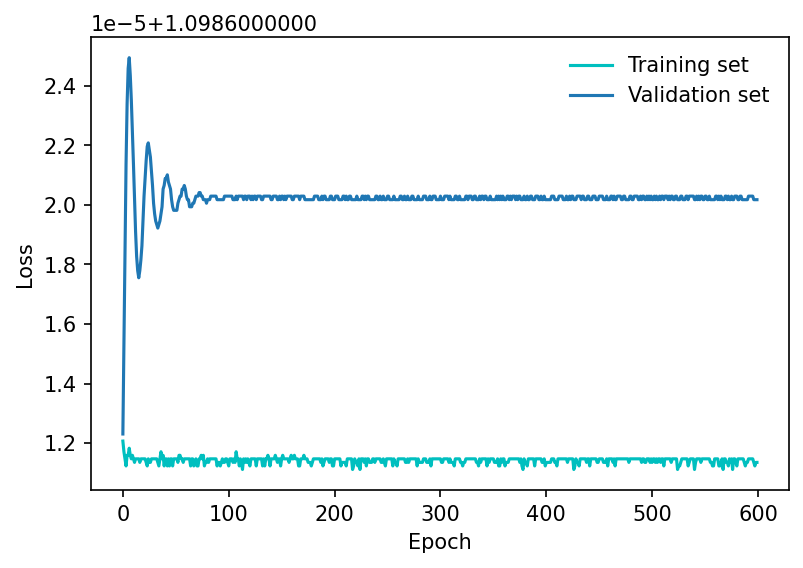

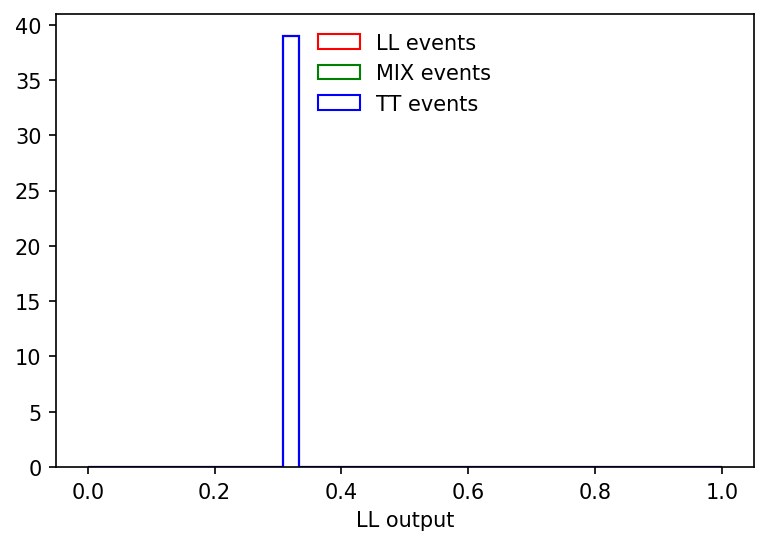

[I 2023-04-19 13:45:25,194] Trial 58 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0006242923787100353, 'n_layers': 1, 'N_NODES': 20}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:41<00:00, 14.44it/s]


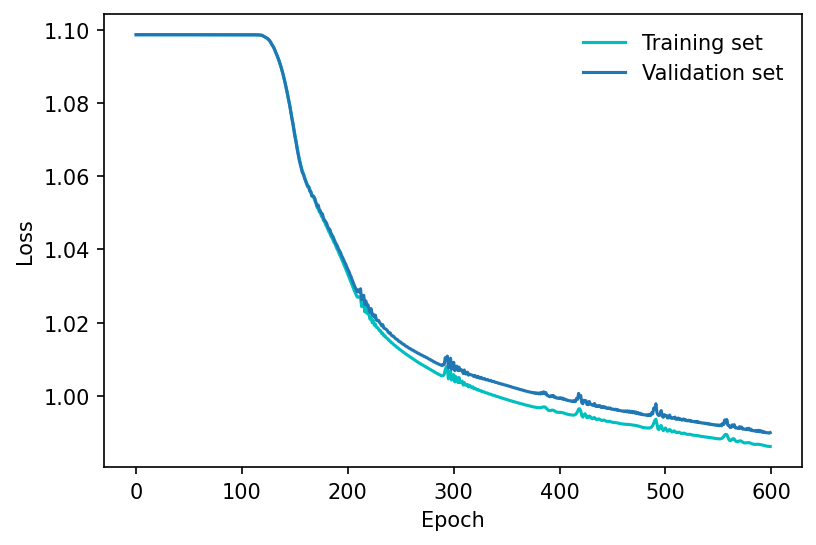

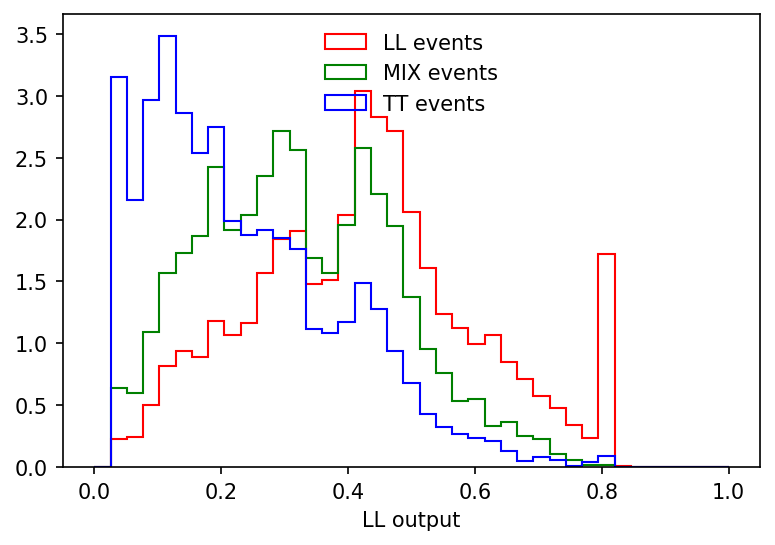

[I 2023-04-19 13:46:07,423] Trial 59 finished with value: 0.500101330811322 and parameters: {'learning_rate': 0.0008207615205027183, 'n_layers': 9, 'N_NODES': 26}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:58<00:00, 10.22it/s]


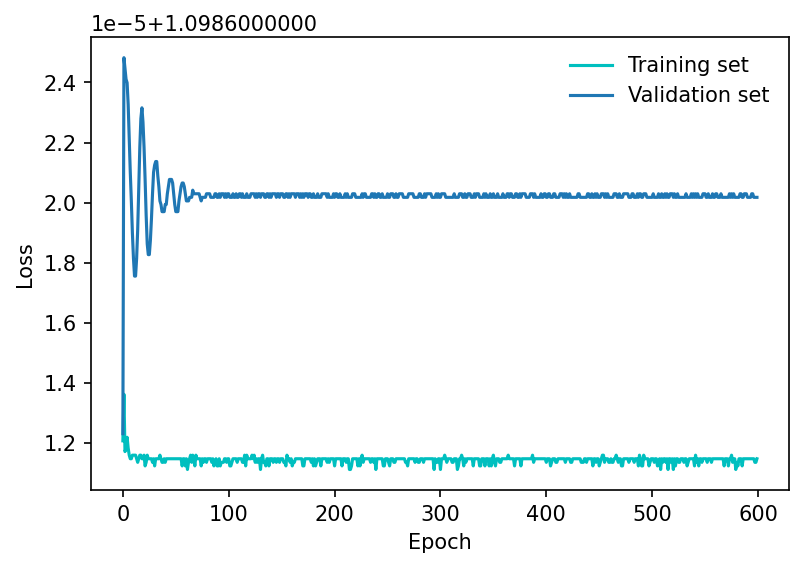

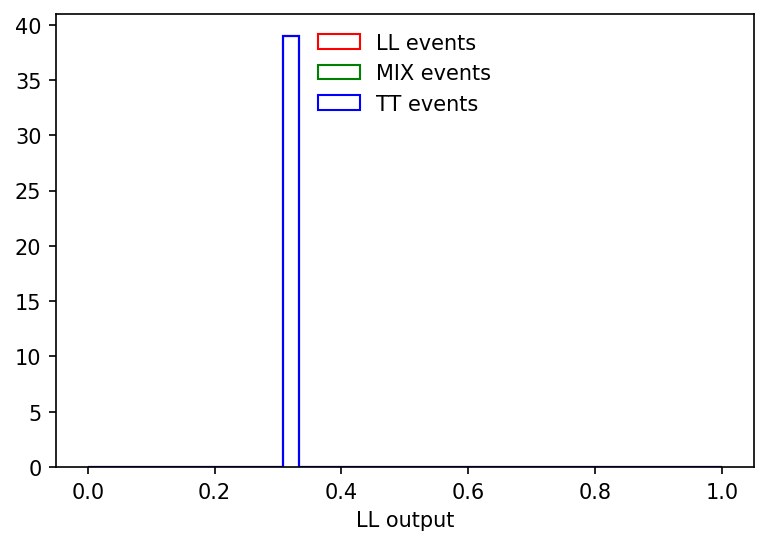

[I 2023-04-19 13:47:06,961] Trial 60 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0007610303434294234, 'n_layers': 8, 'N_NODES': 47}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:27<00:00, 22.00it/s]


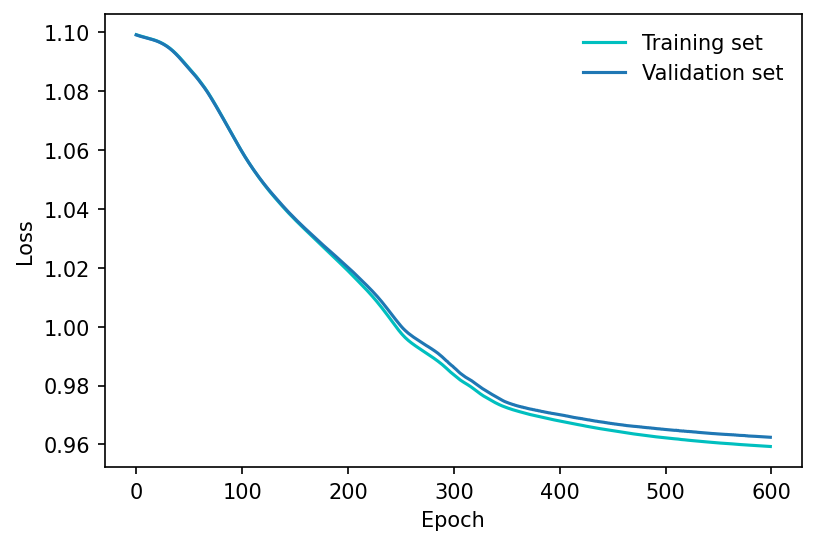

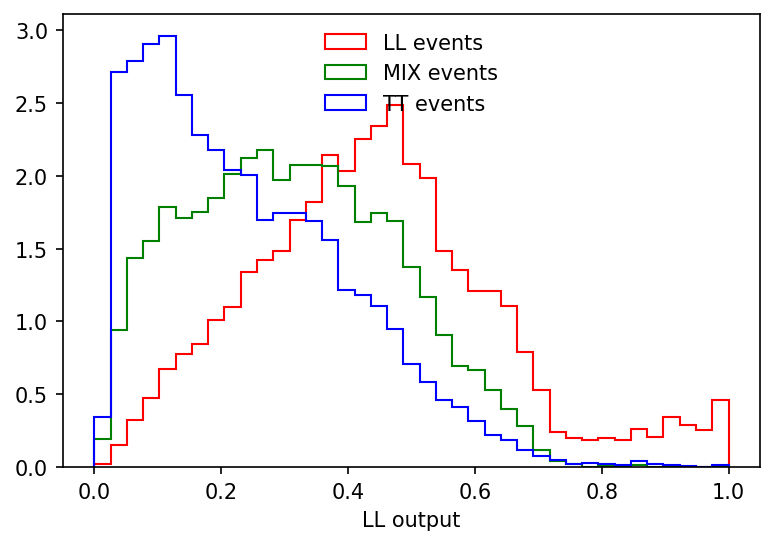

[I 2023-04-19 13:47:34,776] Trial 61 finished with value: 0.5236438559751402 and parameters: {'learning_rate': 0.0006681281930913635, 'n_layers': 9, 'N_NODES': 11}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:21<00:00, 27.58it/s]


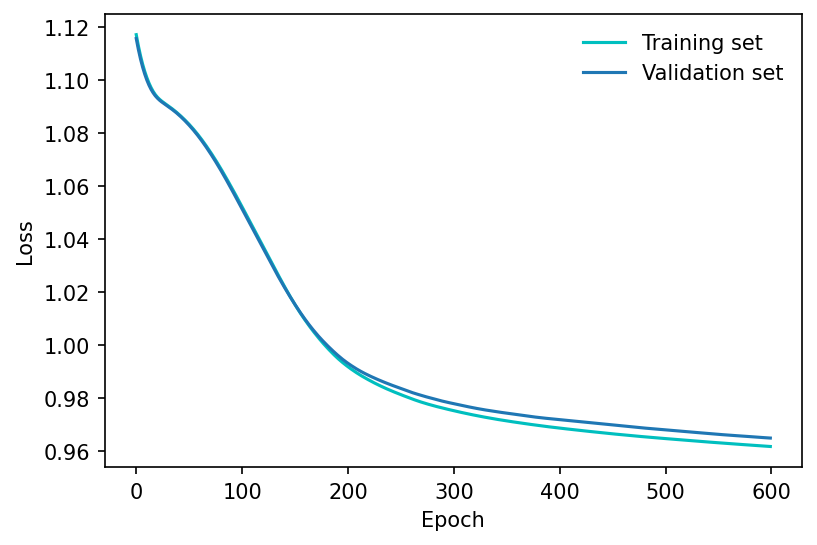

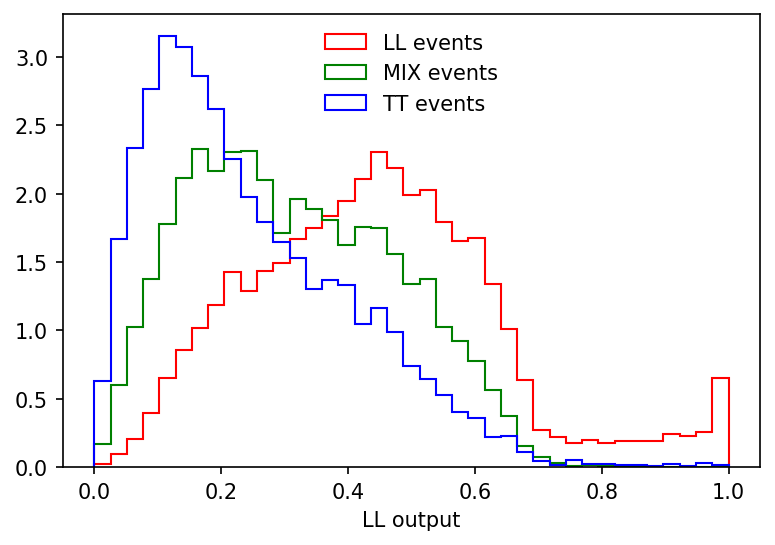

[I 2023-04-19 13:47:57,019] Trial 62 finished with value: 0.519489292710937 and parameters: {'learning_rate': 0.0007011175788344799, 'n_layers': 10, 'N_NODES': 5}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:27<00:00, 21.70it/s]


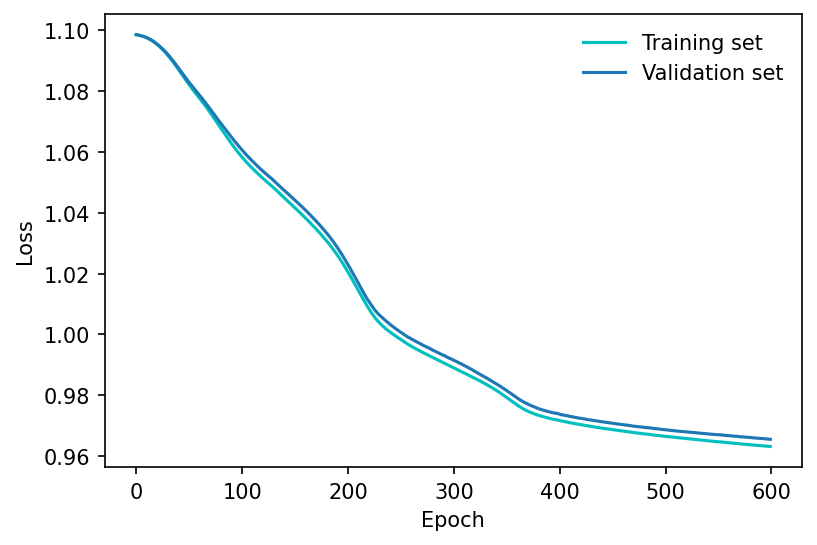

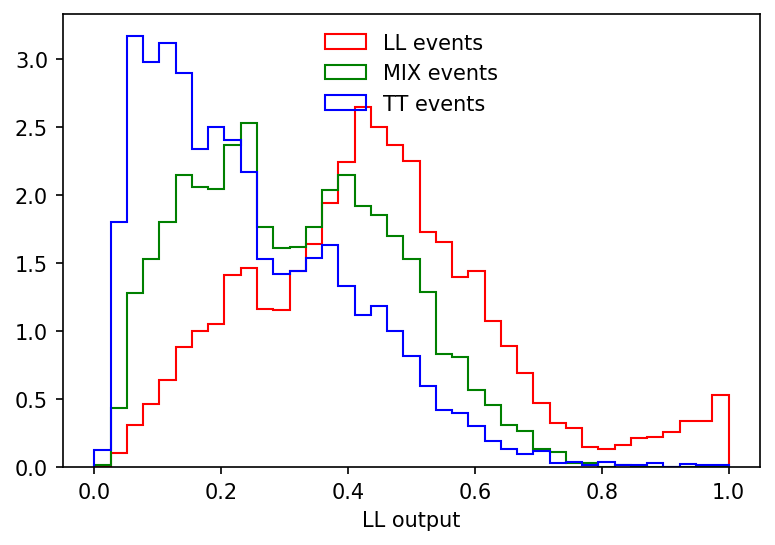

[I 2023-04-19 13:48:25,207] Trial 63 finished with value: 0.522259001553739 and parameters: {'learning_rate': 0.0006607632889429366, 'n_layers': 9, 'N_NODES': 11}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:31<00:00, 19.01it/s]


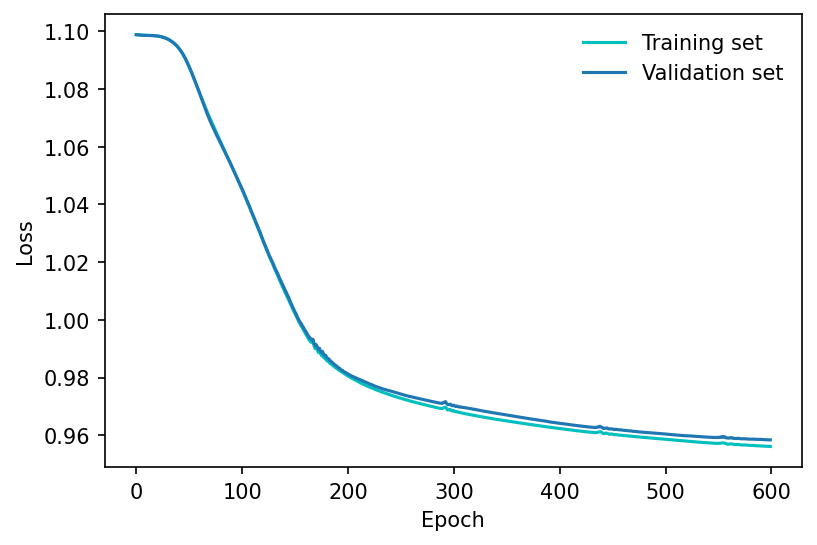

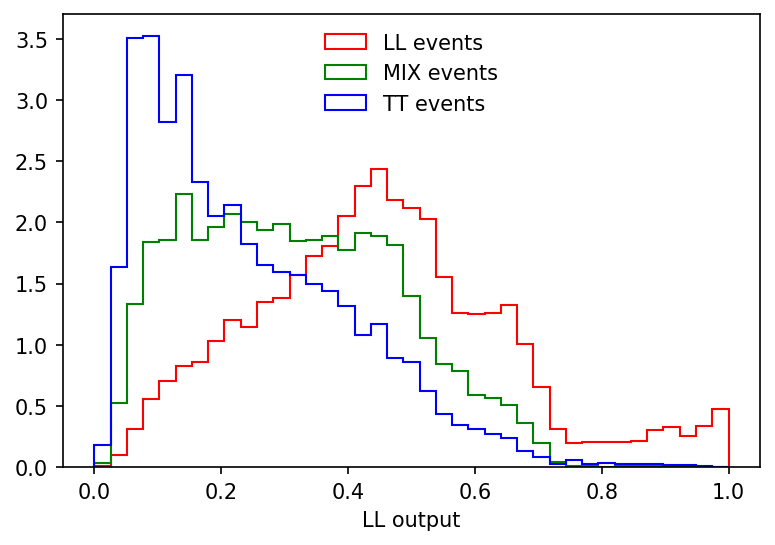

[I 2023-04-19 13:48:57,398] Trial 64 finished with value: 0.5272917651827332 and parameters: {'learning_rate': 0.0007955978062474166, 'n_layers': 10, 'N_NODES': 16}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:32<00:00, 18.61it/s]


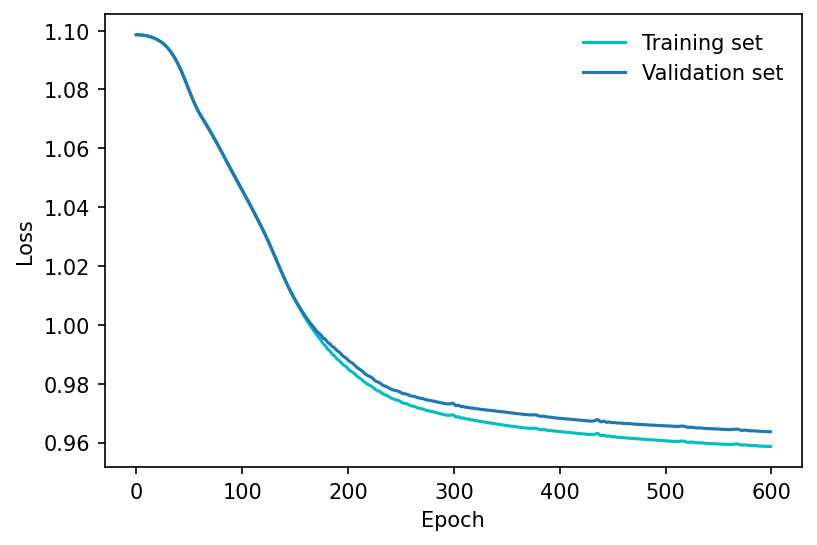

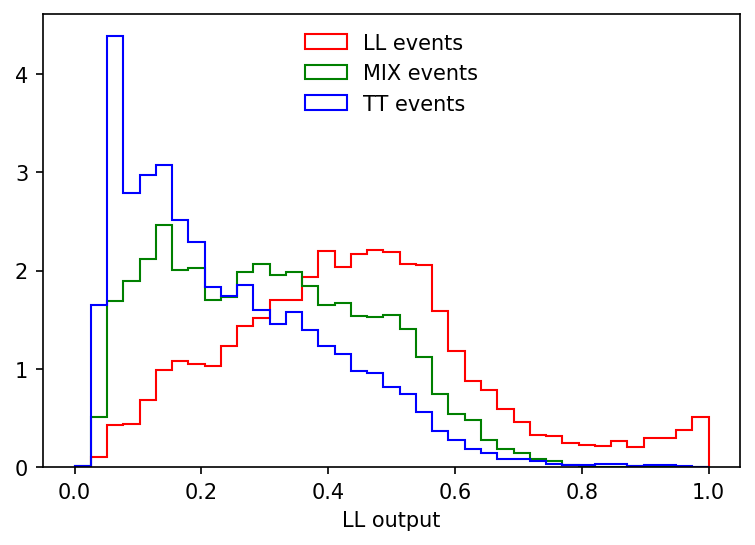

[I 2023-04-19 13:49:30,214] Trial 65 finished with value: 0.5226305478619199 and parameters: {'learning_rate': 0.0007841342876791813, 'n_layers': 10, 'N_NODES': 16}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:23<00:00, 25.59it/s]


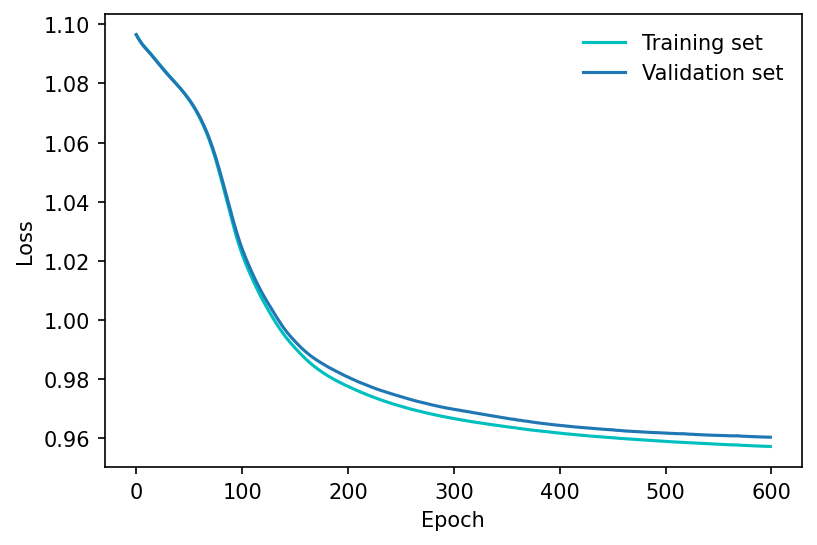

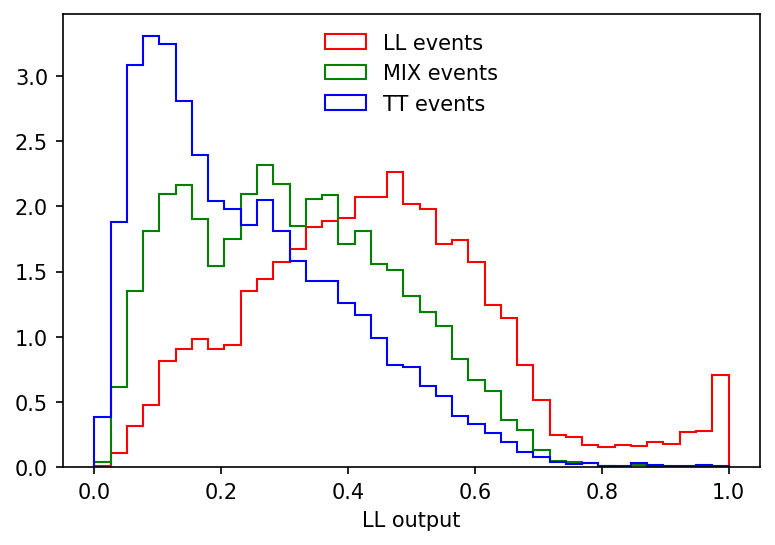

[I 2023-04-19 13:49:54,170] Trial 66 finished with value: 0.526481118692157 and parameters: {'learning_rate': 0.0008594496472535123, 'n_layers': 10, 'N_NODES': 8}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:17<00:00, 35.00it/s]


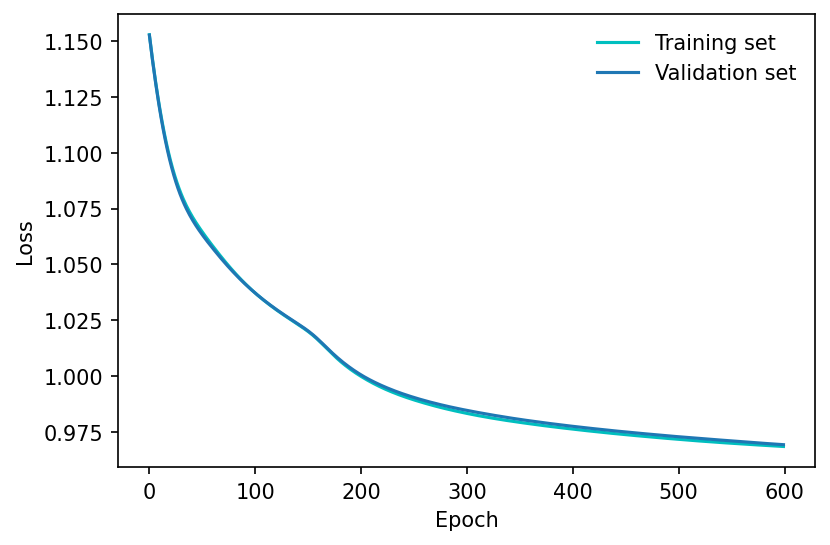

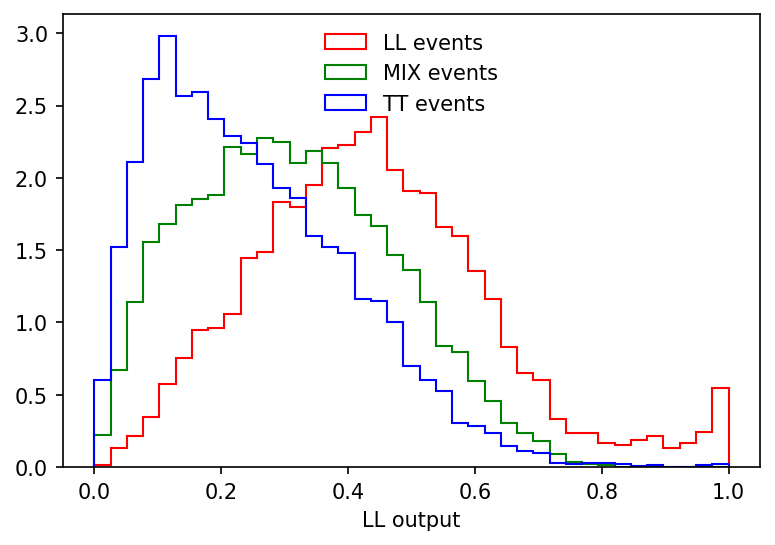

[I 2023-04-19 13:50:12,070] Trial 67 finished with value: 0.5151658447611971 and parameters: {'learning_rate': 0.0008640865834085729, 'n_layers': 10, 'N_NODES': 1}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:23<00:00, 25.26it/s]


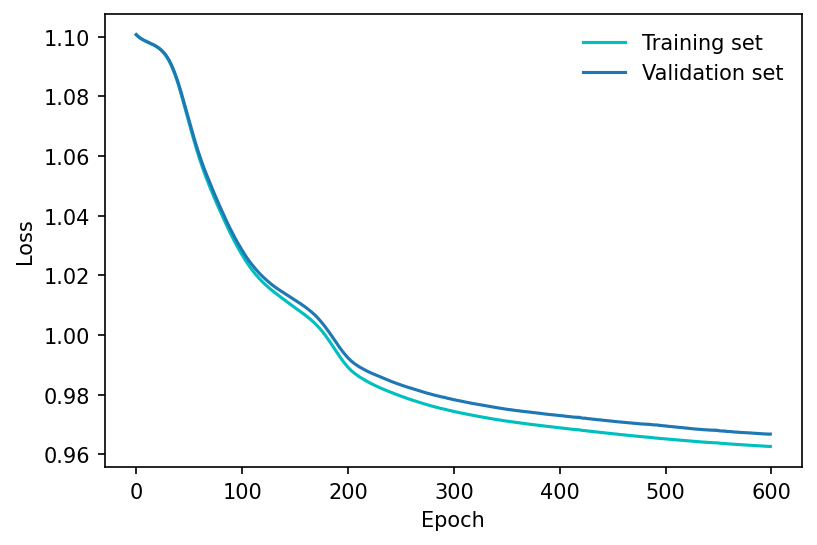

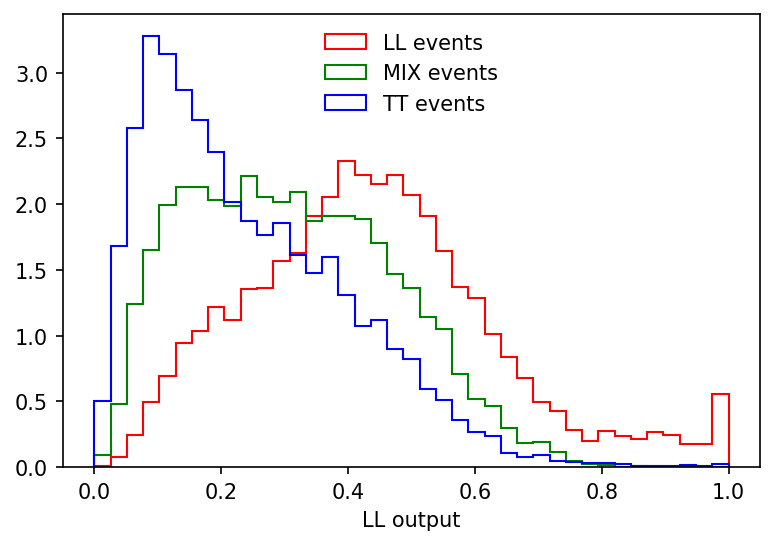

[I 2023-04-19 13:50:36,323] Trial 68 finished with value: 0.5201648314530838 and parameters: {'learning_rate': 0.0008213026970418365, 'n_layers': 9, 'N_NODES': 8}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:36<00:00, 16.27it/s]


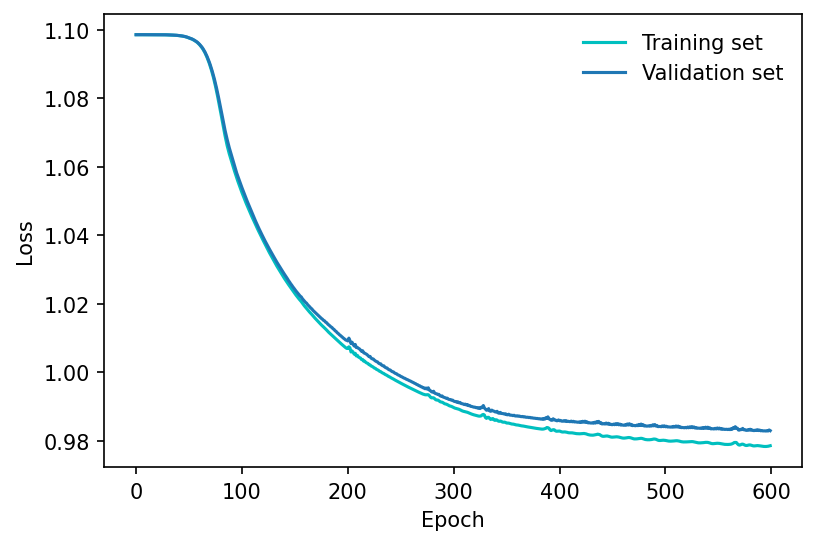

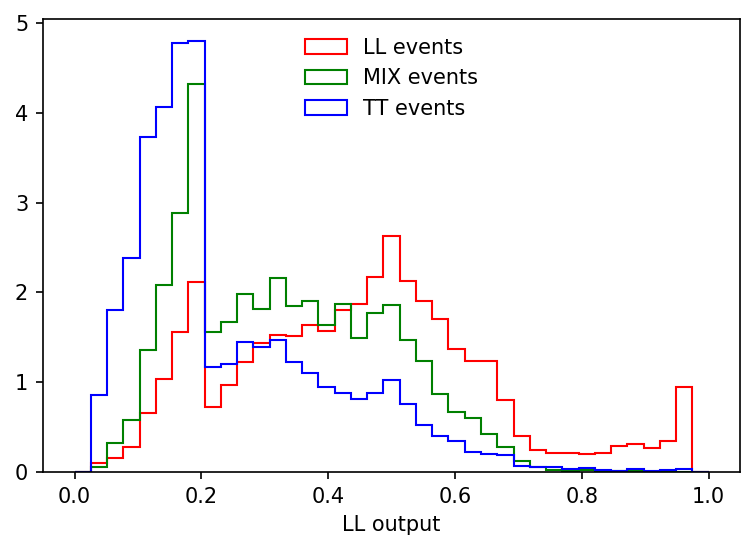

[I 2023-04-19 13:51:13,816] Trial 69 finished with value: 0.5098628656353442 and parameters: {'learning_rate': 0.0007939568439471693, 'n_layers': 10, 'N_NODES': 22}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:19<00:00, 30.06it/s]


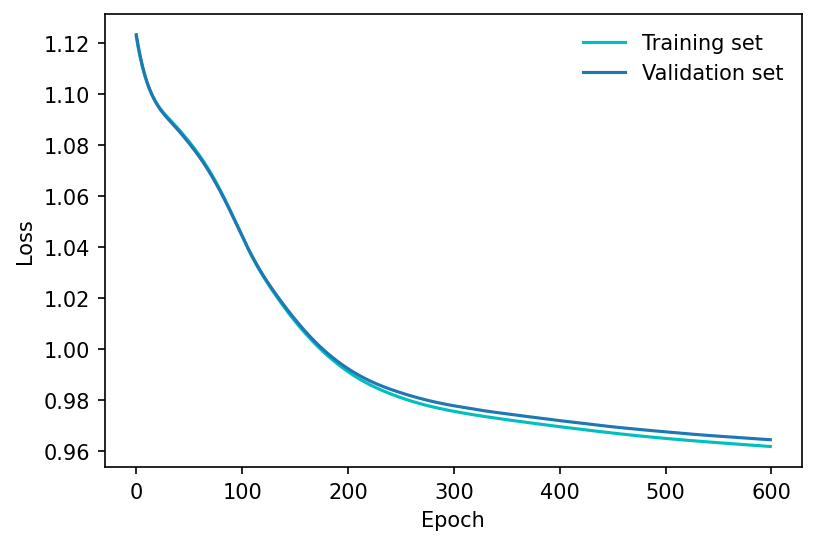

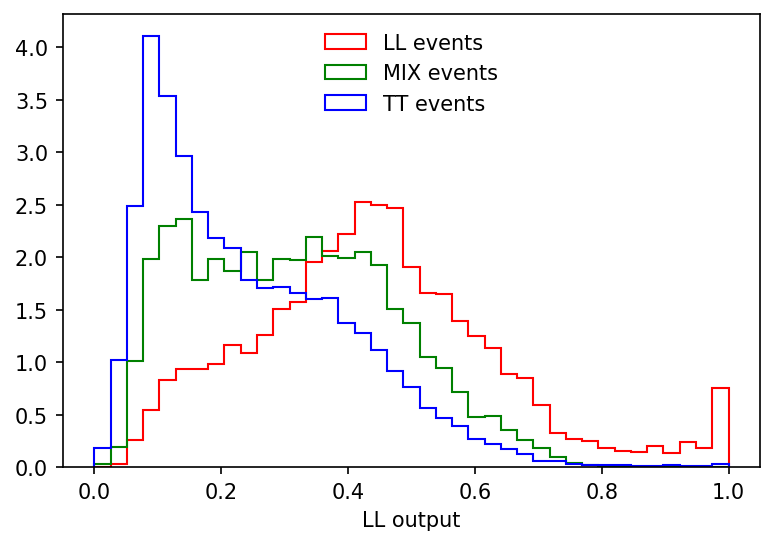

[I 2023-04-19 13:51:34,301] Trial 70 finished with value: 0.5227656556103493 and parameters: {'learning_rate': 0.0007634192254687632, 'n_layers': 9, 'N_NODES': 4}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:27<00:00, 21.86it/s]


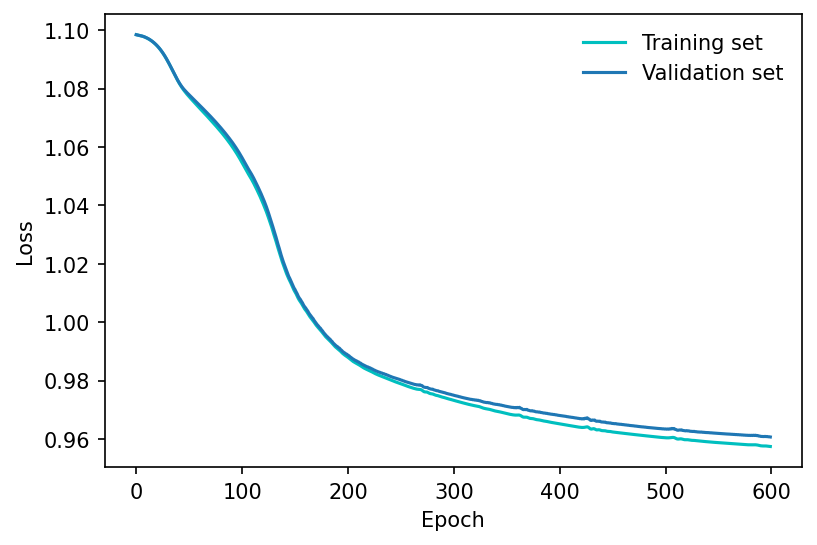

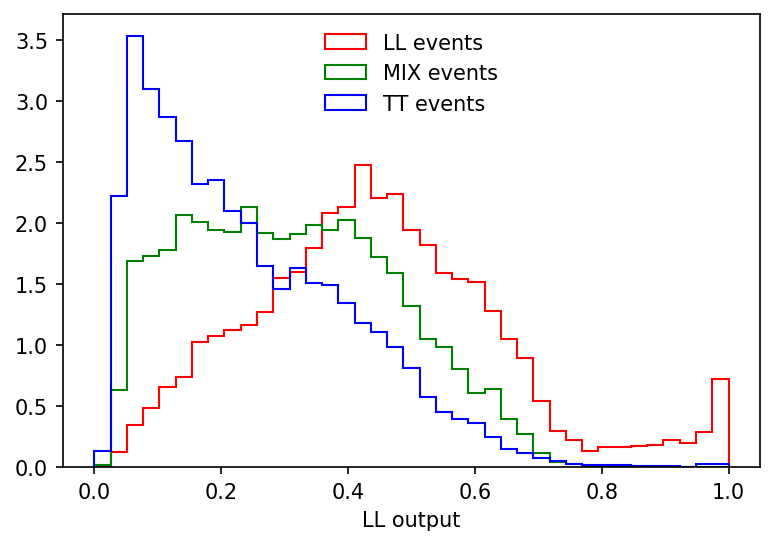

[I 2023-04-19 13:52:02,316] Trial 71 finished with value: 0.526379787880835 and parameters: {'learning_rate': 0.0007373496124605, 'n_layers': 10, 'N_NODES': 14}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:31<00:00, 19.05it/s]


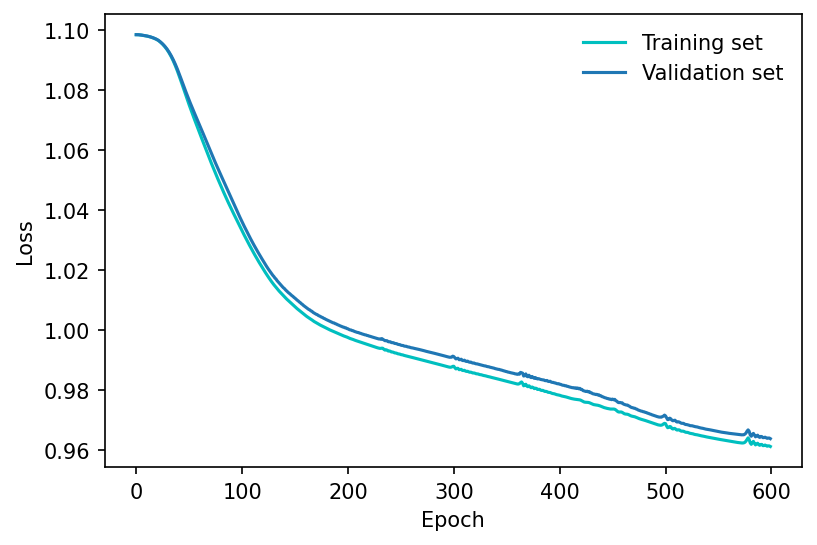

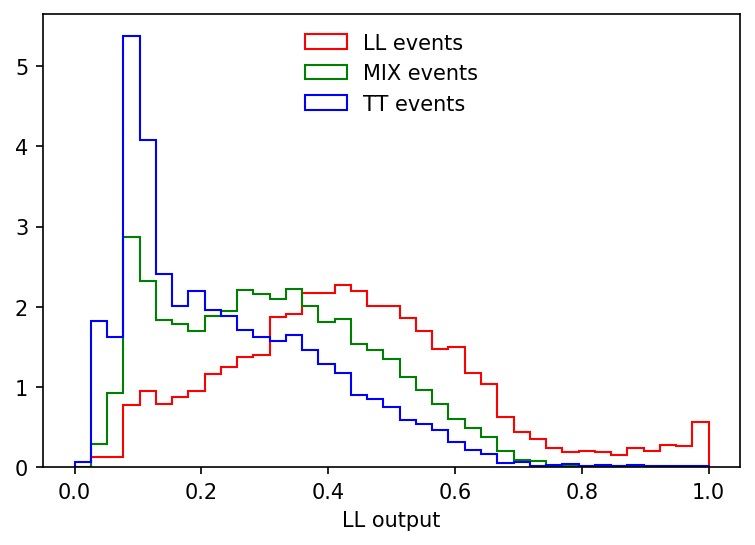

[I 2023-04-19 13:52:34,406] Trial 72 finished with value: 0.5219212321826657 and parameters: {'learning_rate': 0.0007361957942901742, 'n_layers': 10, 'N_NODES': 18}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:22<00:00, 26.42it/s]


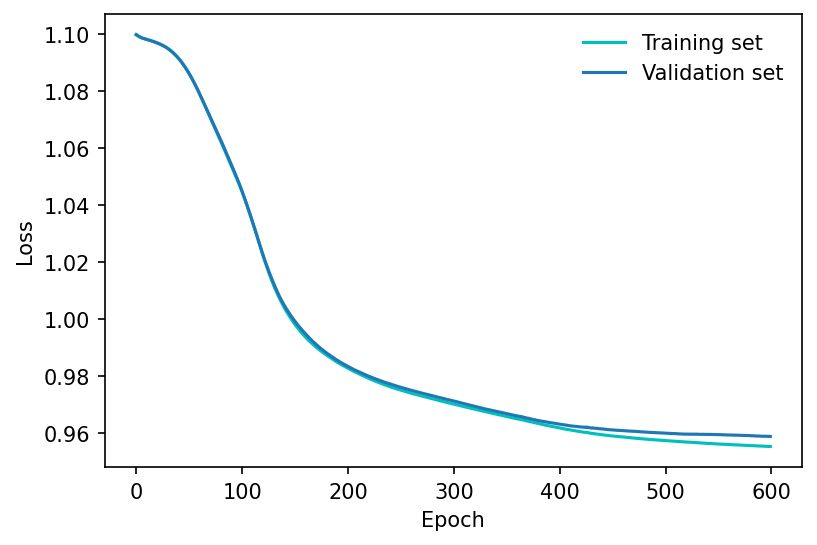

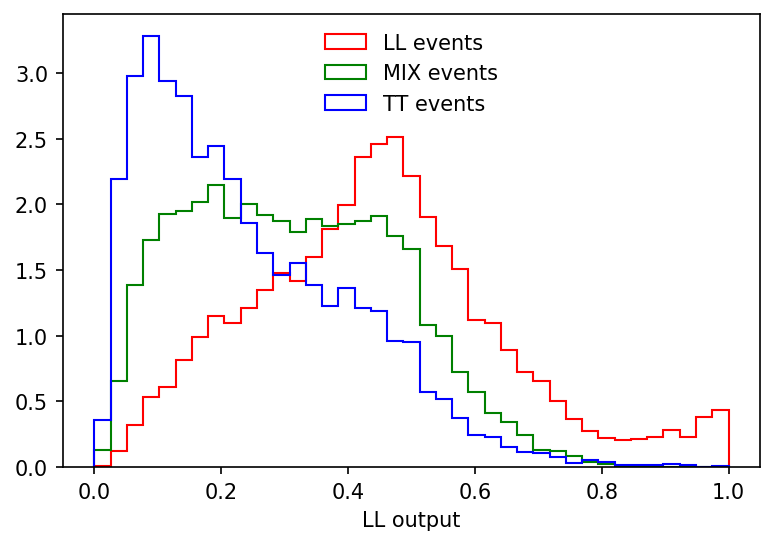

[I 2023-04-19 13:52:57,607] Trial 73 finished with value: 0.5255691413902587 and parameters: {'learning_rate': 0.0008407075253767211, 'n_layers': 10, 'N_NODES': 7}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:23<00:00, 25.42it/s]


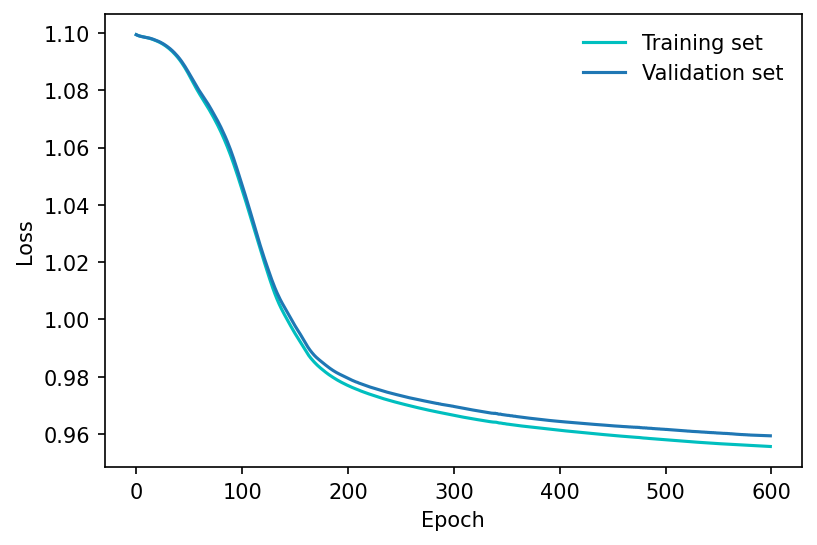

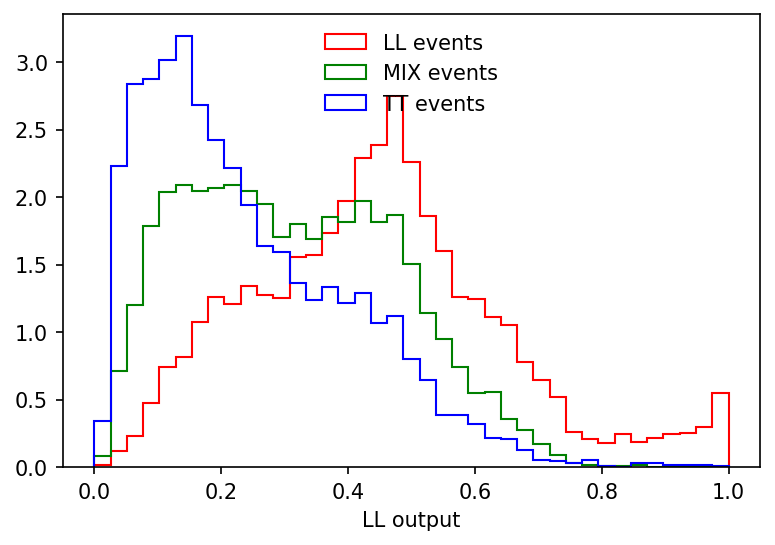

[I 2023-04-19 13:53:21,716] Trial 74 finished with value: 0.525501587516044 and parameters: {'learning_rate': 0.000828142255191501, 'n_layers': 10, 'N_NODES': 8}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [01:18<00:00,  7.61it/s]


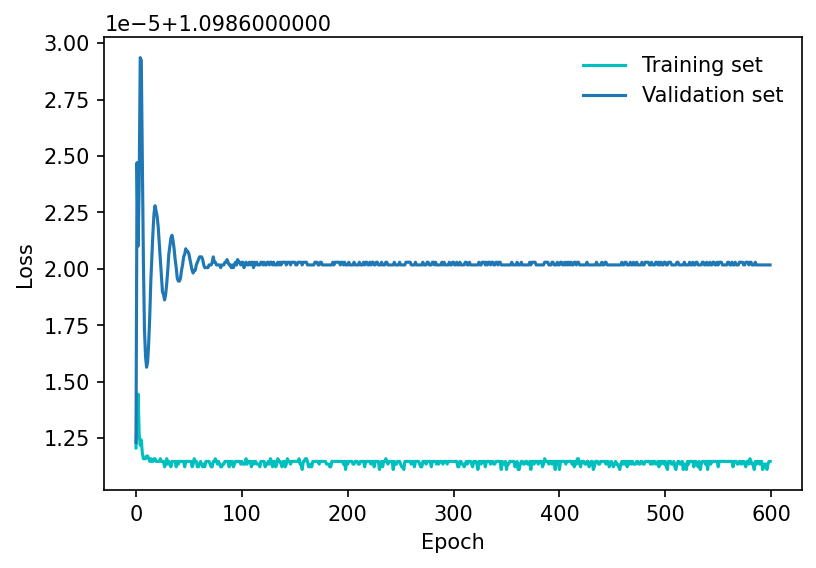

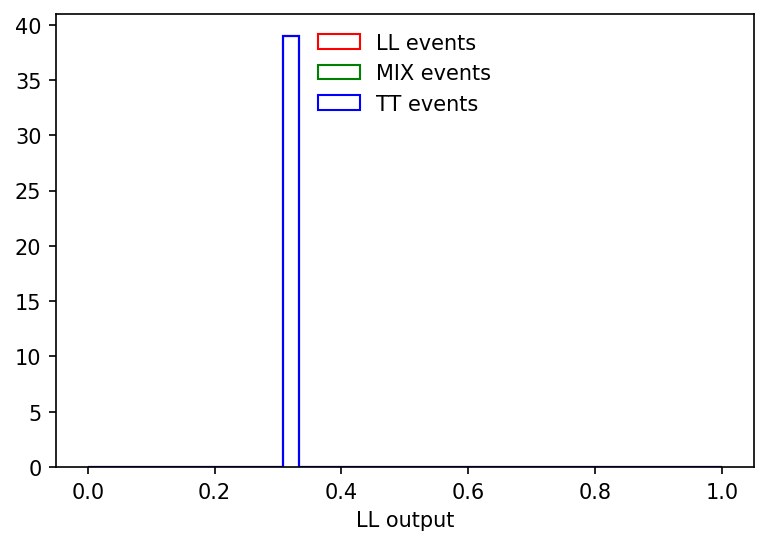

[I 2023-04-19 13:54:41,869] Trial 75 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0008748859903037654, 'n_layers': 9, 'N_NODES': 69}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:30<00:00, 19.83it/s]


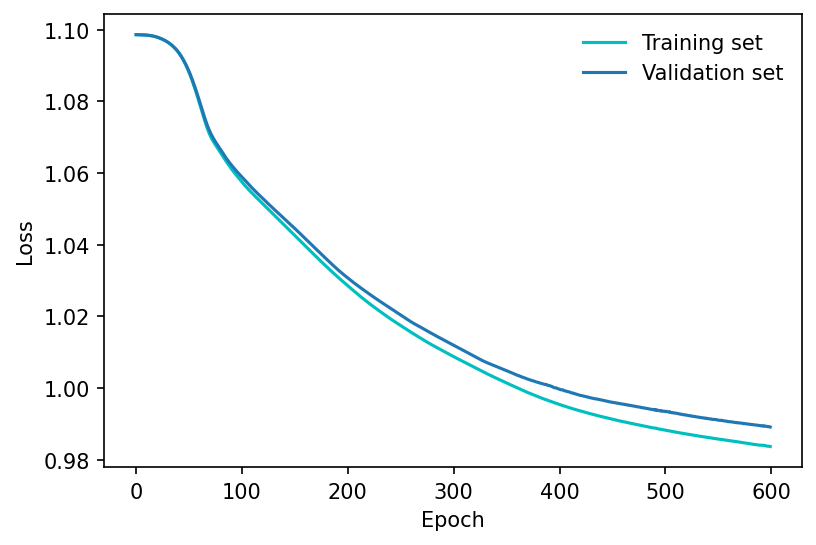

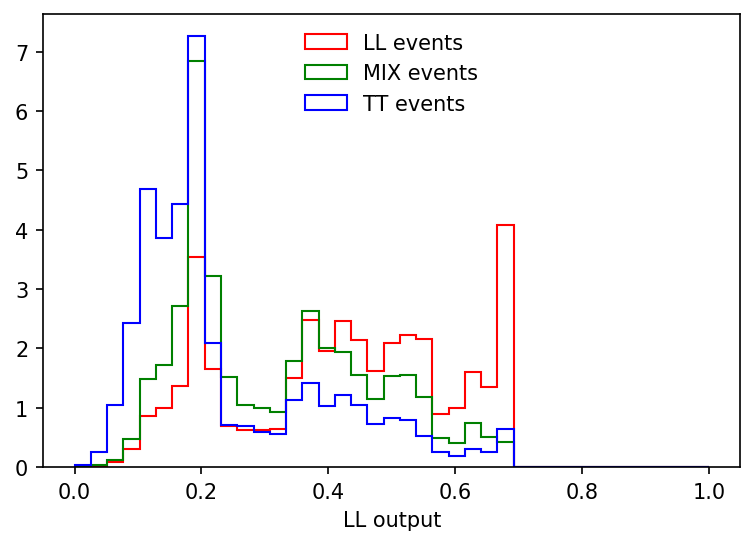

[I 2023-04-19 13:55:12,736] Trial 76 finished with value: 0.5143551982706208 and parameters: {'learning_rate': 0.0008439126942828117, 'n_layers': 8, 'N_NODES': 16}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:19<00:00, 31.08it/s]


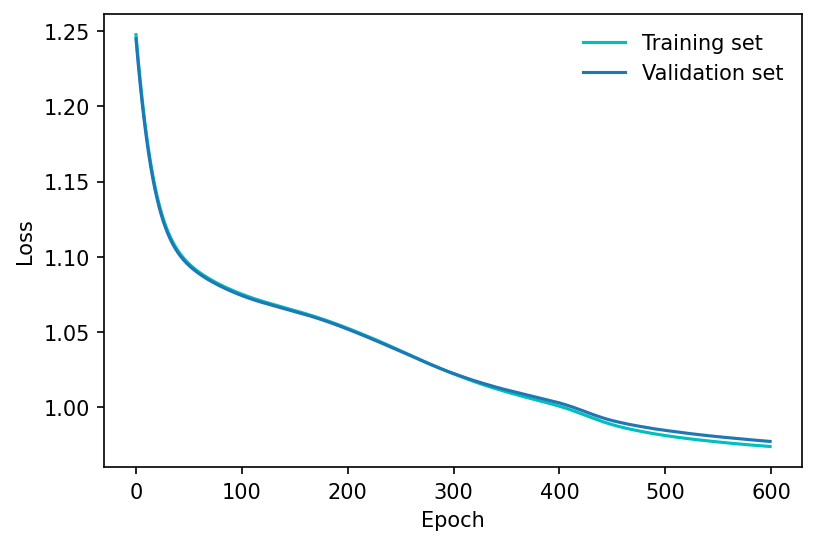

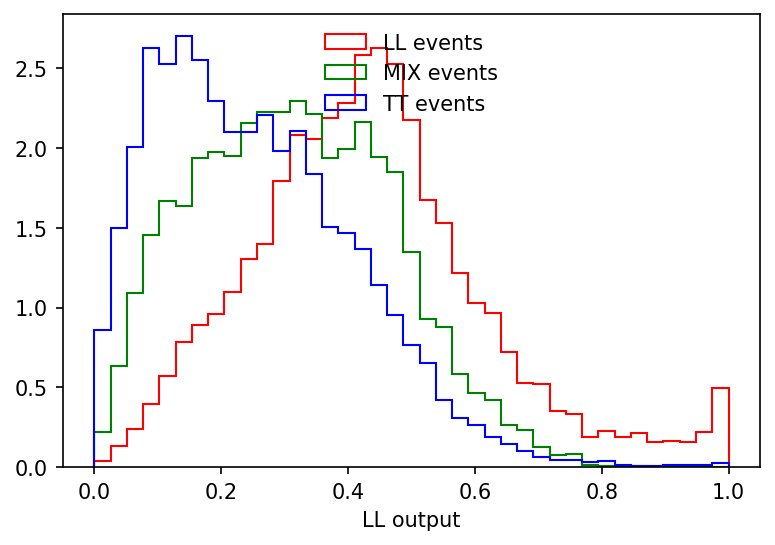

[I 2023-04-19 13:55:32,504] Trial 77 finished with value: 0.5097277578869148 and parameters: {'learning_rate': 0.0007936009573610201, 'n_layers': 9, 'N_NODES': 3}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:22<00:00, 26.68it/s]


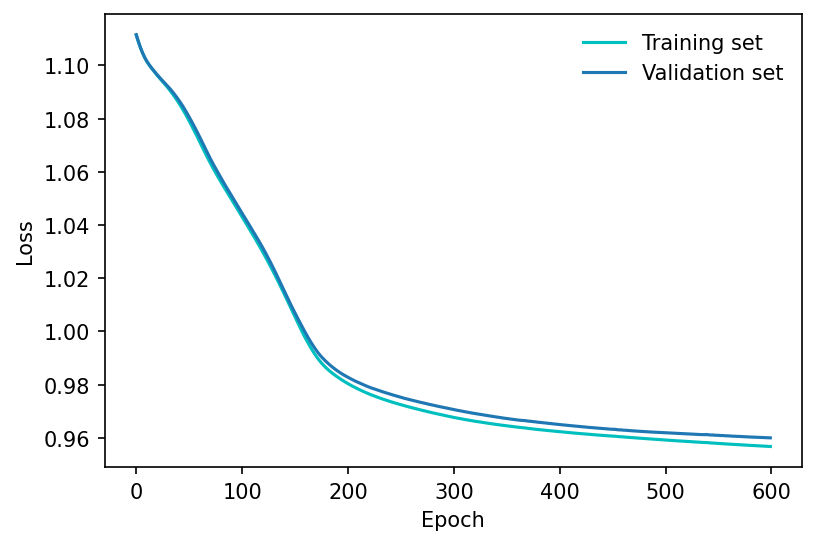

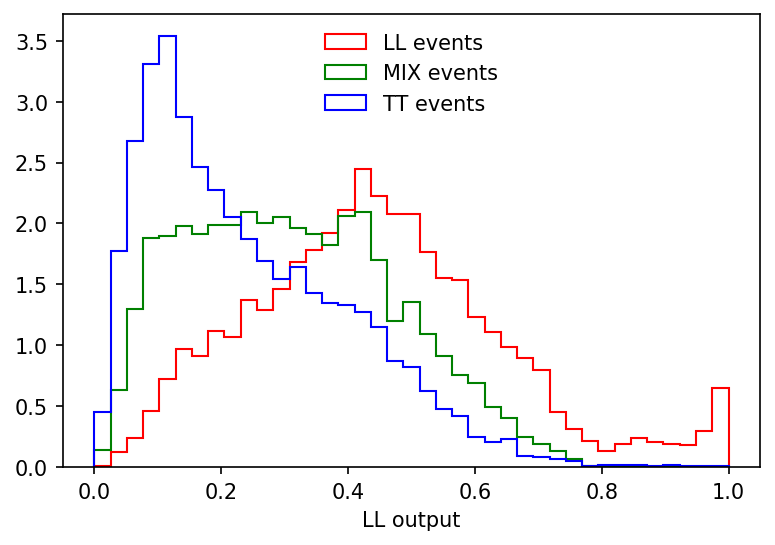

[I 2023-04-19 13:55:55,486] Trial 78 finished with value: 0.5264135648179423 and parameters: {'learning_rate': 0.0008122595960341434, 'n_layers': 10, 'N_NODES': 7}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:24<00:00, 25.00it/s]


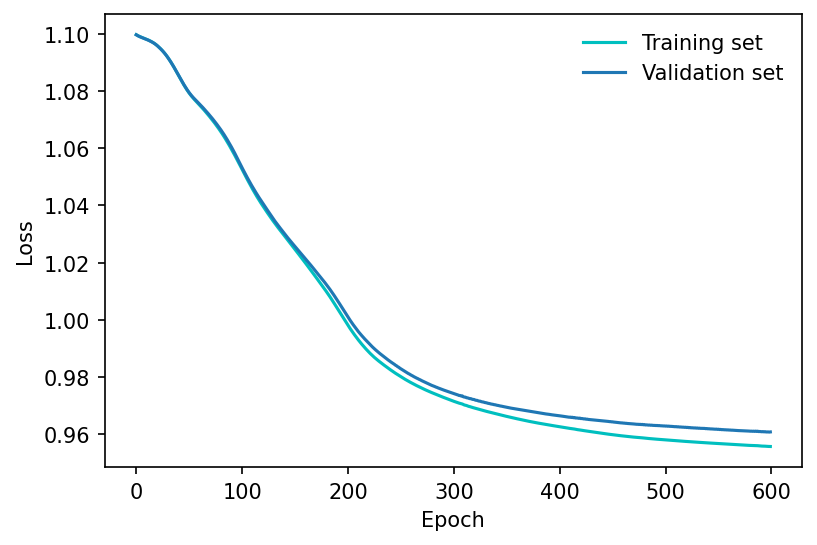

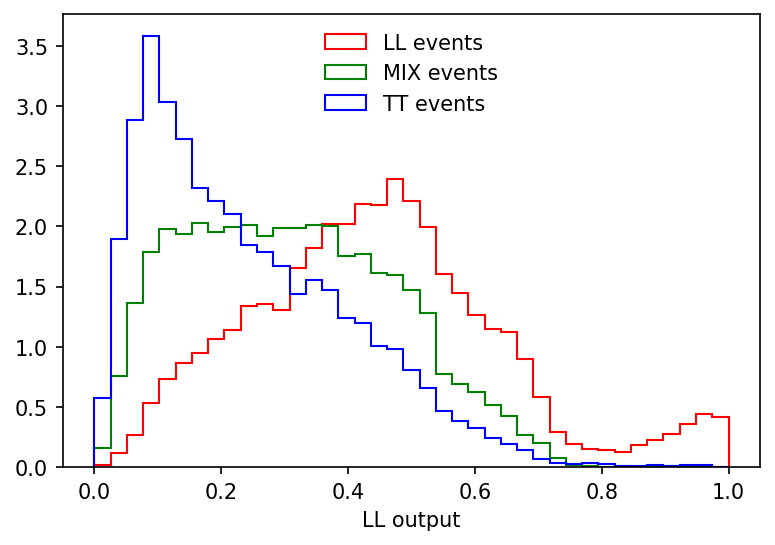

[I 2023-04-19 13:56:20,223] Trial 79 finished with value: 0.5269539958116598 and parameters: {'learning_rate': 0.0007574376672239273, 'n_layers': 10, 'N_NODES': 9}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:33<00:00, 18.03it/s]


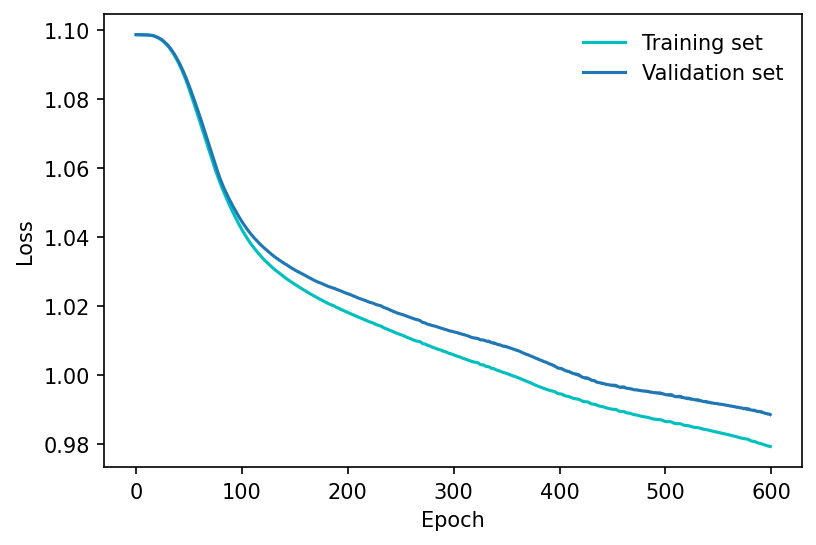

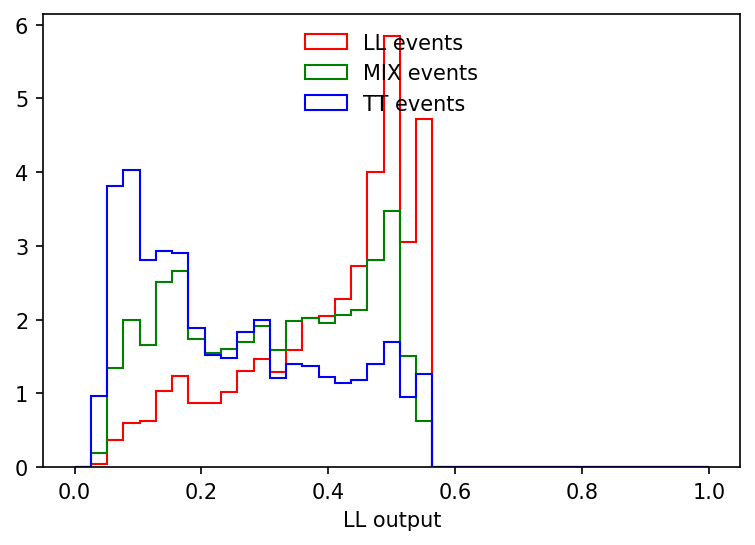

[I 2023-04-19 13:56:54,063] Trial 80 finished with value: 0.511416604742282 and parameters: {'learning_rate': 0.0008083374964851555, 'n_layers': 10, 'N_NODES': 19}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:24<00:00, 24.39it/s]


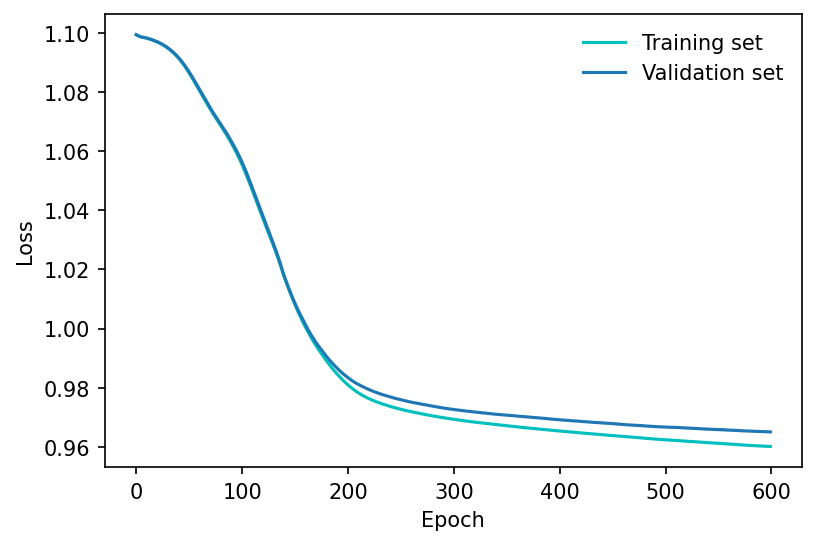

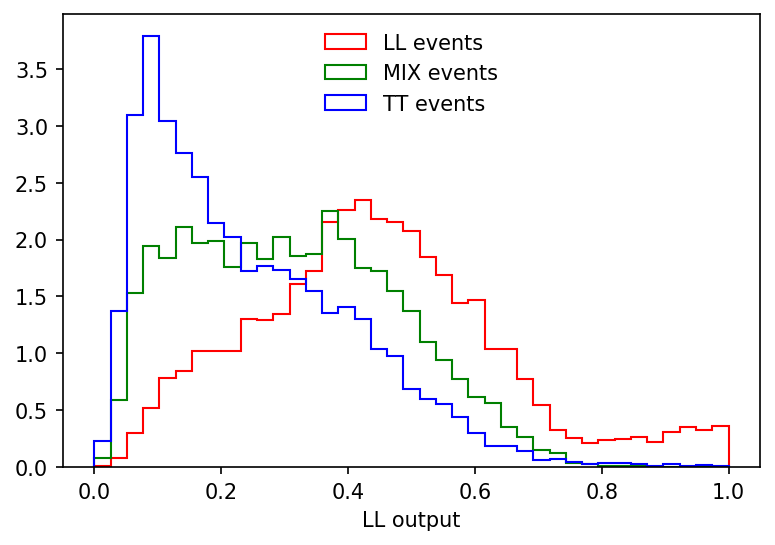

[I 2023-04-19 13:57:19,196] Trial 81 finished with value: 0.5233398635411741 and parameters: {'learning_rate': 0.000766905509906314, 'n_layers': 10, 'N_NODES': 10}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:21<00:00, 27.71it/s]


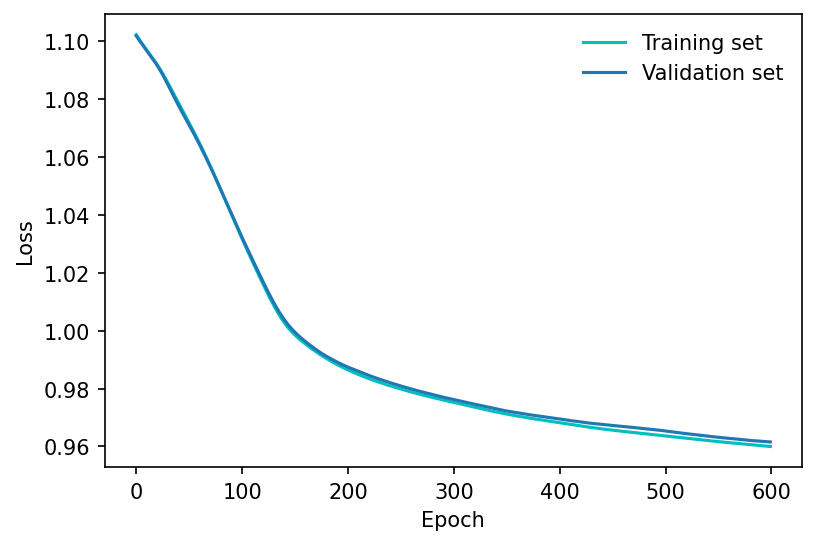

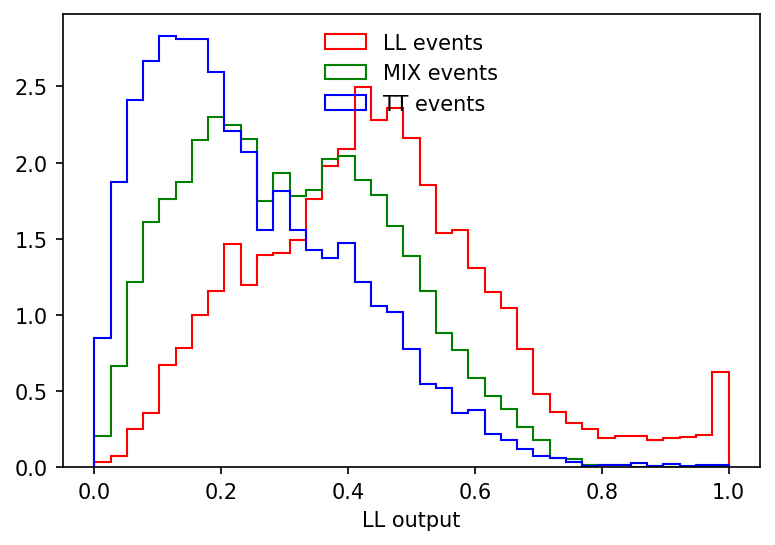

[I 2023-04-19 13:57:41,292] Trial 82 finished with value: 0.5254340336418294 and parameters: {'learning_rate': 0.0007184253275564149, 'n_layers': 10, 'N_NODES': 6}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:26<00:00, 22.89it/s]


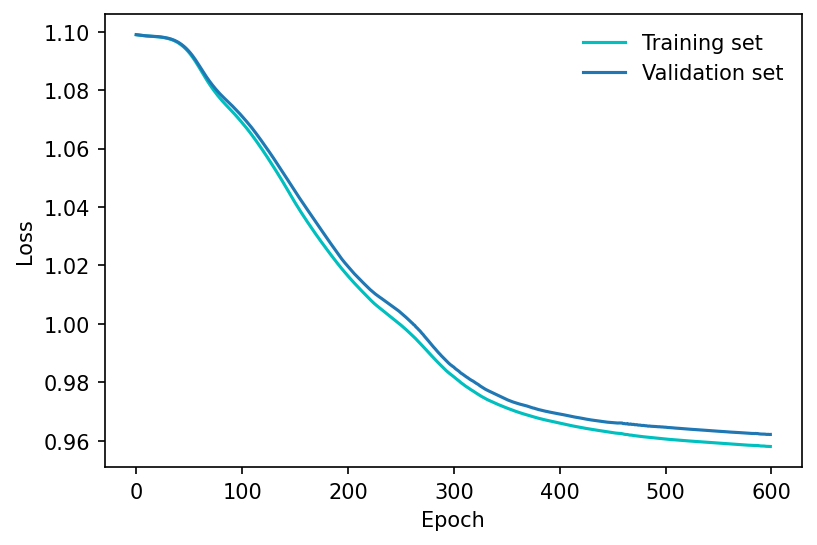

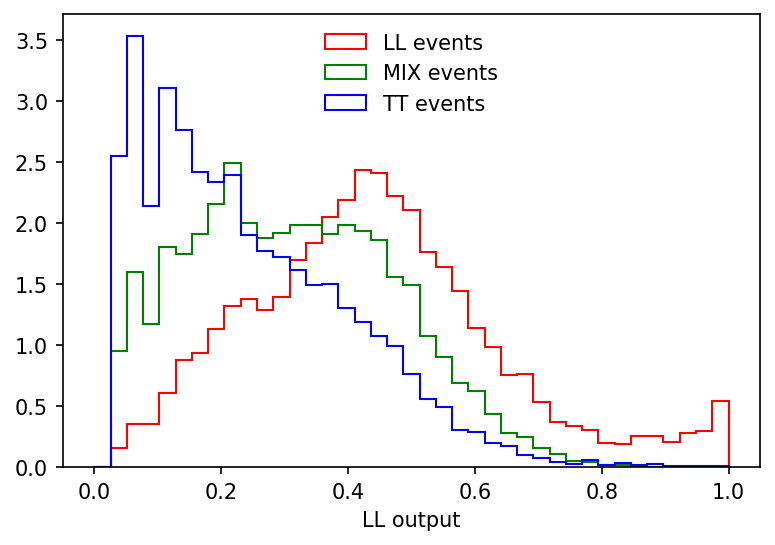

[I 2023-04-19 13:58:08,018] Trial 83 finished with value: 0.5221238938053098 and parameters: {'learning_rate': 0.0007486476267648551, 'n_layers': 9, 'N_NODES': 12}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:29<00:00, 20.07it/s]


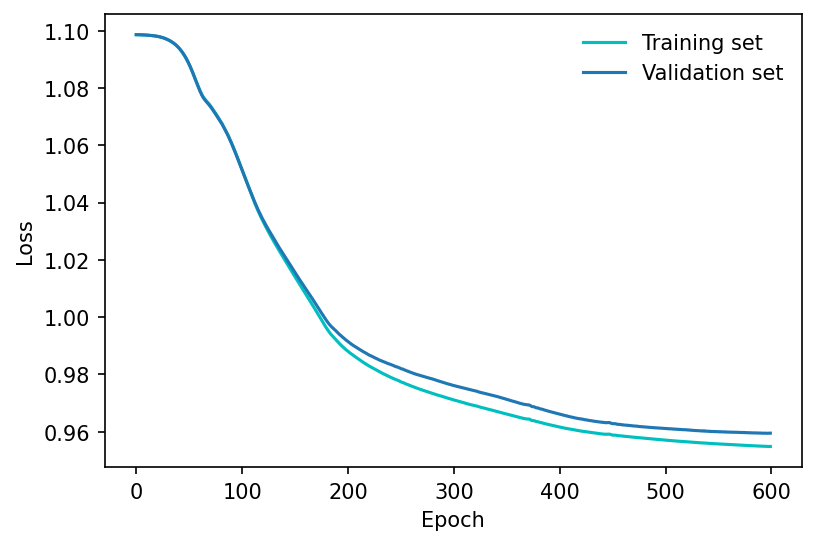

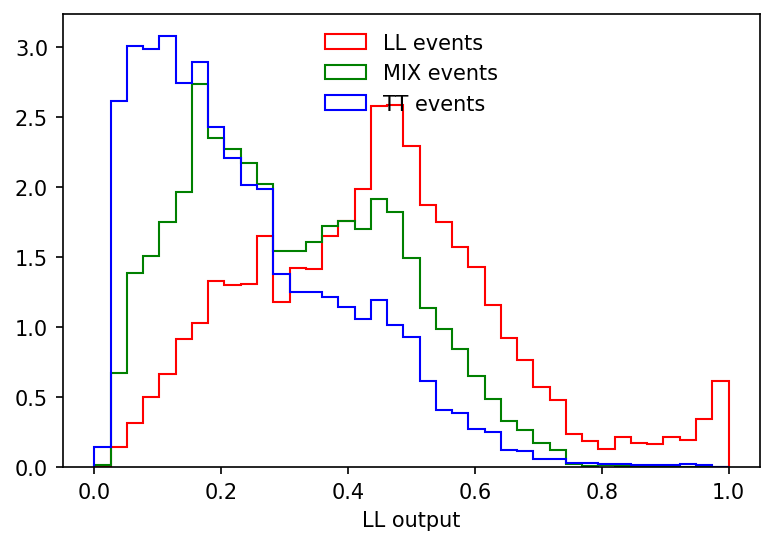

[I 2023-04-19 13:58:38,474] Trial 84 finished with value: 0.5261095723839763 and parameters: {'learning_rate': 0.0007804443852480615, 'n_layers': 10, 'N_NODES': 15}. Best is trial 34 with value: 0.5282375194217388.
100%|██████████| 600/600 [00:30<00:00, 19.89it/s]


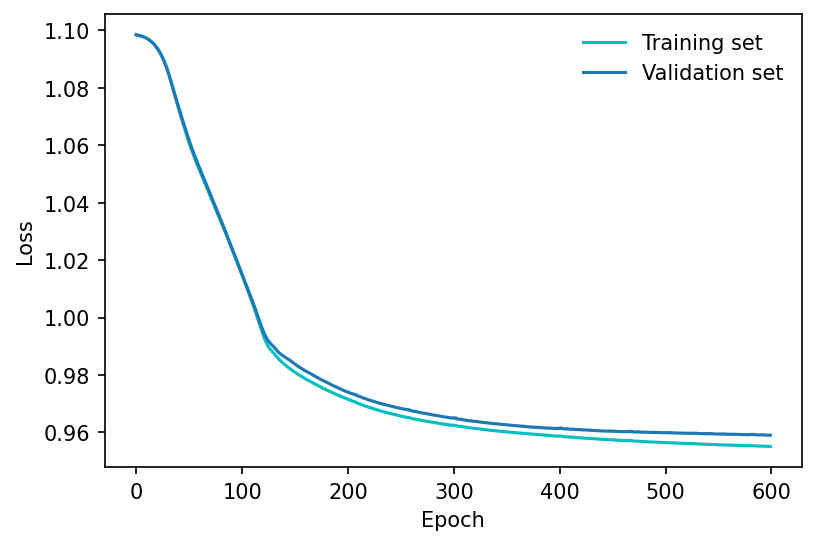

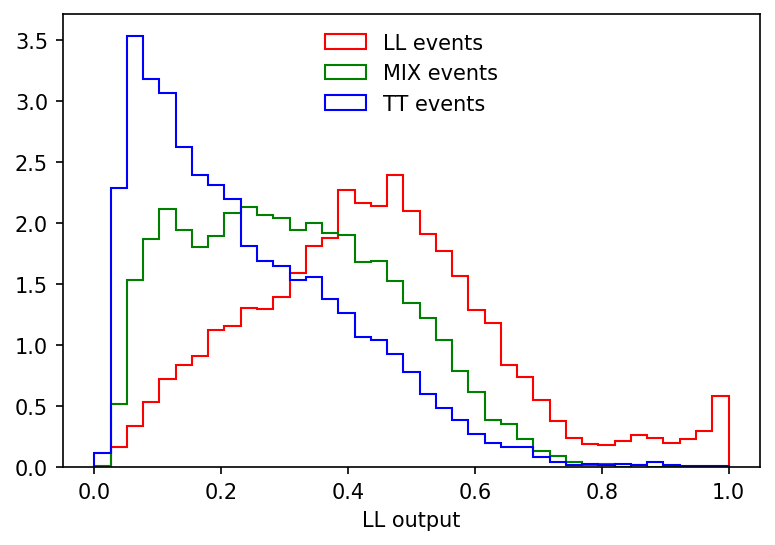

[I 2023-04-19 13:59:09,183] Trial 85 finished with value: 0.5296561507802472 and parameters: {'learning_rate': 0.0008776006851223759, 'n_layers': 10, 'N_NODES': 15}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [00:40<00:00, 14.68it/s]


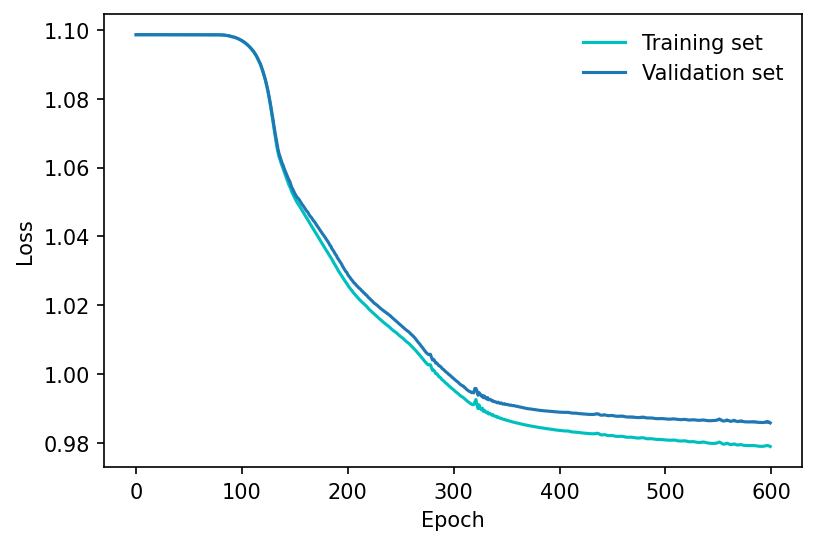

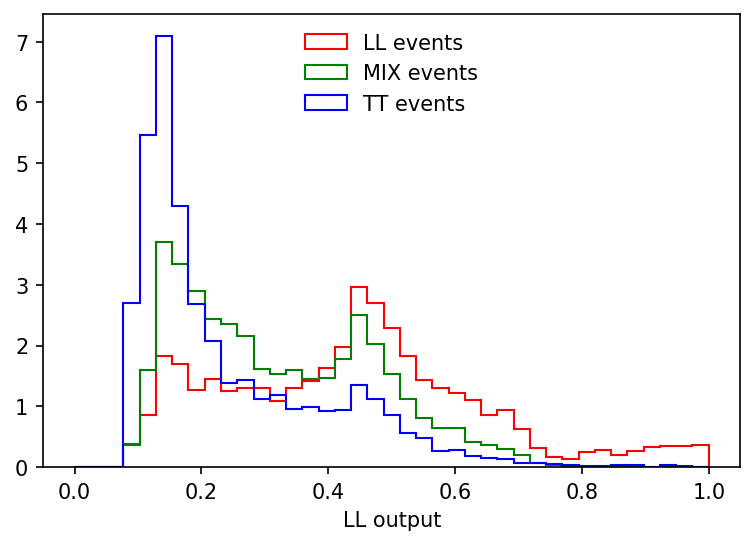

[I 2023-04-19 13:59:50,772] Trial 86 finished with value: 0.5088833344592313 and parameters: {'learning_rate': 0.0008778990062907686, 'n_layers': 9, 'N_NODES': 26}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [00:35<00:00, 16.92it/s]


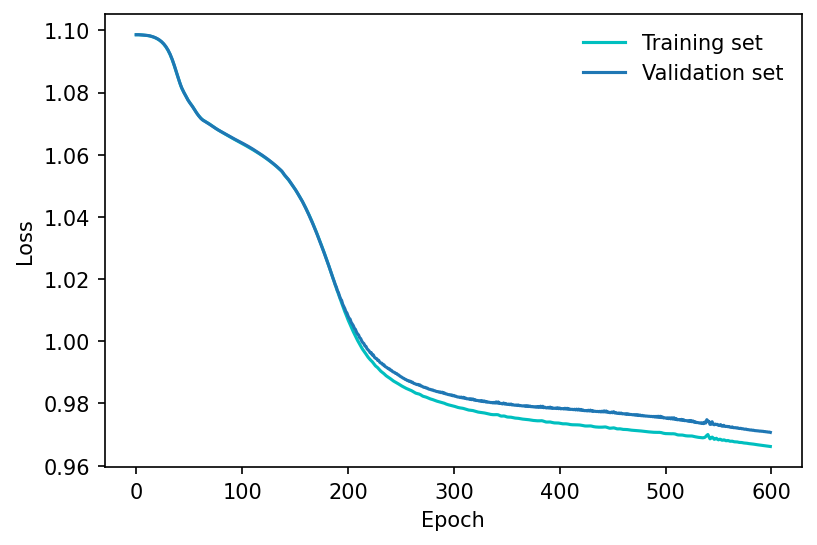

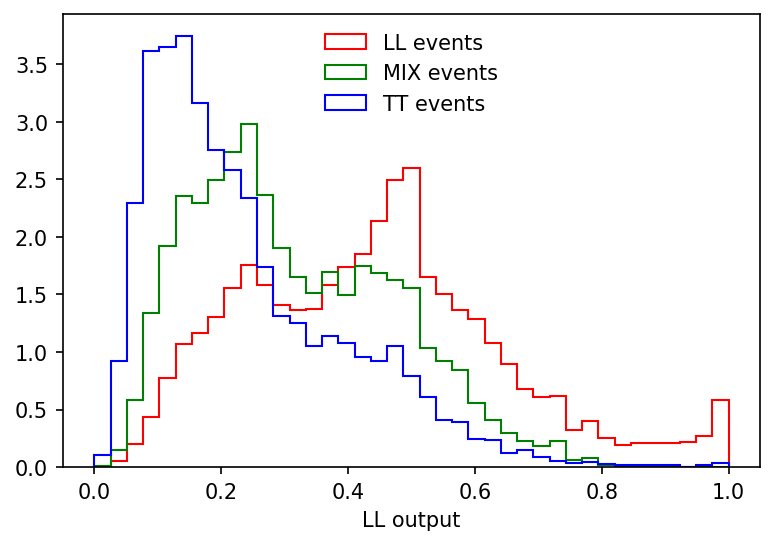

[I 2023-04-19 14:00:27,087] Trial 87 finished with value: 0.5182733229750727 and parameters: {'learning_rate': 0.0009012209701967371, 'n_layers': 10, 'N_NODES': 22}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [00:28<00:00, 21.33it/s]


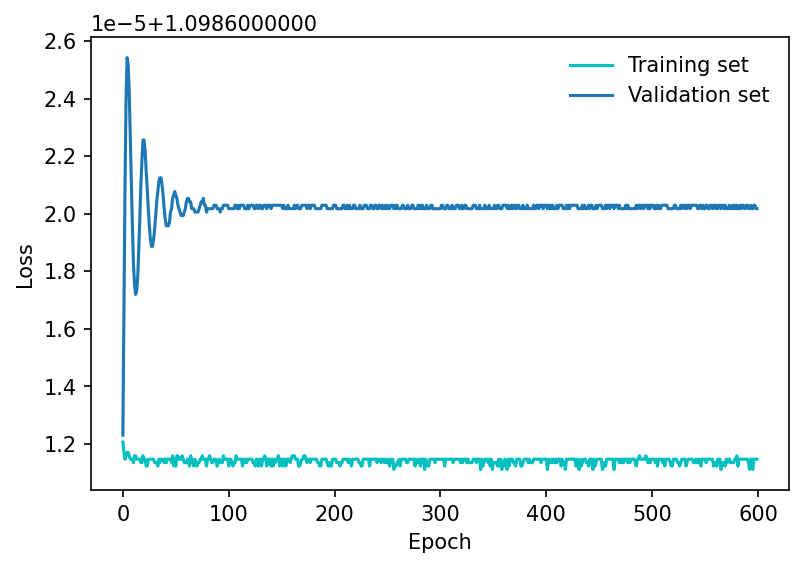

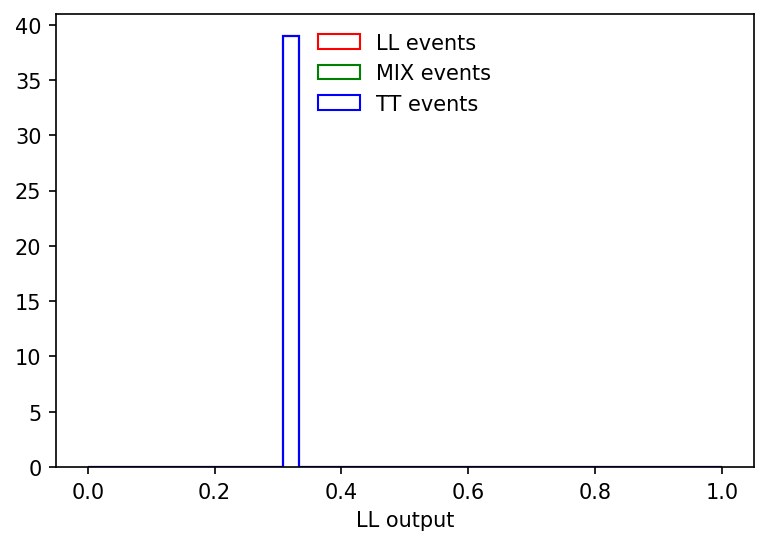

[I 2023-04-19 14:00:55,786] Trial 88 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0008523173459541485, 'n_layers': 2, 'N_NODES': 17}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [01:35<00:00,  6.28it/s]


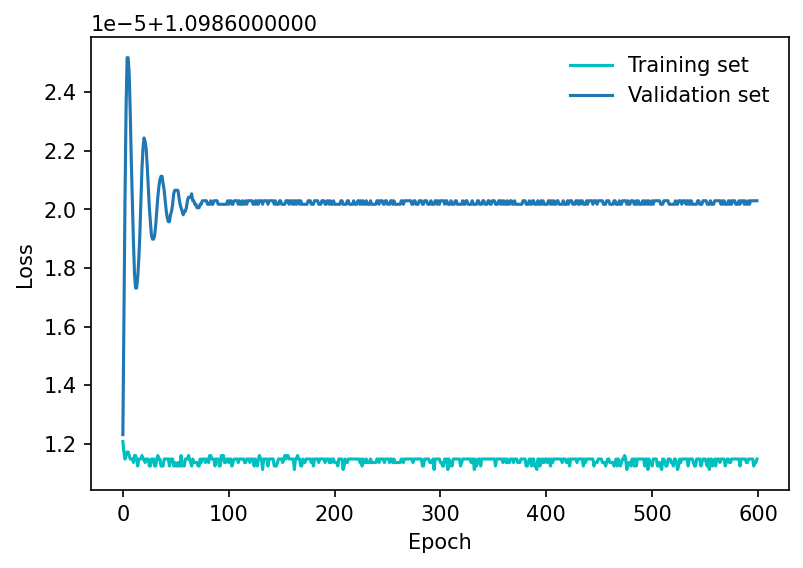

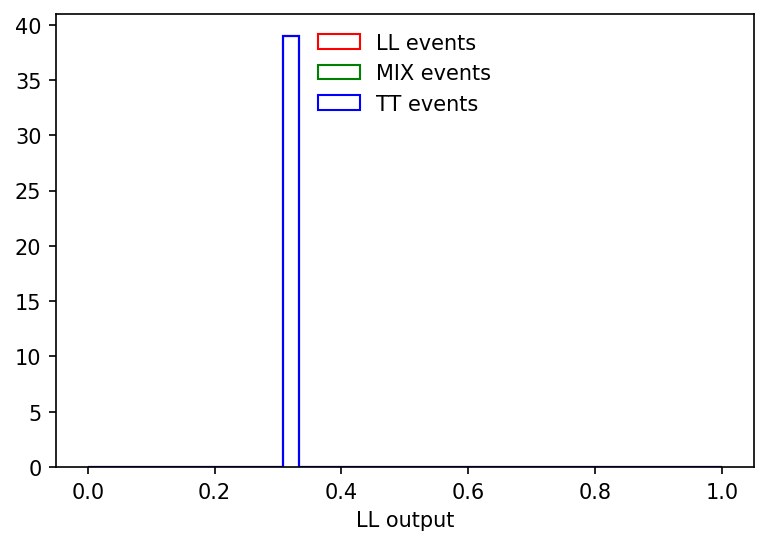

[I 2023-04-19 14:02:32,840] Trial 89 finished with value: 0.33094642977774774 and parameters: {'learning_rate': 0.0008057152324542059, 'n_layers': 7, 'N_NODES': 85}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [00:31<00:00, 18.82it/s]


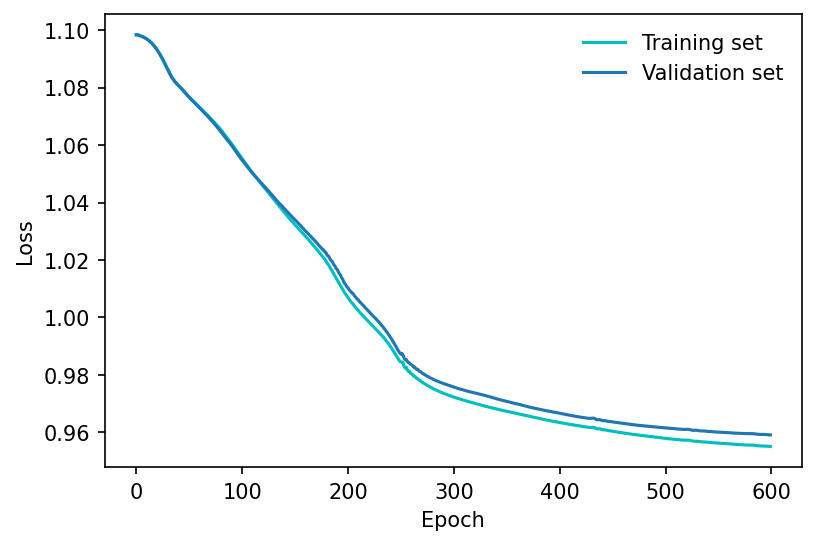

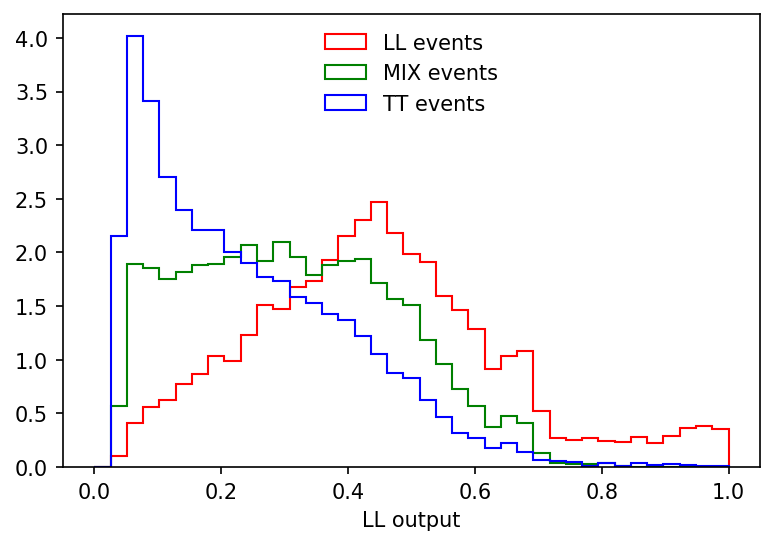

[I 2023-04-19 14:03:05,270] Trial 90 finished with value: 0.5269539958116598 and parameters: {'learning_rate': 0.0008865972375473193, 'n_layers': 10, 'N_NODES': 15}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [00:32<00:00, 18.73it/s]


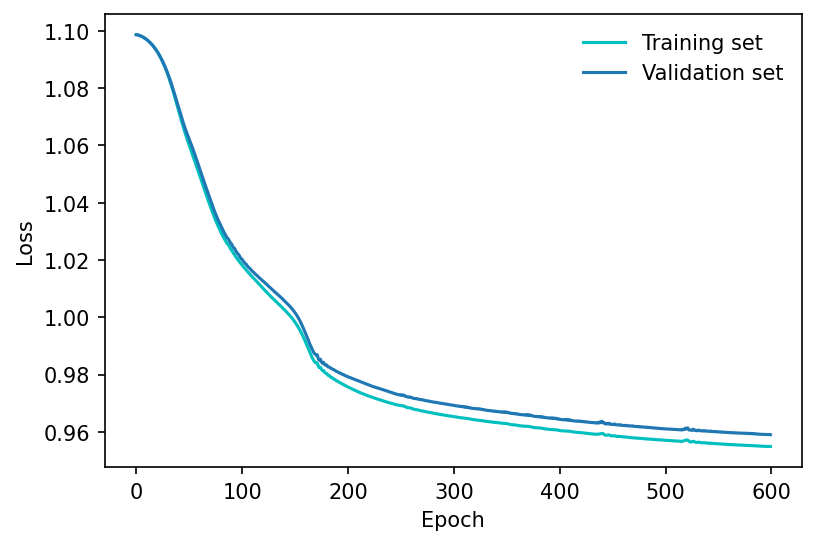

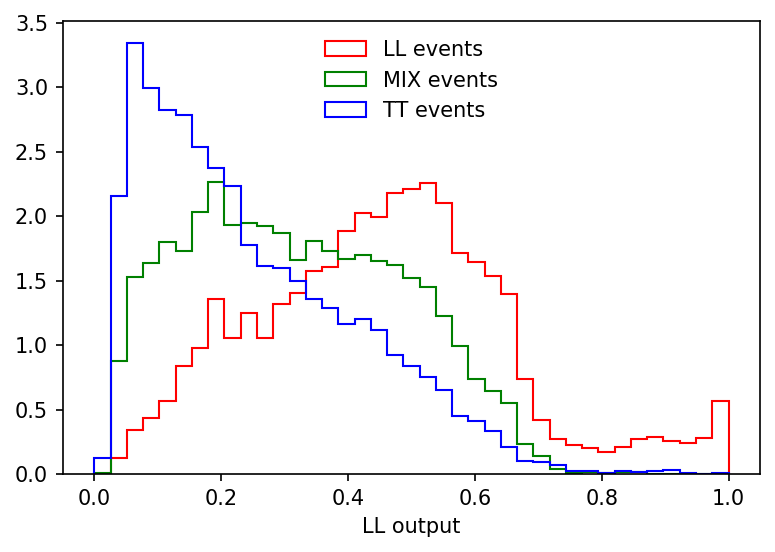

[I 2023-04-19 14:03:37,877] Trial 91 finished with value: 0.5269539958116598 and parameters: {'learning_rate': 0.000943755826296814, 'n_layers': 10, 'N_NODES': 15}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [00:26<00:00, 22.59it/s]


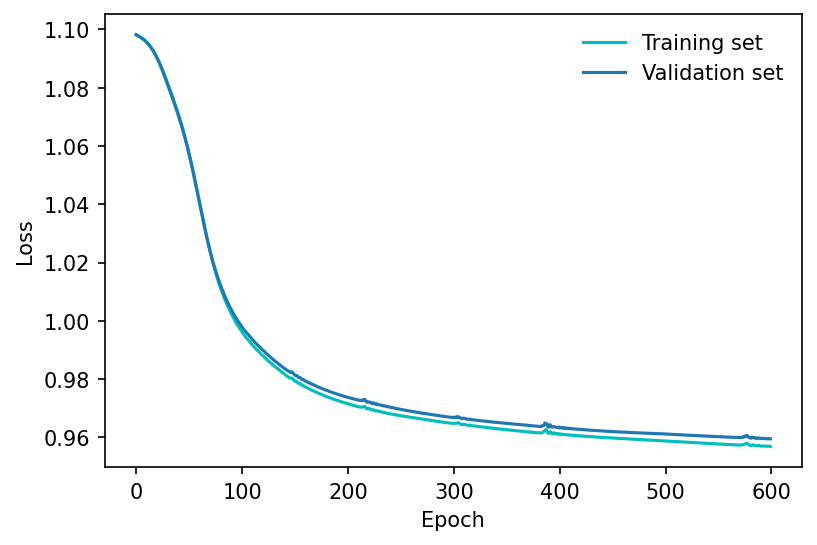

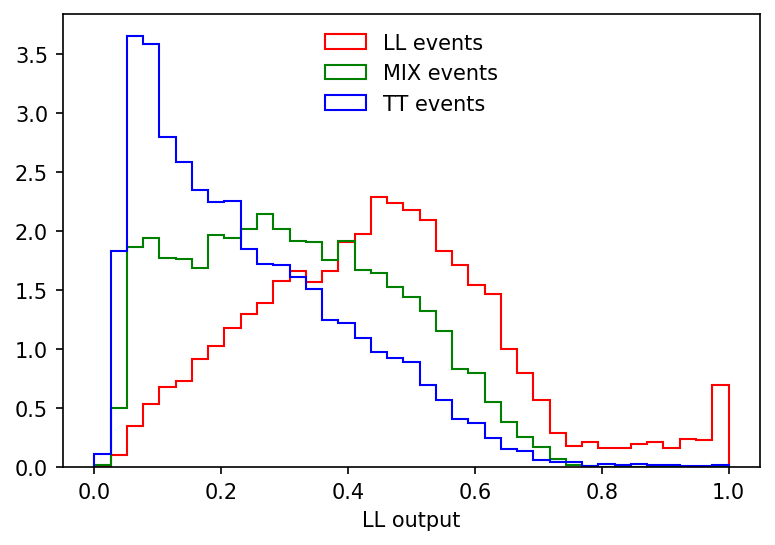

[I 2023-04-19 14:04:04,954] Trial 92 finished with value: 0.5270215496858744 and parameters: {'learning_rate': 0.0009488277782716222, 'n_layers': 10, 'N_NODES': 10}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [00:24<00:00, 24.20it/s]


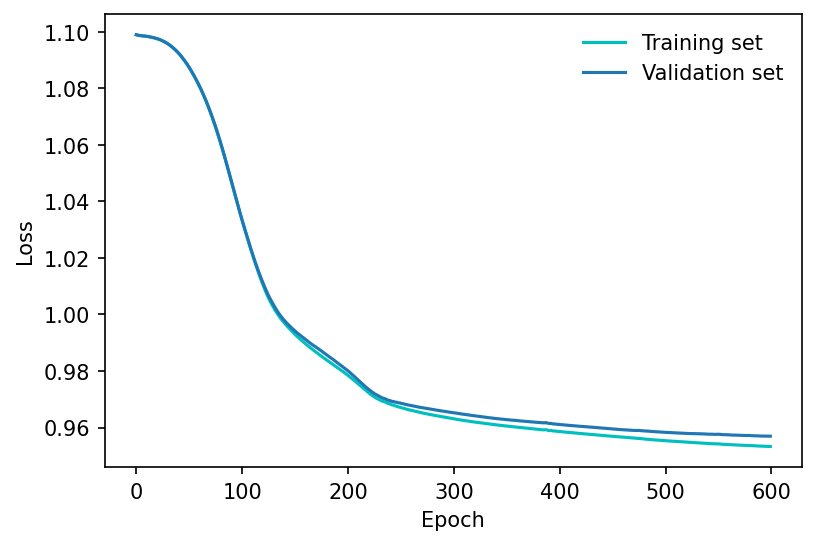

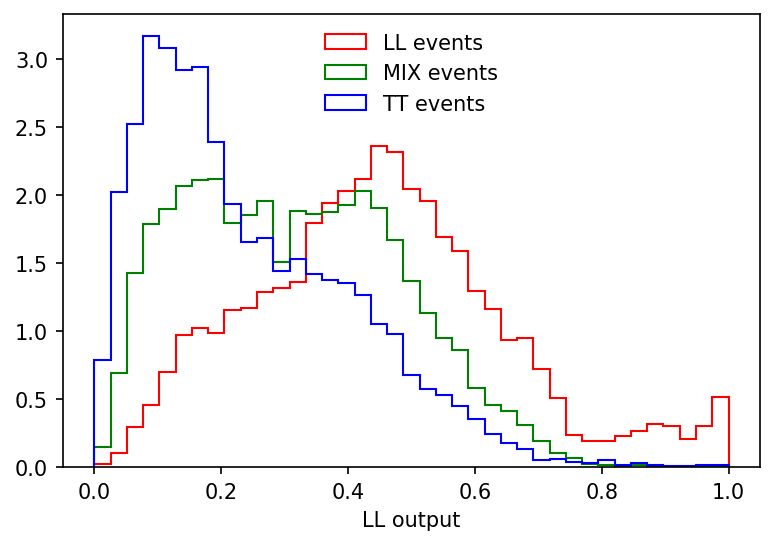

[I 2023-04-19 14:04:30,216] Trial 93 finished with value: 0.5278659731135581 and parameters: {'learning_rate': 0.0008916525420404797, 'n_layers': 10, 'N_NODES': 9}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [00:24<00:00, 24.83it/s]


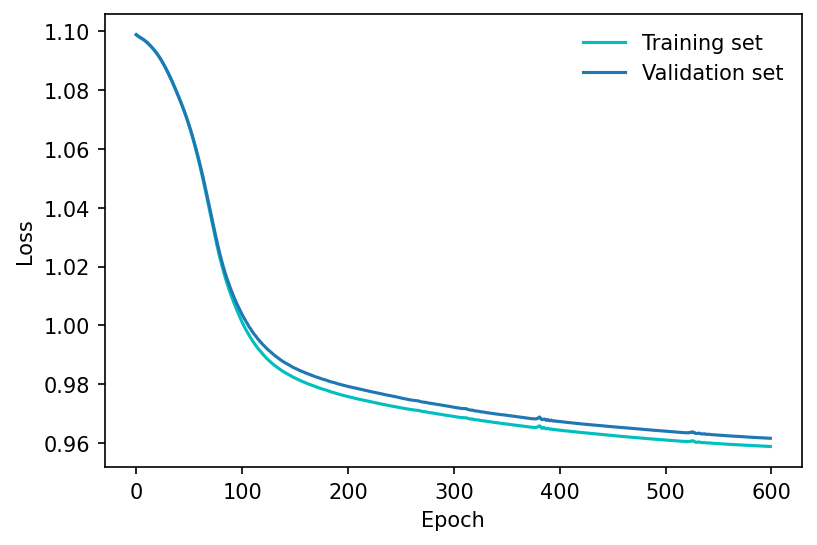

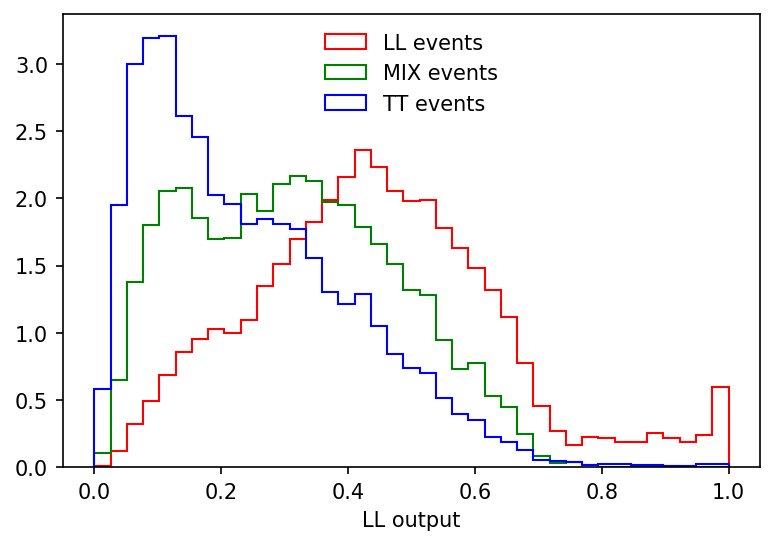

[I 2023-04-19 14:04:54,865] Trial 94 finished with value: 0.5262446801324056 and parameters: {'learning_rate': 0.0009240732508683564, 'n_layers': 10, 'N_NODES': 9}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [00:19<00:00, 30.56it/s]


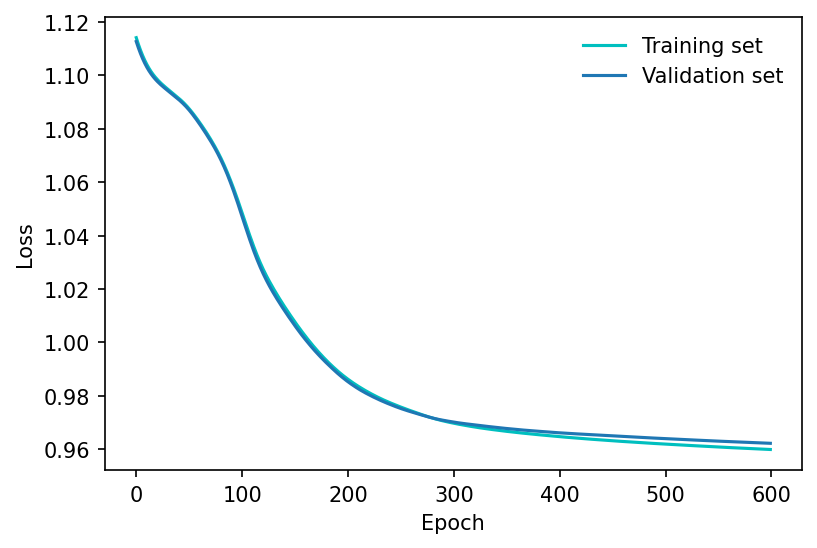

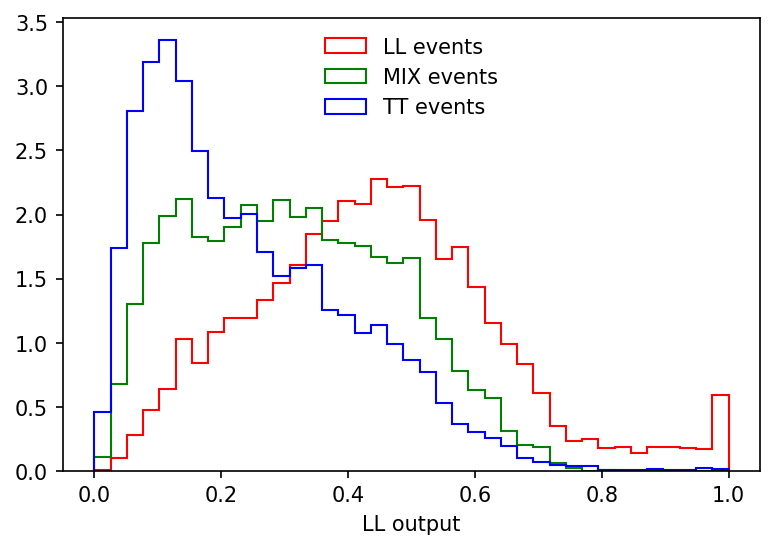

[I 2023-04-19 14:05:14,969] Trial 95 finished with value: 0.524015402283321 and parameters: {'learning_rate': 0.0009587665443629893, 'n_layers': 9, 'N_NODES': 3}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [00:22<00:00, 26.77it/s]


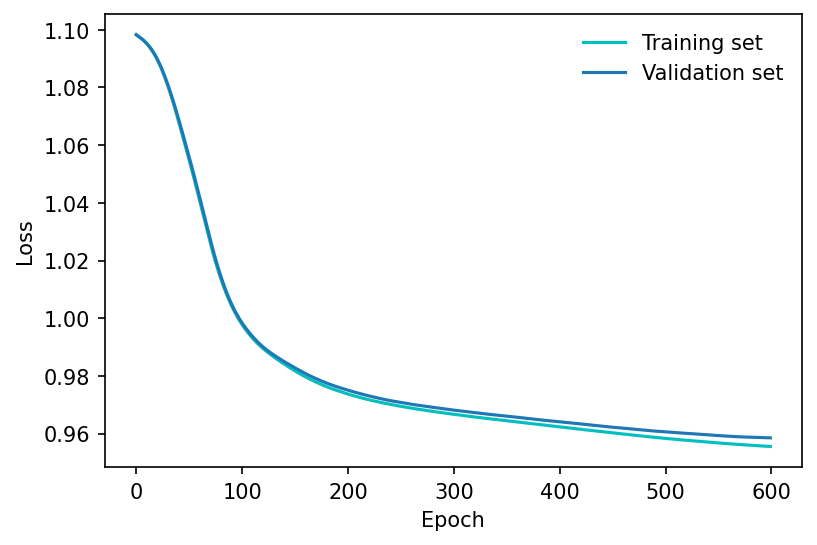

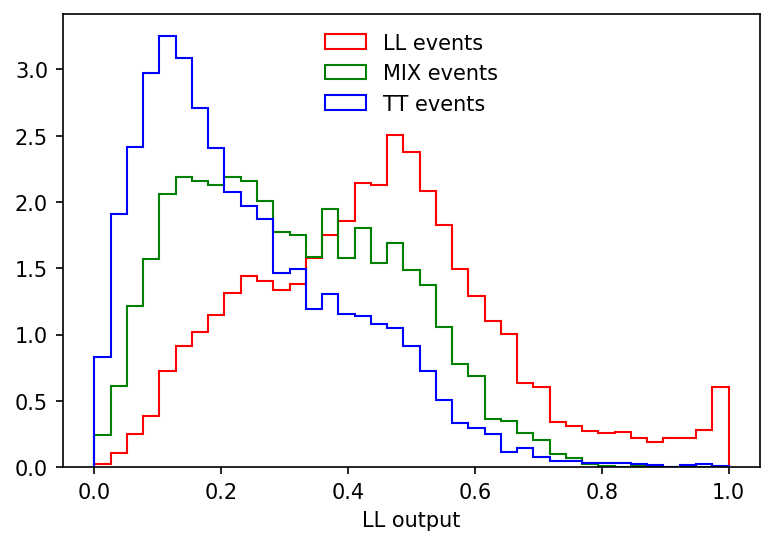

[I 2023-04-19 14:05:37,863] Trial 96 finished with value: 0.5288117273525637 and parameters: {'learning_rate': 0.0009467842433069672, 'n_layers': 10, 'N_NODES': 6}. Best is trial 85 with value: 0.5296561507802472.
100%|██████████| 600/600 [00:21<00:00, 27.73it/s]


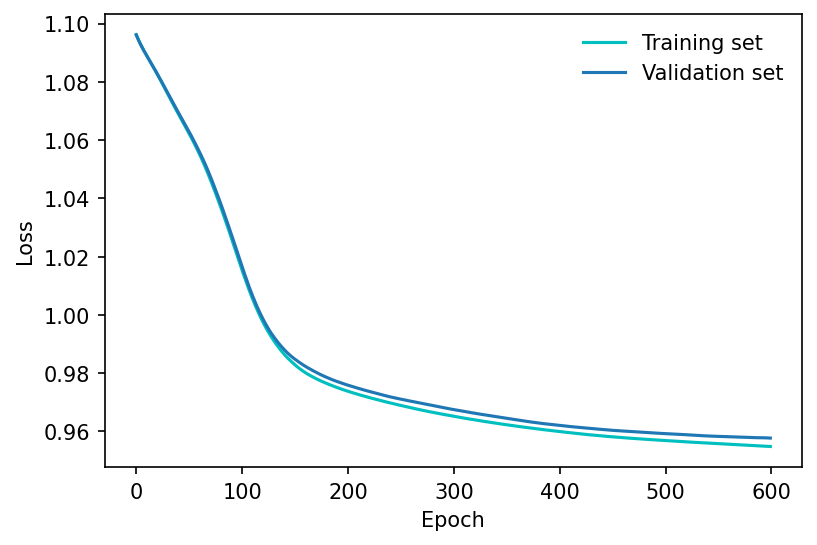

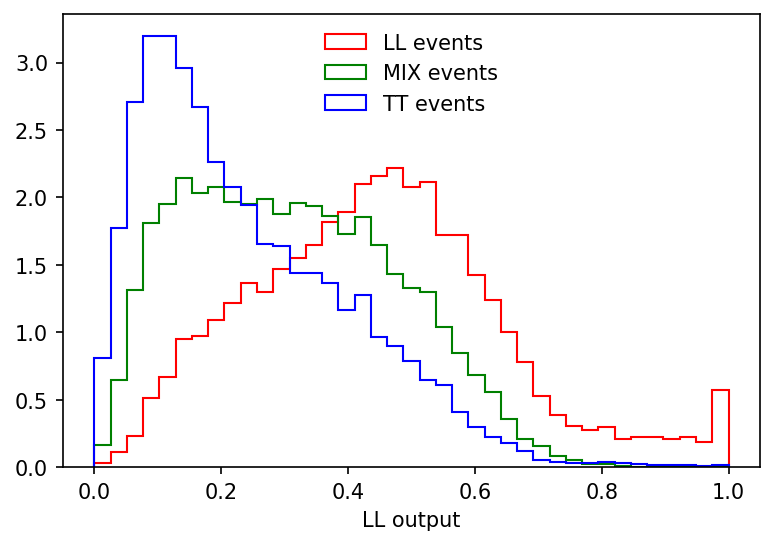

[I 2023-04-19 14:05:59,970] Trial 97 finished with value: 0.529825035465784 and parameters: {'learning_rate': 0.0009690747555899833, 'n_layers': 10, 'N_NODES': 5}. Best is trial 97 with value: 0.529825035465784.
100%|██████████| 600/600 [00:17<00:00, 34.91it/s]


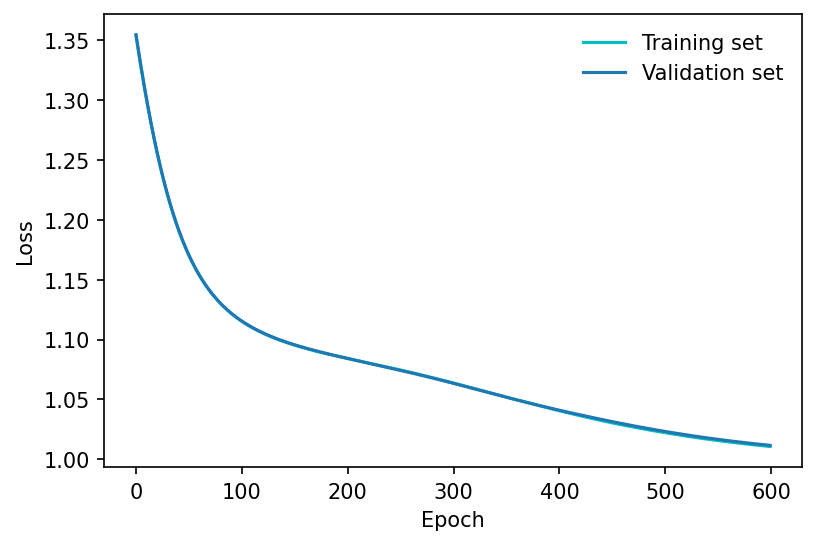

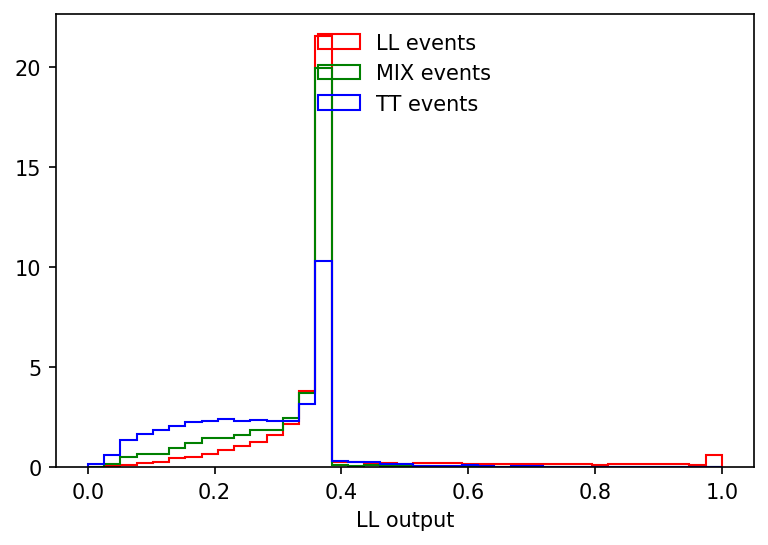

[I 2023-04-19 14:06:17,565] Trial 98 finished with value: 0.46328446936431805 and parameters: {'learning_rate': 0.0009607384105506765, 'n_layers': 4, 'N_NODES': 1}. Best is trial 97 with value: 0.529825035465784.
100%|██████████| 600/600 [00:26<00:00, 22.51it/s]


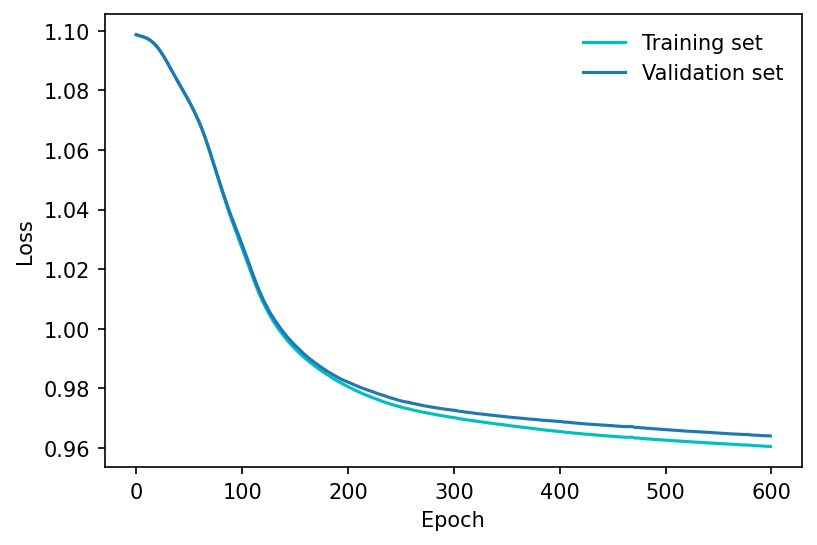

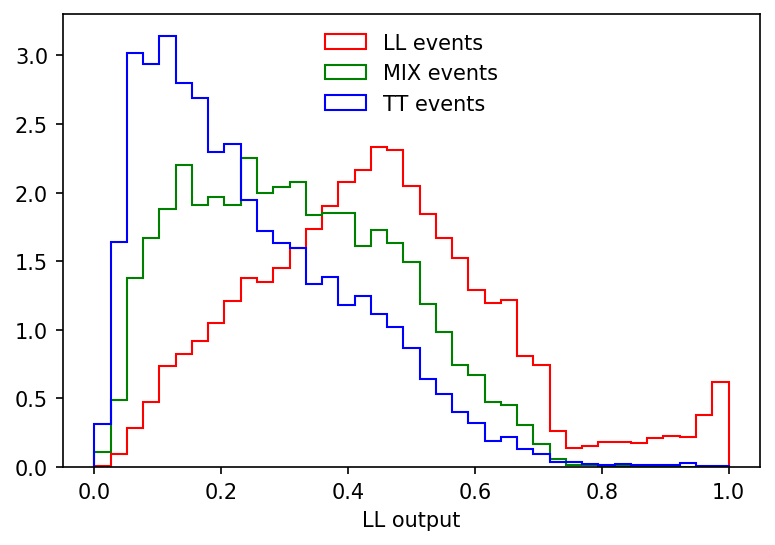

[I 2023-04-19 14:06:44,975] Trial 99 finished with value: 0.5219887860568804 and parameters: {'learning_rate': 0.0009433085283380675, 'n_layers': 9, 'N_NODES': 11}. Best is trial 97 with value: 0.529825035465784.


In [25]:
study = optuna.create_study(directions=['maximize'])
study.optimize(evaluate_performance,n_trials=100)

/tmp/ipykernel_515/1391578024.py:9: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_optimization_history(study)


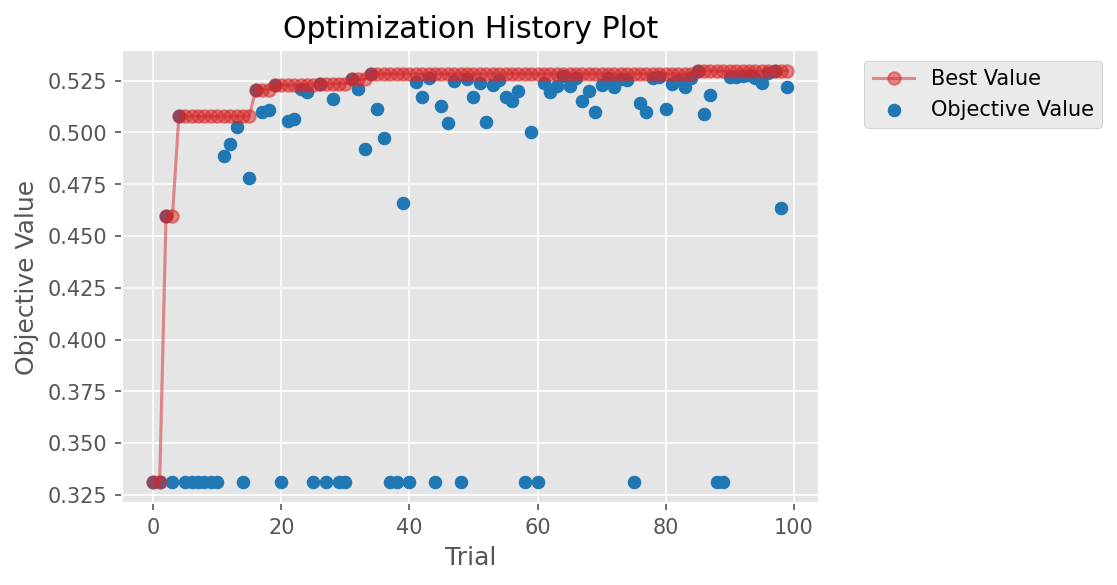

In [28]:
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_slice

fig = plot_optimization_history(study)
# fig.show()

/tmp/ipykernel_515/3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

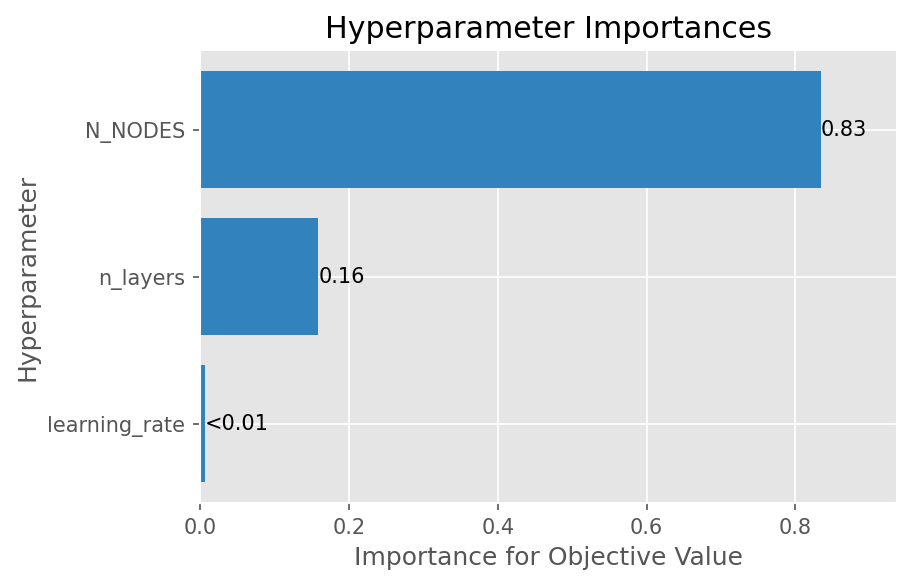

In [29]:
plot_param_importances(study)

In [34]:
study.best_params

{'learning_rate': 0.0009690747555899833, 'n_layers': 10, 'N_NODES': 5}